# 本文件说明
- 读取数据、预处理数据

# 基本设置

In [1]:
import xlrd
import datetime

%matplotlib inline
import numpy as np
import pandas as pd
from toolkits.nlp import pre_cor_circ
from toolkits.nlp import pre_cor_cbrc
from toolkits.setup.specific_func import contain_ch, set_ch_pd
set_ch_pd()
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.107 seconds.
Prefix dict has been built succesfully.


In [2]:
%load_ext autoreload
%autoreload 2

## 一些函数

In [3]:
def predict_right(folder, file_list):
    '''预测正确数据'''
    right_data = pd.DataFrame()
    for file_name in file_list:
        currentPath  = '{0}/{1}'.format(folder, file_name)
        excel = xlrd.open_workbook(currentPath)
        sheet_names = [sheet.name for sheet in excel.sheets()]
        for sheet_name in sheet_names:    
            tmp_data = pd.read_excel(currentPath, sheet_name)
    #         tmp_data = tmp_data[tmp_data['R_W'] == 'Right']
            print('去空值前： ', tmp_data.shape, file_name, sheet_name)
#             tmp_data = tmp_data[tmp_data['备注'] != '删除']
    #         tmp_data = tmp_data.dropna(subset = ['raw_title'], axis = 0)
#             print('去空值后： ', tmp_data.shape, file_name, sheet_name)
            right_data = pd.concat([right_data, tmp_data], axis = 0)    
    return right_data

In [57]:
def correct_wrong_data(folder, file_list):
    '''预测错误修正后数据'''
    correct_wrong_data = pd.DataFrame()
    for file_name in file_list:
        currentPath  = '{0}/{1}'.format(folder, file_name)
        excel = xlrd.open_workbook(currentPath)
        sheet_names = [sheet.name for sheet in excel.sheets()]
        for sheet_name in sheet_names:    
            tmp_data = pd.read_excel(currentPath, sheet_name)
    #         tmp_data = tmp_data[tmp_data['R_W'] == 'Wrong']
            print('去删除前： ', tmp_data.shape, file_name, sheet_name)
            tmp_data = tmp_data[tmp_data['备注'] != '删除']
            tmp_data['备注'] =tmp_data['备注'].astype(str)
    #         tmp_data = tmp_data.dropna(subset = ['raw_title'], axis = 0)
            print('去删除后： ', tmp_data.shape, file_name, sheet_name)

            tmp_data['人工判断'] = tmp_data.apply(lambda x:1 if x['label'] == x['备注'] else 0, axis = 1)
            tmp_data['算法判断'] = tmp_data.apply(lambda x:1 if x['predict_label'] == x['备注'] else 0, axis = 1)
            print('人工误判率： %0.2f'%(1 - tmp_data['人工判断'].sum() / tmp_data.shape[0]),
                  '算法误判率： %0.2f'%(1 - tmp_data['算法判断'].sum() / tmp_data.shape[0]))
            print()

            correct_wrong_data = pd.concat([correct_wrong_data, tmp_data], axis = 0)
    return correct_wrong_data

In [58]:
def get_new_data(folder, file_list):
    '''新补充数据'''
    new_data = pd.DataFrame()
    for file_name in file_list:
        currentPath  = '{0}/{1}'.format(folder, file_name)
        excel = xlrd.open_workbook(currentPath)
        sheet_names = [sheet.name for sheet in excel.sheets()]
        for sheet_name in sheet_names:    
            tmp_data = pd.read_excel(currentPath, sheet_name)
            print(tmp_data.columns)
            tmp_data = tmp_data[['label', 'title', 'content']]
            tmp_data['label'] =tmp_data['label'].astype(str)
            print('去空值前： ', tmp_data.shape, file_name, sheet_name)
            tmp_data = tmp_data.dropna(subset = ['label'], axis = 0)
            print('去空值后： ', tmp_data.shape, file_name, sheet_name)
            new_data = pd.concat([new_data, tmp_data], axis = 0)    
    return new_data

In [59]:
def get_PR_plot_data(feedback_data, date, plot_data, key_col):
    y_pred_class = feedback_data[feedback_data['date'] == date][key_col].astype(str).tolist()
    y_test = feedback_data[feedback_data['date'] == date]['label'].astype(str).tolist()
    print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
    print(metrics.classification_report(y_test, y_pred_class))
    print('confusion_matrix: ')
    print( metrics.confusion_matrix(y_test, y_pred_class))
    print()       
    
    classification_report = metrics.classification_report(y_test, y_pred_class)
    lines = classification_report.split('\n')
    # plot_data = []
    for index, line in enumerate(lines[2 : len(lines)]):
        t = line.strip().split()
        if len(t) < 2: continue    
        if (index + 2) < (len(lines) - 2):
            t = [float(v) if i > 0 else v for i, v in enumerate(t)]
            plot_data.append(t + [date])
        else :
            t = [float(v) if i > 2 else v for i, v in enumerate(t) ]
            plot_data.append(['avg/total'] + t[3:] + [date])    
            
    return plot_data

In [60]:
def get_feedback_data(folder, file_list, key_col):
    '''模型预测后反馈数据'''
    feedback_data = pd.DataFrame()
    label_list = []
    sum_list = []
    right_list = []
    plot_data = []
    for file_name in file_list:
        print('  ----    ', file_name)
        date = file_name.split('_')[0]
        currentPath  = '{0}/{1}'.format(folder, file_name)
        excel = xlrd.open_workbook(currentPath)
        sheet_names = [sheet.name for sheet in excel.sheets()]
        for sheet_name in sheet_names:   
            tmp_data = pd.read_excel(currentPath, sheet_name)    
            tmp_data['label'] =tmp_data['label'].astype(str)
            tmp_data = tmp_data[tmp_data['label'] != '删除']
            tmp_data_1 = tmp_data[tmp_data['label'] == sheet_name]

            label_list.append(sheet_name)
            sum_list.append(tmp_data.shape[0])
            right_list.append(tmp_data_1.shape[0])
            print('类别：', sheet_name, '总数：', tmp_data.shape[0], 
                  '正确数', tmp_data_1.shape[0], 
                  '正确比例', tmp_data_1.shape[0]/tmp_data.shape[0])
            
            if key_col in tmp_data_1.columns:
                tmp_data_1 = tmp_data[[key_col, 'label', 'title', 'content']]
            else :
                tmp_data_1 = tmp_data[['label', 'title', 'content']]
                if contain_ch(sheet_name) :
                    tmp_data_1['predict_label'] = sheet_name
                else :
                    tmp_data_1['predict_label'] = ''
                
            tmp_data_1['date'] = date
            print('去空值前： ', tmp_data_1.shape, file_name, sheet_name)
            tmp_data_1 = tmp_data_1.dropna(subset = ['label'], axis = 0)
            print('去空值后： ', tmp_data_1.shape, file_name, sheet_name)
            feedback_data = pd.concat([feedback_data, tmp_data_1], axis = 0)
            print() 
                        
        plot_data = get_PR_plot_data(feedback_data, date, plot_data, key_col) 
            
    PR_data = feedback_data[['date', key_col, 'label']]
    feedback_data = feedback_data.drop('date', axis = 1)
    feedback_data = feedback_data.drop(key_col, axis = 1)
    PR_plot_data  = pd.DataFrame(plot_data, columns = ['label', 'precision', 'recall', 
                                                    'f1-score', 'support', 'date'])     
    
    return feedback_data, PR_data, PR_plot_data

In [8]:
def pre_save(pre_func, data, save_folder):
    print(data.shape)
    print('save_folder: ', save_folder)
    
    titles = pre_func(data['title'].tolist())
    print('title num: ', len(titles))
    save_filename = save_folder + 'corpus/titles.txt'
    fid = open(save_filename, "w+", encoding='UTF-8')
    for line in titles:
        fid.write(line + '\n')
    fid.close()  
    
#     print(len(data['content'].tolist()))
    contents = pre_func(data['content'].tolist())
    print('content num: ', len(contents))
    print(contents[0])
    # contents = [re.sub(r'[a-z]*', '', x) for x in contents]
    # print(len(contents))
    # print(contents[:2])
    coprus_save_filename = save_folder + 'corpus/contents.txt'
    f = open(coprus_save_filename, "w+", encoding='UTF-8')
    for line in contents:
        f.write(line + '\n')
    f.close()    

    label = data['label'].tolist()
    print('label num: ', len(label))
    coprus_save_filename = save_folder + 'corpus/labels.txt'
    f = open(coprus_save_filename, "w+", encoding='UTF-8')
    for line in label:
        f.write(str(line) + '\n')
    f.close()

    data.to_excel(save_folder + 'corpus/title_content_label.xlsx', index = False)
    

# 保险业：1 八分类

## 读取数据

In [9]:
folder = 'circ_data_class/20180910'

### 预测正确数据

In [10]:
file_list_1 = ['circ_class_sel_else_20180827.xlsx',]
circ_raw_class_1 = predict_right(folder, file_list_1)

circ_raw_class_1['label'] = circ_raw_class_1['label'].apply(lambda x:x.strip())    
circ_raw_class_1 = circ_raw_class_1[['label', 'raw_title', 'raw_content']]
circ_raw_class_1.columns = ['label', 'title', 'content']
print('总数：', circ_raw_class_1.shape)
circ_raw_class_1.head()

去空值前：  (1284, 8) circ_class_sel_else_20180827.xlsx 公司内部管理
去空值前：  (3197, 8) circ_class_sel_else_20180827.xlsx 噪音
去空值前：  (1320, 8) circ_class_sel_else_20180827.xlsx 行业
去空值前：  (1463, 8) circ_class_sel_else_20180827.xlsx 消费服务
去空值前：  (753, 8) circ_class_sel_else_20180827.xlsx 资本市场
去空值前：  (1511, 8) circ_class_sel_else_20180827.xlsx 监管
去空值前：  (500, 8) circ_class_sel_else_20180827.xlsx 产品销售
去空值前：  (1403, 8) circ_class_sel_else_20180827.xlsx 其他相关报道
总数： (11431, 3)


,label,title,content
0,公司内部管理,天安销售虚列费用为员工发福利 相关负责人被处罚,天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:28\n中国保监会网站\n\r当事人：张磊\n\r身份证号码：32021119690412****\n\r职务：天安佰盈保险销售有限公司宁波分公司（以下简称天安销售宁波分公司）主要负责人\n\r住所：宁波市鄞州区会展路128 号9 层9D04-9D12 室\n\r依据《中华人民共和国保险法》（2015 年修正）的有关规定，我局天安销售宁波分公司涉嫌违法一案进行了调查、审理，依法向当事人告知了作出行政处罚的事实、理由、依据以及当事人依法享有的权利。当事人未陈述申辩，未要求听证。\n\r经查，天安销售宁波分公司存在如下违法行为：\n\r一、财务数据不真实\n\r2016 年，天安销售宁波分公司虚列业务招待费92.33 万元，实际用于向员工发放福利。公司主要负责人张磊为对该行为直接负责的主管人员。\n\r二、变更营业场所地址未按规定报告\n\r2016 年8 月，天安销售宁波分公司营业场所地址由江北区庄桥街道北环西路500 号（5）幢二层5-27 室变更为鄞州区会展路128 号9层9D04-9D12 室。截至2017 年10 月24 日，上述事项未按规定向我局书面报告。公司主要负责人张磊为该机构直接负责的主管人员。\n\r上述事实，有财务凭证、租赁合同、营业执照、情况说明、调查笔录、任职文件、现场检查事实确认书等证据证明。\n\r综上，我局作出如下处罚：\n\r一、天安销售宁波分公司财务数据不真实的行为，违反了《中华人民共和国保险法》（2015 年修正）第八十六条和第一百三十二条的规定。根据《中华人民共和国保险法》（2015 年修正）第一百七十一条的规定，给予张磊警告，并处罚款5 万元的行政处罚。\n\r二、天安销售宁波分公司变更营业场所地址未按规定报告的行为，违反了《保险专业代理机构监管规定》第十四条的规定。根据《保险专业代理机构监管规定》第七十条的规定，给予张磊警告，处罚款1万元的行政处罚。\n\r当事人应当在接到本处罚决定书之日起15 日内持缴款码到财政部指定的12 家代理银行中的任一银行进行同行缴款。逾期，将每日按罚款数额的3%加处罚款（缴款码在行政处罚决定书送达时一并告知）。当事人如对本处罚决定不服，可在接到本处罚决定书之日起60 日内依法向中国保监会申请行政复议，...
1,公司内部管理,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局” 求职者遭遇违规增员“陷阱”\n\r 早在2009年，原保监会就下发了《关于加强和完善保险营销员管理工作有关事项的通知》，该《通知》中明令禁止现职保险营销人员单独发布招聘信息\n\r 按照 2009年原保监会下发的《关于加强和完善保险营销员管理工作有关事项的通知》 规定，保险公司现职保险营销人员不得单独发布招聘信息，且各公司不得以混淆保险营销人员的职业性质和职位级别等手段误导社会求职人员盲目加入保险营销队伍 ，但在实际操作中，泰康人寿却有大量保险代理人私自以公司的名义发布招聘信息，且以“人力资源专员/助理”等职业称谓混淆营销人员的职业性质。\n\r 记者调查得知，自2017年12月至2018年3月间，泰康人寿长安支公司多位保险代理人相继以泰康人寿北京分公司人事部的名义招聘数名在校大学生，成为长安支公司营销主管张龙(化名)的人力资源助理。期间这些求职者被泰康人寿长安支公司违规收取培训费，并遭到主管张龙隐瞒薪资待遇和克扣应发薪资等不合理对待。\n\r “骗局”?\n\r 据刘丽称，2017年12月初，泰康人寿长安支公司个险营销服务部保险代理人董霞(化名)通过boss直聘网联系大学生刘丽，想要招聘其为支公司人力资源助理。2018年1月4日，刘丽到北京崇文门哈德门广场3楼见到面试官王婷(化名)，经过面试，王婷向刘丽允诺了 “实习期3500元，转正4000元”的薪资待遇。\n\r 4天后，刘丽入职并接受培训，而后成为主管张龙的助理。培训期间，泰康人寿长安支公司通过向建行自动扣款的方式向刘丽收取了100元“岗前培训费”，但刘丽收到的扣款提示信息却显示，该笔款项是以“泰康人寿保险保险费”的名目被扣除的。实际上，按照《关于进一步加强和完善保险营销员管理工作有关事项的通知》规定，保险公司不应向求职者收取培训费用。\n\r 工作期间，刘丽发现张龙在给其助理发放上一个月的薪资时，以“非满勤出席扣500元，未招满4人工资减半，对应招聘差额每人再减100元”的克扣标准，将该助理原本每月3500元的底薪，克扣到1200元。而这些克扣标准，张龙此前从未告知过刘丽和其他新来的助理。由此，刘丽认为自己遭遇了招聘“骗局”。\n\r 随后，其他新来的助理也知道了薪资标准被故意隐瞒的情况，...
2,公司内部管理,上海人寿整改应对监管 万能险收紧后仍过保费半数,上海人寿屡被监管关照 万能险收紧后仍占半壁江山\n\r(图片)\n\r投资时报\n\r01月09日\n\r13:43\n\r关注\n\r确定不再关注此人吗\n\r确定\n\r取消\n\r屡被“关照”上海人寿应对整改 万能险收紧后仍过保费半数 | 保险监管风云录\n\r文 | 标点财经研究员 黄凤清\n\r成立未满三年的上海人寿，已屡次成为监管层的关照对象。继2016年因万能险问题成为被中国保监会要求整改的9家保险公司之一后，2017年第四季度，上海人寿又一次接到保监会的监管函。\n\r《投资时报》在对2017年保监会出具的37张监管函进行统计和回顾，并推出《保险监管风云录》专题报道时注意到，上海人寿的案例颇值得研究。\n\r10月11日，保监会公布了针对上海人寿保险股份有限公司的监管函，指出于2017年3月9日至4月15日对该公司进行了公司治理现场评估，查实该公司在“三会一层”运作、关联交易、内部审计、考核激励等方面存在问题。具体来看有六大违规问题，在公司治理运作方面，包括董事会运作不规范、独立董事制度缺失及管理不规范、高级管理人员免职未按时报备；在内部管控方面，包括关联交易管理不规范、薪酬管理不合规、内部审计管理不到位。\n\r针对上述问题，保监会提出了具体的监管要求，包括要求上海人寿在接到监管函后立即实施整改工作，成立由主要负责人牵头的专项工作组，制定切实可行的整改方案；按照整改方案对评估发现的问题逐项整改，形成整改报告，并于2017年11月30日前书面报至保监会；自监管函下发之日起六个月内禁止该公司直接或间接与览海控股（集团）有限公司及其关联方开展下列交易：提供借款或其他形式的财务资助、除存量关联交易的终止行为（如到期、赎回、转让等）以外开展资金运用类关联交易（包括现有金融产品的续期，以及已经签署协议但未实际支付的交易），上述六个月期满之日起三个月为观察期，观察期内保监会将对此项监管措施的落实情况进行检查，视情况采取后续监管措施等。\n\r其中，览海控股（集团）有限公司为上海人寿的第一大股东，至2017年三季度末持股比例为20%。\n\r对于保监会此次下发的监管函，上海人寿对《投资时报》表示，公司已在第一时间成立了以董事长为组长、总裁和董事会秘书为副组长的公司治理整改专项小组，研究制定具体的整改措施，部分问题已经完成整改，如进一步完善了面向董事的信...
3,公司内部管理,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度\n\r0\n\r缩小文字\n\r放大文字\n\r2018-01-12\n\r来源：\n上海证券报\n·\n要闻\n\r “侨兴债”事件继续发酵，浙商财险9位高管被问责\n\r 保监会加大“双罚制”执行力度\n\r ⊙记者 陈婷婷 ○编辑 陈羽\n\r “侨兴债”风险事件在保险业继续发酵。除了此前的行业警示之外，昨日，保监会又向卷入“侨兴债”风险事件的浙商财险开出罚单，曝出该公司五大问题，涉及业务、人员聘任、内控管理等多个方面。而被罚款202万元、停止接受保证保险新业务1年的处罚对浙商财险乃至保险全行业都敲响了警钟。\n\r 机构受处罚，相关责任人也不能逃脱干系。罚单对相关负责人进行责任追溯，浙商财险9位高管被问责，时任总经理被撤职。事实上，从去年开始，保监会及各地保监局频频下发的行政处罚就告别了重机构轻高管的处罚惯例。11日，一同下发的另外三张罚单便是针对三家险企的总精算师。未来，对主要责任人与机构“双罚”将成常态。\n\r 罚单直指浙商财险内控漏洞\n\r 上证报记者此前统计，去年全国各地保险监管机构下发行政处罚决定书超过850张，创下近年来保险业罚单新纪录。\n\r 新年伊始，监管的处罚力度丝毫没有减弱。昨日，保监会再次开出新年首批四张罚单，分别针对浙商财险、农银人寿、长城人寿和交银康联人寿。\n\r 其中，浙商财险因涉及侨兴债，被罚202万元、信用保证保险业务被停一年而受市场关注。保监会介绍，2014年浙商财险承保两笔保证保险业务，保额均为5.73亿元。根据浙商财险2014年度资产负债表，单一风险单位即每笔私募债占比超过《保险法》规定实有资本金加公积金总和的10%。同时，浙商财险未按照规定使用经批准或者备案的保险条款、保险费率未按规定提取准备金，也是在承保侨兴债过程中暴露出的风险治理漏洞。\n\r 保监会近日在行业内部下发《浙商财险侨兴私募债保证保险业务风险事件分析及启示》

In [11]:
circ_raw_class_1['label'].value_counts()

噪音        3197
监管        1511
消费服务      1463
其他相关报道    1403
行业        1320
公司内部管理    1284
资本市场       753
产品销售       500
Name: label, dtype: int64

### 预测错误修正后数据

In [12]:
file_list_2 = ['circ_class_sel_20180827-1.xlsx','circ_class_sel_20180827-2.xlsx']

circ_raw_class_2 = correct_wrong_data(folder, file_list_2)
circ_raw_class_2['label'] = circ_raw_class_2['label'].apply(lambda x:x.strip())  
circ_raw_class_2 = circ_raw_class_2[['备注', 'raw_title', 'raw_content']]
circ_raw_class_2.columns = ['label', 'title', 'content']
print('总数：', circ_raw_class_2.shape)
circ_raw_class_2.head()

去删除前：  (394, 8) circ_class_sel_20180827-1.xlsx 公司内部管理
去删除后：  (390, 8) circ_class_sel_20180827-1.xlsx 公司内部管理
人工误判率： 0.27 算法误判率： 0.47

去删除前：  (193, 8) circ_class_sel_20180827-1.xlsx 资本市场
去删除后：  (190, 8) circ_class_sel_20180827-1.xlsx 资本市场
人工误判率： 0.24 算法误判率： 0.48

去删除前：  (405, 8) circ_class_sel_20180827-1.xlsx 行业
去删除后：  (397, 8) circ_class_sel_20180827-1.xlsx 行业
人工误判率： 0.27 算法误判率： 0.53

去删除前：  (385, 8) circ_class_sel_20180827-1.xlsx 监管
去删除后：  (381, 8) circ_class_sel_20180827-1.xlsx 监管
人工误判率： 0.12 算法误判率： 0.75

去删除前：  (230, 8) circ_class_sel_20180827-2.xlsx 消费服务
去删除后：  (228, 8) circ_class_sel_20180827-2.xlsx 消费服务
人工误判率： 0.12 算法误判率： 0.71

去删除前：  (486, 8) circ_class_sel_20180827-2.xlsx 噪音
去删除后：  (469, 8) circ_class_sel_20180827-2.xlsx 噪音
人工误判率： 0.18 算法误判率： 0.65

去删除前：  (188, 8) circ_class_sel_20180827-2.xlsx 其他相关报道
去删除后：  (184, 8) circ_class_sel_20180827-2.xlsx 其他相关报道
人工误判率： 0.14 算法误判率： 0.65

去删除前：  (144, 8) circ_class_sel_20180827-2.xlsx 产品销售
去删除后：  (141, 8) circ_class_sel_20180827-2.xlsx 产品

,label,title,content
0,公司内部管理,太平人寿2016年原保费收入接近千亿大关,"太平人寿2016年原保费收入接近千亿大关\n\r(图片) \n财经头条 1年前\n\r记者19日获悉，持续践行中国太平集团“精品”发展战略的太平人寿，在2016年依然保持了稳健的发展态势。太平人寿2016年原保险保费收入直逼千亿大关，达到943.64亿元，较2015年同期增长18.1%。总体来说，太平人寿2016年全面超额完成各项业务指标，更实现了规模、价值的双增长，新业务价值保持稳步增长。\n\r#该摘要由财秘智能技术提供\n\r记者19日获悉，持续践行中国太平集团“精品”发展战略的太平人寿，在2016年依然保持了稳健的发展态势。太平人寿2016年原保险保费收入直逼千亿大关，达到943.64亿元，较2015年同期增长18.1%。\n\r 总体来说，太平人寿2016年全面超额完成各项业务指标，更实现了规模、价值的双增长，新业务价值保持稳步增长。\n\r 更难得的是，在保费规模不断扩大的同时，太平人寿业务品质始终保持行业领先地位，个险、银保13月继续率、25月继续率均超过90%，四项继续率指标之和超过380%，凸显出太平人寿业务的健康、稳健和后劲足。\n\r猜你喜欢\n\r太平人寿上半年原保险保费收入突破800亿元\n\r(图片)\n\r2017年原保险保费收入36581亿\n\r(图片)\n\r综合征税还有很长的路要走\n\r(图片)\n\r京东4.83亿参股安联财险 互联网+保险再迎风口\n\r(图片)\n\r当重疾来敲门，有人选择用银行卡余额治病，有人选择用保单保额，结果可大不同\n\r(图片)\n\r京东保险棋局落下重要一子 入股安联财险跻身二股东\n\r(图片)\n\r京东终于拿下保险牌照 4.83亿入股安联\n\r(图片)\n\r京东4.83亿元入股安联财险拿下保险牌照 持股30%\n\r(图片)\n\r-已经到底了-\n""}}"
1,公司内部管理,经过一年半时间的筹建 首家科技保险公司正式开业,"现在是科技时代，在我们日常生活中，处处都离不开现代科技，比如快捷付款之类。但最近保险科技最近成了一个热词，并且科技改变保险的同时，保险对科技的专项服务也拉开了序幕。1月9日，经保监会同意，经过一年半左右时间的筹建，中国太平保险集团旗下太平科技保险公司正式开业，这也是国内首家专业的科技保险公司。\n""}}"
2,公司内部管理,安心财险“闲时退费”产品违反车险条款,近日，中国保监会对安心财险发布的监管函显示，安心财险“闲时退费”产品被定性为违反车险条款规定，同时要求安心财险对公司高管管理和车险业务进行全面自查，排查违规问题和风险隐患，加强内部管控，严格制度执行，依法开展经营，杜绝类似问题再次发生。 “闲时退费”也就是说“按天买车险”，产品创意借鉴于国外的UBI车险（驾驶行为模式基础保险）。据悉，“闲时退费”产品由安心财险承保，第三方互联网保险平台车车车险联合设计运营，其核心内容可概括为开一天车交一天车险，车主在不用车的时候，比如出差、限号、送修等场景，可以在手机客户端操作退还保费。 对此，有市场分析认为，由于UBI车险的核心在于数据收集，而国内车联网技术尚不够成熟，数据收集设备（如OBD设备）的普及以及数据的传输方式均没有得到较好的解决，因此在没有实现物联网的情况下，要真正实现 闲时退费 的可能性不大。 值得注意的是，“按天买车险”产品模式并不只有安心财险一家在做，此前市面上也有一些车险产品是按照车辆实际使用天数及里程数收取保费，不过目前已经下线。事实上，早在今年三月份，中国保险行业协会针对该类型车险模式就下发过风险提示，提醒广大车险消费者在购买保险时，提高风险意识，保护自身合法权益。 （见习编辑：陈蓉蓉） 值得注意的是，“按天买车险”产品模式并不只有安心财险一家在做，此前市面上也有一些车险产品是按照车辆实际使用天数及里程数收取保费，不过目前已经下线。事实上，早在今年三月份，中国保险行业协会针对该类型车险模式就下发过风险提示，提醒广大车险消费者在购买保险时，提高风险意识，保护自身合法权益。 （见习编辑：陈蓉蓉）
3,公司内部管理,上海人寿保险被保监会出具监管函 指其六方面违规,原标题：上海人寿保险被保监会出具监管函 指其六方面违规 千龙网北京10月11日讯 10月11日晚间，中国保监会发布监管函〔2017〕32号文件，指出上海人寿保险股份有限公司在“三会一层”运作、关联交易、内部审计、考核激励等方面存在问题。 资料图。 文件指出，2017年3月9日至4月15日，保监会对上海人寿保险股份有限公司进行了公司治理现场评估，发现上海人寿保险存在董事会运作不规范、独立董事制度缺失，管理不规范、高级管理人员免职未按时报备、关联交易管理不规范、薪酬管理不合规、内部审计管理不到位等六方面问题。 上述问题分别违反了《保险公司董事会运作指引》第二十五条、第三十条、第三十九条、第四十二条、第五十三条、第六十二条、第七十四条、第七十七条和《保险机构内部审计工作规范》第十六条规定、《关于规范保险公司治理结构的指导意见（试行）》相关规定、《保险公司独立董事管理暂行办法》第三十条以及《保险公司董事会运作指引》第二十一条规定、《保险公司董事、监事和高级管理人员任职资格管理规定》第三十三条规定、《保险公司关联交易管理暂行办法》第十三条规定、《保险公司关联交易管理暂行办法》第二十二条等有关规定、《保险公司薪酬管理规范指引（试行）》第十二条、第十三条规定、《保险公司董事及高级管理人员审计管理办法》第二条、第九条规定。 保监会对上海人寿保险股份有限公司提出四项监管要求。第一，应当高度重视公司治理评估发现的问题，在接到本监管函后立即实施整改工作，成立由主要负责人牵头的专项工作组，制定切实可行的整改方案。整改方案应当明确具体时间和措施，确保将每一项问题的整改工作落实到具体部门和责任人。 第二、应当依据相关法律法规、监管规定和公司内控制度的有关要求，按照整改方案，对评估发现的问题逐项整改，形成整改报告，并于2017年11月30日前书面报至我会。已经整改完成的，列明整改完成时间及具体措施；尚未完成的，列明整改时限及具体方案。 第三、自本监管函下发之日起六个月内，禁止上海人寿保险直接或间接与览海控股（集团）有限公司及其关联方开展下列交易：1.提供借款或其他形式的财务资助；2.除存量关联交易的终止行为（如到期、赎回、转让等）以外，开展资金运用类关联交易（包括现有金融产品的续期，以及已经签署协议但未实际支付的交易）。上述六个月期满之日起三个月为观察期。观察期内，保...
4,公司内部管理,中国太平2018年一季度保费收入624.7亿元,4月13日，中国太平保险控股(股份代码：HK00966)公布2018年一季度保费收入。中国太平控股附属太平人寿、太平财险及太平养老首季累计保费收入总计共624.6592亿元人民币(下同)。其中，太平人寿、太平财险、太平养老2018年一季度累计保费收入分别为546.0831亿元、61.4433亿元及17.1328亿元。(太平人寿)


In [13]:
circ_raw_class_2['label'].value_counts()

行业        491
公司内部管理    465
噪音        427
监管        254
产品销售      221
资本市场      215
其他相关报道    180
消费服务      127
Name: label, dtype: int64

### 新补充数据

In [14]:
file_list_3 = ['20180827_circ_class_1.xlsx'
               ] # 多个 sheet

circ_raw_class_3 = get_new_data(folder, file_list_3)

circ_raw_class_3['label'] = circ_raw_class_3['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_class_3.shape)
circ_raw_class_3.head()

Index(['title', 'content', 'label'], dtype='object')
去空值前：  (319, 3) 20180827_circ_class_1.xlsx 社会医疗保险
去空值后：  (319, 3) 20180827_circ_class_1.xlsx 社会医疗保险
总数： (319, 3)


,label,title,content
0,噪音,为什么医疗保险每年在加费用呢？相等的报销会增加吗？,为什么医疗保险每年在加费用呢？相等的报销会增加吗？ 待解决 匿名 问题与我的不同！ 我要立即提问 尊敬的用户请先登录后解答该咨询。 登录 | 注册 找法网认证系统 温馨提示：只有认证通过的律师才能回复咨询。 确定 律师回答 共 1 条 王文元 律师 13329126339 免费咨询 由国家的医疗保险政策确定。 律所：安徽宪达律师事务所 回复时间：2017-10-03 15:49 0 检举 评论(0) 医疗保险 更多交通事故问题>> 医疗:保险 交通事故相关词条： 交通费用能用定额发票报吗交通费赔偿标准是什么如何计算交通事故的交通费赔偿 遇到医疗保险问题您可以尝试： 1 根据您遇到的问题找一个专业律师 车祸赔偿取保候审交通事故赔偿酒驾醉驾交通肇事侵权赔偿刑事附带民事人身损害赔偿财产损害赔偿工伤索赔 2 根据您遇到的问题看相关法律知识 医疗保险概述医保报销范围社会医疗保险商业医疗保险农村医疗保险城镇职工医保 法律咨询 不用注册，快速回复，马上在线咨询专业律师！ * 标题 0/50 * 详细 您的问题描述越详细，律师回答越及时越准确~ 0/2000 地区： 请选择 请选择 请选择 分类： 未分类 悬赏5 悬赏5 悬赏10 悬赏15 悬赏20 服务： 律师回复后短信通知我（需绑定手机） 绑定手机号 律师回复后我们将第一时间发送短信通知您！ 获取验证码 确定 可以使用此号码登录找法网及找回密码 请输入以下的验证码继续提交 确定
1,噪音,临沂人注意了！有人看病多花好几万！只因不知道医疗保险的这一方面！,原标题:临沂人注意了！有人看病多花好几万！只因不知道医疗保险的这一方面！ 古语说得好 没什么别没钱，有什么别有病，即使你有医保卡。 近日，一位网友遇到了一件怪事： 自己交了这么多年的医保， 怎么忽然就不能用了？ 还听说停缴3个月余额会清零？ 原来，这位网友已从原单位辞职一个月， 这一个月并没有缴纳当月社保， 才会发生这样的情况。 但是，关于停缴3个月余额清零一说， 就纯属无稽之谈了！ 那么关于社保停缴， 都会对我们的生活造成哪些影响呢？ 且听小编为你细细梳理。 1 医保账户 社保医保由单位和个人共同缴纳。 个人缴纳月工资总额的2%，进入个人账户，用于买药、门诊、小额医疗费用的支付； 单位交5% 7%，进入社会统筹账户，用于住院花费的报销。 医保停缴的次月起，社保卡内的金额会被封存，但依然属于个人所有，不过不能直接划卡使用，就是说，钱还在，只是不能花，也不能支取。 但是以下三种情况下，个人账户里的钱可以支取使用 社保卡使用终止：如参保人死亡，亲属可凭死亡证明等办理支取手续。 参保人移民：凭公安部门出具的证明等办理支取手续。 异地转移：在当地参保后，可把医保账户余额转移至新账户。 2 停缴医保，影响连续缴费年限 医疗保险自停缴之日起有3个月缓冲期。 如果只是3个月内中断医保缴费，那么在继续缴费的时候还可以算连续参保时间；但是如果超过了3个月，那么连续缴费年限就会清零，续缴时从零开始计算连续缴费年限。 也就是说，网友遇到的清零，是连续缴费年限，而不是余额。 3 连续缴费年限，影响重大方面 第一 影响大病门诊待遇 享受大病门诊待遇的小伙伴，在治病中产生的基本医疗费用和地方补充医疗费用，都是可以报销的，不过报销比例跟连续参保的时间有关。 举个例子： 某人生病时费用花了20000元。 原来参加了36个月以上的医保，那么报销比例为90%，可以报销18000元； 但是如果有一天断掉了，缴费年限清零，那么报销比例就成了60%，只能报销12000元。 一下就多花了6000块！ 第二 影响基本医保统筹基金支付额度 每...
2,噪音,如何计算医疗保险个人账户中每月可以进账多少钱？,除了公积金这个小金库，我们还有一个医疗保险每月可以进账，医疗保险中的个人账户可以用来看病买药，北京天津地区的则可以取现，也算是除了固定工资外的一笔小收入。 医疗保险分为个人账户和统筹账户，个人账户中的钱归参保人所有，在看病或买药的时候可以用社保卡支付医药费，统筹账户中的钱划入医保统筹基金中，只能用于看病报销。也就是说，我们能自由支配的钱就是个人账户中的这部分。那么，怎么知道自己每月有多少医疗保险金进账供自己支配呢。 医疗保险个人账户中的钱和公积金一样，分为个人缴纳和单位缴纳，其中个人缴纳的医疗保险全部归入个人账户，单位缴纳的医疗保险的一部分划入个人账户，两部分加起来就是每月医疗保险的进账额度。 单位缴纳的医疗保险可以划入个人账户的比例为：不满35周岁0.8%，35周岁以上不满45周岁1%，45周岁以上2%，此外，不满70周岁的退休人员按上一年本市职工平均工资的4.3%划入个人账户，70周岁以上的退休人员按上一年本市职工平均工资的4.8%划入个人账户。 具体来说，如果你今年30岁，在北京工作，每月税前工资1万，那么你每个月的医疗保险个人账户中有10000*（2%+0.8%）=280元。其中，2％是每个地区医疗保险个人缴纳比例的规定，个人缴纳的医疗保险全部归入个人账户。 如果您有贷款疑问，欢迎上家财管加微信公众号（jiacaiguanjia）咨询，有专业的信贷高级顾问随时为您解答！
3,噪音,医疗保险是否跟贫困补助有关联,医疗保险是否跟贫困补助有关联 待解决 匿名 问题与我的不同！ 我要立即提问 尊敬的用户请先登录后解答该咨询。 登录 | 注册 找法网认证系统 温馨提示：只有认证通过的律师才能回复咨询。 确定 律师回答 共 1 条 蔡亚 律师 15812137587 免费咨询 不属于法律问题，请咨询相关部门 律所：云南民定律师事务所 回复时间：2017-10-09 19:44 0 检举 评论(0) 医疗保险 更多劳动工伤问题>> 医疗:保险 劳动工伤相关词条： 连续工作满12个月以上可享受带薪年休假劳动保障监察条例（最新全文）最低工资法律如何规定 遇到医疗保险问题您可以尝试： 1 根据您遇到的问题找一个专业律师 公司税务合同个人税收筹划未成年人犯罪群体劳资纠纷劳动纠纷劳务派遣调岗降职降薪劳动合同劳动仲裁无故辞退社会保险讨薪 2 根据您遇到的问题看相关法律知识 医疗保险概述医保报销范围社会医疗保险商业医疗保险农村医疗保险城镇职工医保 法律咨询 不用注册，快速回复，马上在线咨询专业律师！ * 标题 0/50 * 详细 您的问题描述越详细，律师回答越及时越准确~ 0/2000 地区： 请选择 请选择 请选择 分类： 未分类 悬赏5 悬赏5 悬赏10 悬赏15 悬赏20 服务： 律师回复后短信通知我（需绑定手机） 绑定手机号 律师回复后我们将第一时间发送短信通知您！ 获取验证码 确定 可以使用此号码登录找法网及找回密码 请输入以下的验证码继续提交 确定
4,噪音,这事受理了|农村合作医疗保险哪些群体可以减免费用,原标题:这事受理了|农村合作医疗保险哪些群体可以减免费用 有拍友反映： 请问一下有关部门？忻府区农村合作医疗保险哪些群体不需缴纳且免费享有。是如同网上说的低保户、贫困户、独生子女户和残疾人等都不用缴纳吗？请予以答复。 【老牛舐犊】东汉末年，曹操进攻刘备，在斜谷界口驻扎，陷于进退两难境地，部将夏侯淳询问夜间口令，曹操随口说鸡肋。杨修认为是曹操退兵的意思，叫士兵打点行装，曹操借口杀了杨修。后见到骨瘦如柴的杨修父亲杨彪，问为何？杨彪说有舐犊之爱。 【典故】愧无日磾先见之明，犹怀老牛舐犊之爱。 《后汉书 杨彪传》 【释义】舐：舔；犊：小牛。老牛舔小牛。比喻父母疼爱子女。 【用法】作主语、宾语；指父母怜爱子女


In [15]:
circ_raw_class_3['label'].value_counts()

噪音    319
Name: label, dtype: int64

### 模型预测后反馈数据

In [17]:
file_list_4 = ['20180904_circ_class_feedback.xlsx', '20180905_circ_class_feedback.xlsx',
               '20180912_circ_class_feedback.xlsx','20180920_circ_class_feedback.xlsx',
               '20180925_circ_class_feedback.xlsx', '20181008_circ_class_feedback.xlsx',
               '20181019_circ_class_feedback.xlsx', '20181112_circ_class_feedback.xlsx',
               '20181126_circ_class_feedback.xlsx'
              ] # 多个 sheet

circ_raw_class_4, PR_data, PR_plot_data = get_feedback_data(folder, file_list_4, 'predict_label')

circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_class_4.shape)
circ_raw_class_4.head()

  ----     20180904_circ_class_feedback.xlsx
类别： 噪音 总数： 200 正确数 187 正确比例 0.935
去空值前：  (200, 5) 20180904_circ_class_feedback.xlsx 噪音
去空值后：  (200, 5) 20180904_circ_class_feedback.xlsx 噪音

类别： 消费服务 总数： 198 正确数 137 正确比例 0.6919191919191919
去空值前：  (198, 5) 20180904_circ_class_feedback.xlsx 消费服务
去空值后：  (198, 5) 20180904_circ_class_feedback.xlsx 消费服务

类别： 产品销售 总数： 194 正确数 183 正确比例 0.9432989690721649
去空值前：  (194, 5) 20180904_circ_class_feedback.xlsx 产品销售
去空值后：  (194, 5) 20180904_circ_class_feedback.xlsx 产品销售

类别： 其他相关报道 总数： 200 正确数 155 正确比例 0.775
去空值前：  (200, 5) 20180904_circ_class_feedback.xlsx 其他相关报道
去空值后：  (200, 5) 20180904_circ_class_feedback.xlsx 其他相关报道

类别： 监管 总数： 198 正确数 128 正确比例 0.6464646464646465
去空值前：  (198, 5) 20180904_circ_class_feedback.xlsx 监管
去空值后：  (198, 5) 20180904_circ_class_feedback.xlsx 监管

类别： 行业 总数： 198 正确数 137 正确比例 0.6919191919191919
去空值前：  (198, 5) 20180904_circ_class_feedback.xlsx 行业
去空值后：  (198, 5) 20180904_circ_class_feedback.xlsx 行业

类别： 资本市场 总数： 199 正确数 171 正确比例 0.8

类别： 监管 总数： 195 正确数 126 正确比例 0.6461538461538462
去空值前：  (195, 5) 20181008_circ_class_feedback.xlsx 监管
去空值后：  (195, 5) 20181008_circ_class_feedback.xlsx 监管

类别： 行业 总数： 171 正确数 101 正确比例 0.5906432748538012
去空值前：  (171, 5) 20181008_circ_class_feedback.xlsx 行业
去空值后：  (171, 5) 20181008_circ_class_feedback.xlsx 行业

类别： 其他相关报道 总数： 196 正确数 124 正确比例 0.6326530612244898
去空值前：  (196, 5) 20181008_circ_class_feedback.xlsx 其他相关报道
去空值后：  (196, 5) 20181008_circ_class_feedback.xlsx 其他相关报道

类别： 公司内部管理 总数： 362 正确数 158 正确比例 0.43646408839779005
去空值前：  (362, 5) 20181008_circ_class_feedback.xlsx 公司内部管理
去空值后：  (362, 5) 20181008_circ_class_feedback.xlsx 公司内部管理

accuracy_score:  0.5508658008658008
             precision    recall  f1-score   support

       产品销售       0.00      0.00      0.00        49
     公司内部管理       0.44      0.91      0.59       173
     其他相关报道       0.63      0.75      0.69       165
         噪音       0.00      0.00      0.00       150
       消费服务       0.00      0.00      0.00        68
    

,content,label,title
0,今年以来，金塔县司法局深刻认识新形势下做好对欠薪农民工提供法律服务和法律援助的重要性和紧迫性，提高政治站位、树牢“四个意识”、强化工作措施，加大农民工法律援助工作力度，切实维护农民工合法权益。截至目前，共办理涉及农民工请求支付劳动报酬法律援助案件98件，受援人数203人，接受咨询244人次，挽回经济损失383.86万元，有效保障困难农民工的合法权益。 聚焦关键点，进一步畅通&ldquo;绿色通道&rdquo;。全面落实援务公开制、服务承诺制、首问负责制、限时办结制和一站式服务，公开法律援助条件和办理流程，对申请法律援助的农民工追索劳动报酬案件，实行&ldquo;三优先&rdquo;原则，即优先受理、优先指派、优先办理，简化法律援助审批手续，确保一次性完成受理、审查和指派工作，真正为农民工提供方便快捷的法律援助服务。 找准突破点，法律法规宣传&ldquo;贴民情&rdquo;。将维护农民工合法权益法治宣传列入年度工作计划，深入农村集市、企业等农民工较多的场所开展专题宣传，宣传普及劳动合同签订、工伤认定、劳动争议处理程序、法律援助、人民调解等涉及农民工切身利益方面的法律知识，提高农民工自身维权意识。 把握着力点，贴心服务&ldquo;零距离&rdquo;。根据农民工群体特点和需求，对建筑、环卫、安保、家政等行业农民工，提供精准法律服务；在农民工离乡外出、进城找工作、打工过程中、返程回乡等时间节点，就签订劳动合同、请求支付劳动报酬、工伤赔偿、保险待遇等多发性法律问题，向农民工提供全方位服务，有效防范务工风险，引导农民工依法理性维权，从而防止矛盾纠纷激化，更好维护社会和谐稳定。（吴璐&nbsp; 李晓娟）,噪音,金塔县司法局三举措进一步加强对农民工追索劳动报酬提供法律援助服务
1,8月28日，江苏省太仓中集冷藏物流装备有限公司堆场上，各类冷藏箱整齐堆放，这些产品即将销往世界各地。该公司2013年投产至今5年来，产品广受国际市场欢迎，产量节节攀升，目前每月生产各式冷藏集装箱3000多台。计海新摄 今年以来我国外贸发展稳中向好势头进一步巩固。商务部外贸司数据显示，1月份至7月份，我国进出口规模达到16.72万亿元（2.61万亿美元），创历年同期最高水平。从国际比较看，世界贸易组织最新公布的上半年30个主要经济体进出口数据显示，我国进出口增速高于主要经济体平均增速3.8个百分点。 多位专家日前在接受经济日报记者采访时指出，上半年外贸发展势头较好，但下半年我国面临的外部环境更加复杂，中美经贸摩擦带来的影响也将逐渐显现，下半年应加大稳外贸“组合拳”的实施力度，沉着应对。 多项应对措施出台 “美国对我340亿美元商品加征额外关税的影响已经在7月份开始逐步显现。”商务部研究院对外贸易研究所所长梁明表示，在其他所有因素不变的情况下，比如汇率等因素保持不变，贸易战不会导致相关企业对外转移等，影响总体可控。 梁明认为，应积极引导企业提升产品的层次和水平，不断提升产品的国际竞争力，增强产品在国际市场上的唯一性和不可替代性。同时，也需帮助企业做好供需对接，积极开拓新兴市场。 中国社会科学院世界经济与政治研究所研究员倪月菊认为，金融信贷支持、贸易便利化、培育新的贸易增长点以及“走出去”和“请进来”等举措，将对下半年稳外贸发挥重要作用。 从金融信贷支持措施看，在资金安排上对受国际市场冲击较大，但仍有发展前景的重点优质企业的适当倾斜政策，可以帮助企业度过暂时困难。同时，外贸企业、信用保险机构、融资担保机构和地方政府合作，扩大出口信用保险保单和出口退税账户质押融资等措施，可以扩大出口信保国别市场覆盖面，扩大小微企业覆盖面，以满足进出口企业的金融服务需求。 随着我国各项改革措施的进一步落实，可以有效解决外贸企业遇到的贸易环节制度性障碍，大幅度压缩不必要的手续和流程，降低进出口企业的制度性交易成本。 对跨境电子商务综合服务平台建设的支持，将促进各地跨境电商进一步发展。同时，多地也在积极申报国家市场采购贸易试点，利用新的市场采购贸易方式，提升贸易便利化水平。 从“走出去”和“请进来”看，通过引导企业“走出去”，组织企业参加境外展会等方式，可以更好地...,噪音,经济日报：稳外贸需打“组合拳”
2,"29 星期三 2018年8月 1 宏观经济 宏观数据 上证指数 2777.98 -2.92 (-0.10%) 深证指数 8733.75 +5.19(+0.06%) 沪深300 3400.17 -6.40 (-0.19%) 国际金价 1201.00 -10.38 (-0.86%) 原油价格 69.08 +0.58 (+0.85%) 2018年8月28日数据 2 监管政策 【澎湃新闻】深圳互金协会提示长租公寓“租金贷”风险 8月27日，深圳互联网金融协会下发《关于防范“长租公寓”业态涉互联网金融的风险提示》。《风险提示》指出，近期，市场上部分长租公寓中介服务商联合互联网金融平台、金融机构等贷款机构开展“租金贷”业务。该业务模式具有非法侵占他人财物的特征，形成了资金池和期限错配，杠杆高、风险大。协会指出，上述业务模式存在隐蔽性强、违法类型较多、涉及面广等特征，具有较强的蛊惑性、欺诈性。此外，租客和房东存在损失资金的风险，容易产生租赁合同纠纷。 【网贷之家】杭州公安推出P2P平台投资人登记通道 8月27日，微信公众号“杭州公安”发布《杭州公安推出网络借贷平台投资人登记通道》的推文，文章中提到，近期P2P平台接连爆雷，为了畅通广大投资人的报案渠道杭州市公安局开通了网络借贷平台投资人网络登记通道，已在杭州公安微信公众号、警察叔叔APP推出网络借贷平台投资人登记通道。 3 市场聚焦 【证券日报】多家网贷平台宣布入股银行,意在牌照与增信 在过去的几年中，银行布局网贷行业已不是稀罕事，包括兰州银行、招商银行在内的多家银行先后成立网贷平台。不过，引人注意的是，近期却有了反向操作——网贷平台“悟空理财”发布消息称，其母公司玖富金科控股集团已入股湖北鄂州农村商业银行，并获当地银监分局批准，该行清算中心也已向玖富集团颁发股金证。此前，微贷网也曾宣布投资入股阳泉市商业银行。 对此，网贷之家高级研究员张叶霞在接受《证券日报》记者采访时表示，“经过多年的发展，部分网贷头部平台开始盈利，并考虑通过入股地方性城商行、农商行等中小型银行，进入传统金融领域，通过结合传统金融及互联网金融形成正向协同效应。此外，平台也看中银行的牌照资源，对自身的品牌增信等。” 【中国证券网】中保协：健康保障性产品将成下个互联网保险“爆发窗口” 8月23日，中国保险行业协会下发的2018...",行业,"捷越晨报│多家网贷平台宣布入股银行, 意在牌照与增信；深圳互金协会提示长租公寓“租金贷”风险。"
3,新华社济南８月２８日电（记者叶婧）记者从山东省抗灾救灾与恢复重建指挥部了解到，应潍坊市请求，山东省防总紧急从山东省物资储备中心、企业、个人组织调运长臂挖掘机２０台，支援寿光抢险救灾。目前，已有５台到位，剩余１５台预计２８日晚间到达。为做好防汛救灾工作，８月２５日至９月１５日期间，山东将对通行高速公路收费站和收费公路的救灾物资运输车辆，开通绿色通道，优先快速免费放行。 ２８日一早，农业种植、水利排水及工程设施加固、交通桥梁、卫生防疫、住建规划设计、畜牧、地质灾害等８个专家组，已经赶赴潍坊，到前线指导。 据了解，截至２８日８时，台风“温比亚”已给山东造成直接经济损失２２１．９７亿元，其中农业损失１４６．０７亿元。 在灾情较重的潍坊市，截至２７日１６时，昌乐县３８６个、临朐县１９个进水村庄目前积水已全部排出，寿光市７７个因河流漫堤进水村庄已全部排空；潍坊市堤防决口已全部封堵，其他损毁的水利设施部分进行了局部应急性修复。 目前，山东各保险公司也正在加紧查勘估损理赔。（完）,消费服务,山东紧急调运２０台长臂挖掘机支援抢险救灾
4,摘要 一、 军用图形显控龙头，自主可控GPU空间广阔 公司主要业务为军用图形显控产品，从最开始的国外GPU配套驱动程序开发到现在已实现核心芯片的自主可控。公司依托技术团队在微波和信号处理领域的技术积累，也在大力发展小型专用化雷达相关产品。近年来，公司营收和利润保持稳步增长态势，图形显控业务贡献了大部分营收，小型专用化雷达虽然占比较少但增速较高。公司整体毛利率为78.78%，处于高位稳定状态，盈利能力强。 展望未来，公司军机图形显控模块地位稳固，有望进一步向车载舰载市场拓展；引入国家大基金加码高性能GPU领域，有望充分有益于我国GPU国产化替代；小型专用化雷达市场开拓成效有望逐步显现，未来增长潜力较大。 二、图形显控军机地位稳固，积极拓展战车舰艇领域 公司抓住我国军用飞机图形显控系统由使用DSP与FPGA图形加速器向使用GPU图形处理器升级的历史机遇，在国内率先研制并推广基于GPU的图形显示控制模块。 2015年，公司具有自主知识产权的GPU芯片JM5400研发成功，实现核心芯片自主可控。 公司持续专注以JM5400为架构基础的产品运用，与核心客户的深度合作不断加强，取得了初步成效，提升了公司在图形显控领域的核心竞争力。 目前，公司图形显控模块产品已应用于我国新研制的绝大多数军用飞机及大量老旧机型显控系统升级，在军用飞机市场中占据明显的优势地位。 公司针对更为广阔的车载和舰载显控领域，相继开发出适用于坦克装甲车辆、地面雷达系统等领域的图形显控模块及其配套产品。未来三军新型装备的陆续列装以及老旧武器装备的信息化改造将为公司图形显控模块产品带来巨大的市场需求，支撑公司业绩稳步增长。 三、信息安全形势紧迫，

In [19]:
circ_raw_class_4['label'].value_counts()

噪音        2548
行业        1345
公司内部管理    1306
监管        1262
消费服务      1230
资本市场       899
其他相关报道     869
产品销售       638
Name: label, dtype: int64

#### PR

In [20]:
y_pred_class = PR_data['predict_label'].tolist()
y_test = PR_data['label'].tolist()
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))
# PR_data.head()

accuracy_score:  0.7245716549470139
             precision    recall  f1-score   support

       产品销售       0.89      0.68      0.77       638
     公司内部管理       0.55      0.87      0.68      1306
     其他相关报道       0.72      0.66      0.69       869
         噪音       0.95      0.52      0.67      2548
       消费服务       0.81      0.70      0.75      1230
         监管       0.62      0.95      0.75      1262
         行业       0.68      0.80      0.73      1345
       资本市场       0.91      0.80      0.85       899

avg / total       0.78      0.72      0.72     10097

confusion_matrix: 
[[ 437   64   27    2   41    3   64    0]
 [   0 1137   24    3    7   13  121    1]
 [   6  176  572   28   12   42   33    0]
 [  16  283  105 1316   84  526  153   65]
 [  22  185   44    8  867   15   88    1]
 [   1    8    0    5   26 1196   26    0]
 [   5   93   15   17   31  109 1072    3]
 [   3  115    2    9    3   19   29  719]]


In [21]:
# PR_plot_data
# PR_plot_data = PR_plot_data.reset_index('date')

,label,precision,recall,f1-score,support,date
8,avg/total,0.810,0.780,0.770,1587.000,20180904
17,avg/total,0.640,0.600,0.580,1148.000,20180905
26,avg/total,0.690,0.700,0.660,1158.000,20180912
35,avg/total,0.730,0.750,0.720,1175.000,20180920
44,avg/total,0.650,0.750,0.690,1375.000,20180925
53,avg/total,0.370,0.550,0.440,924.000,20181008
62,avg/total,0.840,0.820,0.820,1580.000,20181019
71,avg/total,0.530,0.690,0.600,378.000,20181112
80,avg/total,0.810,0.780,0.780,772.000,20181126


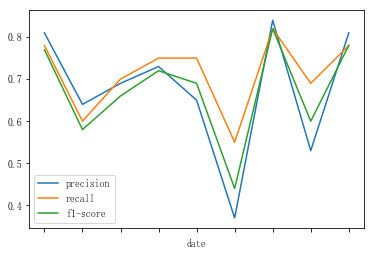

In [22]:
PR_plot_data[PR_plot_data['label'] == 'avg/total'][[ 'date', 'precision', 'recall' ,'f1-score']].plot(x = 'date')
PR_plot_data[PR_plot_data['label'] == 'avg/total']

precision                                            
label         产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                          
20180904     0.940  0.690  0.780 0.940 0.690 0.650 0.690 0.860
20180905     0.000  0.430  0.000 0.940 0.000 0.390 0.610 0.000
20180912     0.000  0.490  0.000 0.970 0.000 0.550 0.780 0.000
20180920     0.000  0.600  0.000 0.970 0.810 0.620 0.000 0.000
20180925     0.000  0.580  0.000 0.000 0.810 0.710 0.710 0.930
20181008     0.000  0.440  0.630 0.000 0.000 0.650 0.590 0.000
20181019     0.870  0.740  0.740 0.940 0.930 0.790 0.630 0.930
20181112     0.000  0.600  0.650 0.000 0.000 0.810 0.680 0.000
20181126     0.830  0.570  0.850 0.920 0.790 0.660 0.680 0.930

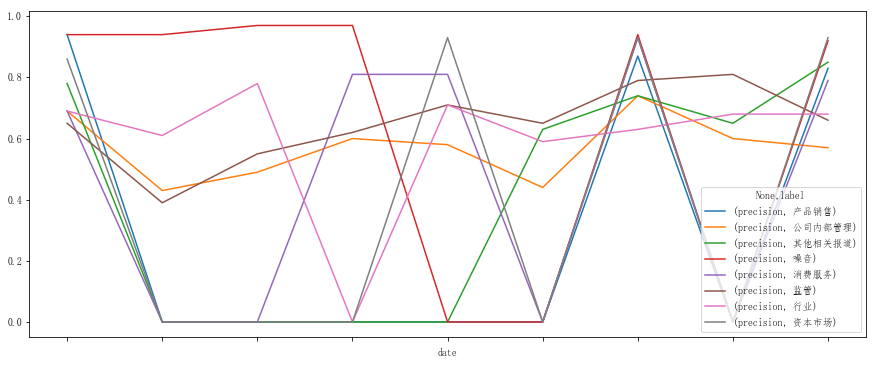

In [23]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'precision']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

recall                                            
label      产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                       
20180904  0.890  0.840  0.920 0.500 0.820 0.980 0.720 0.920
20180905  0.000  0.770  0.000 0.540 0.000 0.940 0.760 0.000
20180912  0.000  0.900  0.000 0.630 0.000 0.980 0.900 0.000
20180920  0.000  0.980  0.000 0.690 0.900 0.880 0.000 0.000
20180925  0.000  0.920  0.000 0.000 0.800 0.930 0.870 0.970
20181008  0.000  0.910  0.750 0.000 0.000 0.980 0.740 0.000
20181019  0.900  0.790  0.800 0.660 0.780 0.960 0.830 0.950
20181112  0.000  0.790  0.890 0.000 0.000 0.990 0.880 0.000
20181126  0.840  0.910  0.770 0.600 0.650 0.930 0.870 0.950

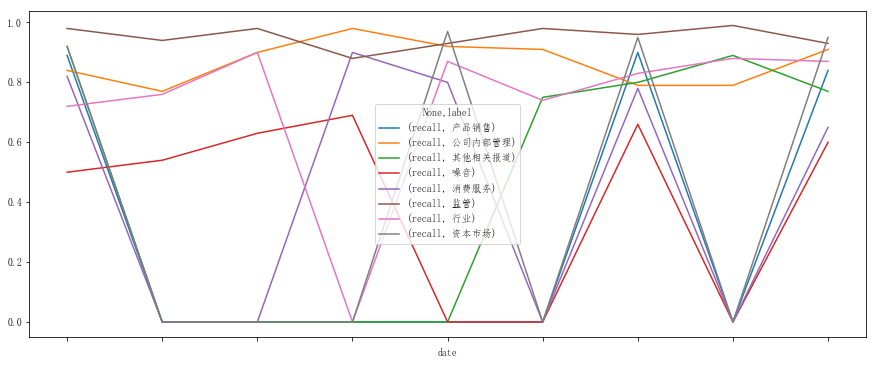

In [24]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'recall']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

f1-score                                            
label        产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                         
20180904    0.920  0.760  0.840 0.650 0.750 0.780 0.710 0.890
20180905    0.000  0.560  0.000 0.680 0.000 0.550 0.680 0.000
20180912    0.000  0.640  0.000 0.760 0.000 0.700 0.840 0.000
20180920    0.000  0.740  0.000 0.800 0.860 0.730 0.000 0.000
20180925    0.000  0.710  0.000 0.000 0.810 0.800 0.780 0.950
20181008    0.000  0.590  0.690 0.000 0.000 0.780 0.660 0.000
20181019    0.880  0.760  0.770 0.780 0.850 0.870 0.720 0.940
20181112    0.000  0.680  0.750 0.000 0.000 0.890 0.760 0.000
20181126    0.830  0.700  0.810 0.720 0.710 0.770 0.760 0.940

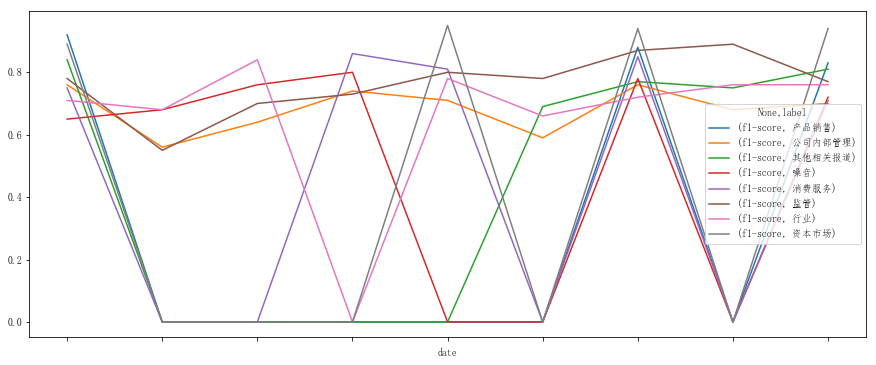

In [26]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'f1-score']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

### 补录与预警数据

In [27]:
file_list_5 = ['20180917_circ_class_feedback.xlsx'
              ] 
add_warn_data = pd.DataFrame()
for file_name in file_list_5:
    currentPath  = '{0}/{1}'.format(folder, file_name)
    excel = xlrd.open_workbook(currentPath)
    sheet_names = [sheet.name for sheet in excel.sheets()]
    for sheet_name in sheet_names:   
        tmp_data = pd.read_excel(currentPath, sheet_name)    
        tmp_data = tmp_data[tmp_data['label'] != '删除']
        add_warn_data = pd.concat([add_warn_data, tmp_data], axis = 0)

circ_raw_class_5 = add_warn_data[['label', 'title', 'content']]

In [28]:
from sklearn import metrics

y_pred_class = add_warn_data['predict_label']
y_test = add_warn_data['label']
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.7766599597585513
             precision    recall  f1-score   support

       产品销售       0.36      0.57      0.44         7
     公司内部管理       0.81      0.79      0.80       104
     其他相关报道       0.50      0.50      0.50         2
         噪音       0.20      0.91      0.33        11
       消费服务       0.97      0.48      0.65        62
         监管       0.88      0.81      0.84        72
         行业       0.87      0.88      0.88       211
       资本市场       0.65      0.54      0.59        28

avg / total       0.84      0.78      0.79       497

confusion_matrix: 
[[  4   0   0   0   0   0   3   0]
 [  0  82   0   3   0   2  13   4]
 [  0   0   1   1   0   0   0   0]
 [  0   0   0  10   0   1   0   0]
 [  2   5   1  18  30   0   6   0]
 [  0   0   0  11   0  58   3   0]
 [  5   6   0   5   1   4 186   4]
 [  0   8   0   2   0   1   2  15]]


In [29]:
circ_raw_class_5['label'].value_counts()

行业        211
公司内部管理    104
监管         72
消费服务       62
资本市场       28
噪音         11
产品销售        7
其他相关报道      2
Name: label, dtype: int64

## 合并数据

In [ ]:
# file_list_4 = ['20181019_circ_class_feedback.xlsx'] # 多个 sheet
# circ_raw_class_4, PR_data, PR_plot_data = get_feedback_data(folder, file_list_4)
# circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
# print('总数：', circ_raw_class_4.shape)
# circ_raw_class_4.head()

In [30]:
circ_raw_class = pd.concat([circ_raw_class_1, circ_raw_class_2,
                          circ_raw_class_3, circ_raw_class_4,
                           circ_raw_class_5], 
                         axis = 0)

# circ_raw_class = circ_raw_class_4
circ_raw_class['title_content'] = circ_raw_class['title'].astype(str) + '。' + circ_raw_class['content'].astype(str)
circ_raw_class['label'] = circ_raw_class['label'].apply(lambda x:x.strip())
circ_raw_class['index'] = range(circ_raw_class.shape[0])
print('去重前： ', circ_raw_class.shape)
circ_raw_class = circ_raw_class.drop_duplicates(subset = 'title_content')
print('去重后： ', circ_raw_class.shape)
circ_raw_class.head()

去重前：  (24724, 5)
去重后：  (24708, 5)


,content,label,title,title_content,index
0,天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:28\n中国保监会网站\n\r当事人：张磊\n\r身份证号码：32021119690412****\n\r职务：天安佰盈保险销售有限公司宁波分公司（以下简称天安销售宁波分公司）主要负责人\n\r住所：宁波市鄞州区会展路128 号9 层9D04-9D12 室\n\r依据《中华人民共和国保险法》（2015 年修正）的有关规定，我局天安销售宁波分公司涉嫌违法一案进行了调查、审理，依法向当事人告知了作出行政处罚的事实、理由、依据以及当事人依法享有的权利。当事人未陈述申辩，未要求听证。\n\r经查，天安销售宁波分公司存在如下违法行为：\n\r一、财务数据不真实\n\r2016 年，天安销售宁波分公司虚列业务招待费92.33 万元，实际用于向员工发放福利。公司主要负责人张磊为对该行为直接负责的主管人员。\n\r二、变更营业场所地址未按规定报告\n\r2016 年8 月，天安销售宁波分公司营业场所地址由江北区庄桥街道北环西路500 号（5）幢二层5-27 室变更为鄞州区会展路128 号9层9D04-9D12 室。截至2017 年10 月24 日，上述事项未按规定向我局书面报告。公司主要负责人张磊为该机构直接负责的主管人员。\n\r上述事实，有财务凭证、租赁合同、营业执照、情况说明、调查笔录、任职文件、现场检查事实确认书等证据证明。\n\r综上，我局作出如下处罚：\n\r一、天安销售宁波分公司财务数据不真实的行为，违反了《中华人民共和国保险法》（2015 年修正）第八十六条和第一百三十二条的规定。根据《中华人民共和国保险法》（2015 年修正）第一百七十一条的规定，给予张磊警告，并处罚款5 万元的行政处罚。\n\r二、天安销售宁波分公司变更营业场所地址未按规定报告的行为，违反了《保险专业代理机构监管规定》第十四条的规定。根据《保险专业代理机构监管规定》第七十条的规定，给予张磊警告，处罚款1万元的行政处罚。\n\r当事人应当在接到本处罚决定书之日起15 日内持缴款码到财政部指定的12 家代理银行中的任一银行进行同行缴款。逾期，将每日按罚款数额的3%加处罚款（缴款码在行政处罚决定书送达时一并告知）。当事人如对本处罚决定不服，可在接到本处罚决定书之日起60 日内依法向中国保监会申请行政复议，...,公司内部管理,天安销售虚列费用为员工发福利 相关负责人被处罚,天安销售虚列费用为员工发福利 相关负责人被处罚。 天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:28\n中国保监会网站\n\r当事人：张磊\n\r身份证号码：32021119690412****\n\r职务：天安佰盈保险销售有限公司宁波分公司（以下简称天安销售宁波分公司）主要负责人\n\r住所：宁波市鄞州区会展路128 号9 层9D04-9D12 室\n\r依据《中华人民共和国保险法》（2015 年修正）的有关规定，我局天安销售宁波分公司涉嫌违法一案进行了调查、审理，依法向当事人告知了作出行政处罚的事实、理由、依据以及当事人依法享有的权利。当事人未陈述申辩，未要求听证。\n\r经查，天安销售宁波分公司存在如下违法行为：\n\r一、财务数据不真实\n\r2016 年，天安销售宁波分公司虚列业务招待费92.33 万元，实际用于向员工发放福利。公司主要负责人张磊为对该行为直接负责的主管人员。\n\r二、变更营业场所地址未按规定报告\n\r2016 年8 月，天安销售宁波分公司营业场所地址由江北区庄桥街道北环西路500 号（5）幢二层5-27 室变更为鄞州区会展路128 号9层9D04-9D12 室。截至2017 年10 月24 日，上述事项未按规定向我局书面报告。公司主要负责人张磊为该机构直接负责的主管人员。\n\r上述事实，有财务凭证、租赁合同、营业执照、情况说明、调查笔录、任职文件、现场检查事实确认书等证据证明。\n\r综上，我局作出如下处罚：\n\r一、天安销售宁波分公司财务数据不真实的行为，违反了《中华人民共和国保险法》（2015 年修正）第八十六条和第一百三十二条的规定。根据《中华人民共和国保险法》（2015 年修正）第一百七十一条的规定，给予张磊警告，并处罚款5 万元的行政处罚。\n\r二、天安销售宁波分公司变更营业场所地址未按规定报告的行为，违反了《保险专业代理机构监管规定》第十四条的规定。根据《保险专业代理机构监管规定》第七十条的规定，给予张磊警告，处罚款1万元的行政处罚。\n\r当事人应当在接到本处罚决定书之日起15 日内持缴款码到财政部指定的12 家代理银行中的任一银行进行同行缴款。逾期，将每日按罚款数额的3%加处罚款（缴款码在行政处罚决定书送达时一并告知）。当事人如对本处罚决定不服，可在接到本处罚决定...,0
1,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局” 求职者遭遇违规增员“陷阱”\n\r 早在2009年，原保监会就下发了《关于加强和完善保险营销员管理工作有关事项的通知》，该《通知》中明令禁止现职保险营销人员单独发布招聘信息\n\r 按照 2009年原保监会下发的《关于加强和完善保险营销员管理工作有关事项的通知》 规定，保险公司现职保险营销人员不得单独发布招聘信息，且各公司不得以混淆保险营销人员的职业性质和职位级别等手段误导社会求职人员盲目加入保险营销队伍 ，但在实际操作中，泰康人寿却有大量保险代理人私自以公司的名义发布招聘信息，且以“人力资源专员/助理”等职业称谓混淆营销人员的职业性质。\n\r 记者调查得知，自2017年12月至2018年3月间，泰康人寿长安支公司多位保险代理人相继以泰康人寿北京分公司人事部的名义招聘数名在校大学生，成为长安支公司营销主管张龙(化名)的人力资源助理。期间这些求职者被泰康人寿长安支公司违规收取培训费，并遭到主管张龙隐瞒薪资待遇和克扣应发薪资等不合理对待。\n\r “骗局”?\n\r 据刘丽称，2017年12月初，泰康人寿长安支公司个险营销服务部保险代理人董霞(化名)通过boss直聘网联系大学生刘丽，想要招聘其为支公司人力资源助理。2018年1月4日，刘丽到北京崇文门哈德门广场3楼见到面试官王婷(化名)，经过面试，王婷向刘丽允诺了 “实习期3500元，转正4000元”的薪资待遇。\n\r 4天后，刘丽入职并接受培训，而后成为主管张龙的助理。培训期间，泰康人寿长安支公司通过向建行自动扣款的方式向刘丽收取了100元“岗前培训费”，但刘丽收到的扣款提示信息却显示，该笔款项是以“泰康人寿保险保险费”的名目被扣除的。实际上，按照《关于进一步加强和完善保险营销员管理工作有关事项的通知》规定，保险公司不应向求职者收取培训费用。\n\r 工作期间，刘丽发现张龙在给其助理发放上一个月的薪资时，以“非满勤出席扣500元，未招满4人工资减半，对应招聘差额每人再减100元”的克扣标准，将该助理原本每月3500元的底薪，克扣到1200元。而这些克扣标准，张龙此前从未告知过刘丽和其他新来的助理。由此，刘丽认为自己遭遇了招聘“骗局”。\n\r 随后，其他新来的助理也知道了薪资标准被故意隐瞒的情况，...,公司内部管理,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元。 泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局” 求职者遭遇违规增员“陷阱”\n\r 早在2009年，原保监会就下发了《关于加强和完善保险营销员管理工作有关事项的通知》，该《通知》中明令禁止现职保险营销人员单独发布招聘信息\n\r 按照 2009年原保监会下发的《关于加强和完善保险营销员管理工作有关事项的通知》 规定，保险公司现职保险营销人员不得单独发布招聘信息，且各公司不得以混淆保险营销人员的职业性质和职位级别等手段误导社会求职人员盲目加入保险营销队伍 ，但在实际操作中，泰康人寿却有大量保险代理人私自以公司的名义发布招聘信息，且以“人力资源专员/助理”等职业称谓混淆营销人员的职业性质。\n\r 记者调查得知，自2017年12月至2018年3月间，泰康人寿长安支公司多位保险代理人相继以泰康人寿北京分公司人事部的名义招聘数名在校大学生，成为长安支公司营销主管张龙(化名)的人力资源助理。期间这些求职者被泰康人寿长安支公司违规收取培训费，并遭到主管张龙隐瞒薪资待遇和克扣应发薪资等不合理对待。\n\r “骗局”?\n\r 据刘丽称，2017年12月初，泰康人寿长安支公司个险营销服务部保险代理人董霞(化名)通过boss直聘网联系大学生刘丽，想要招聘其为支公司人力资源助理。2018年1月4日，刘丽到北京崇文门哈德门广场3楼见到面试官王婷(化名)，经过面试，王婷向刘丽允诺了 “实习期3500元，转正4000元”的薪资待遇。\n\r 4天后，刘丽入职并接受培训，而后成为主管张龙的助理。培训期间，泰康人寿长安支公司通过向建行自动扣款的方式向刘丽收取了100元“岗前培训费”，但刘丽收到的扣款提示信息却显示，该笔款项是以“泰康人寿保险保险费”的名目被扣除的。实际上，按照《关于进一步加强和完善保险营销员管理工作有关事项的通知》规定，保险公司不应向求职者收取培训费用。\n\r 工作期间，刘丽发现张龙在给其助理发放上一个月的薪资时，以“非满勤出席扣500元，未招满4人工资减半，对应招聘差额每人再减1

In [31]:
print(circ_raw_class.shape)
circ_raw_class.groupby('label')['title'].count()

(24708, 5)


label
产品销售      1364
公司内部管理    3156
其他相关报道    2454
噪音        6501
消费服务      2878
监管        3094
行业        3367
资本市场      1894
Name: title, dtype: int64

In [32]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%S:%M")
circ_raw_class_num = circ_raw_class.groupby('label')['title'].count().reset_index()
circ_raw_class_num.columns = ['label', 'num']
tmp_num = pd.DataFrame([['日期：', now],
                        ['总量', circ_raw_class_num['num'].sum(axis = 0)]],
                      columns = ['label', 'num'])
circ_raw_class_num = pd.concat([tmp_num, circ_raw_class_num])
circ_raw_class_num.T.to_csv('statistics_result/CIRC_class_data_num.csv', index = False, mode = 'a', encoding = 'utf-8')
circ_raw_class_num.T

,0,1,0,1,2,3,4,5,6,7
label,日期：,总量,产品销售,公司内部管理,其他相关报道,噪音,消费服务,监管,行业,资本市场
num,2018-11-28 15:07:53,24708,1364,3156,2454,6501,2878,3094,3367,1894


## 预处理

In [ ]:
save_folder = 'circ_result_class/'
pre_save(pre_cor_circ.handle_contents, circ_raw_class, save_folder)

# 保险业--中国人保：1 十分类

## 读取数据

In [33]:
folder = 'circ_data_class/20180910'

### 预测正确数据

In [34]:
file_list_1 = ['circ_class_sel_else_20180827.xlsx',]
circ_raw_class_1 = predict_right(folder, file_list_1)

circ_raw_class_1['label'] = circ_raw_class_1['label'].apply(lambda x:x.strip())    
circ_raw_class_1 = circ_raw_class_1[['label', 'raw_title', 'raw_content']]
circ_raw_class_1.columns = ['label', 'title', 'content']
print('总数：', circ_raw_class_1.shape)
circ_raw_class_1.head()

去空值前：  (1284, 8) circ_class_sel_else_20180827.xlsx 公司内部管理
去空值前：  (3197, 8) circ_class_sel_else_20180827.xlsx 噪音
去空值前：  (1320, 8) circ_class_sel_else_20180827.xlsx 行业
去空值前：  (1463, 8) circ_class_sel_else_20180827.xlsx 消费服务
去空值前：  (753, 8) circ_class_sel_else_20180827.xlsx 资本市场
去空值前：  (1511, 8) circ_class_sel_else_20180827.xlsx 监管
去空值前：  (500, 8) circ_class_sel_else_20180827.xlsx 产品销售
去空值前：  (1403, 8) circ_class_sel_else_20180827.xlsx 其他相关报道
总数： (11431, 3)


,label,title,content
0,公司内部管理,天安销售虚列费用为员工发福利 相关负责人被处罚,天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:28\n中国保监会网站\n\r当事人：张磊\n\r身份证号码：32021119690412****\n\r职务：天安佰盈保险销售有限公司宁波分公司（以下简称天安销售宁波分公司）主要负责人\n\r住所：宁波市鄞州区会展路128 号9 层9D04-9D12 室\n\r依据《中华人民共和国保险法》（2015 年修正）的有关规定，我局天安销售宁波分公司涉嫌违法一案进行了调查、审理，依法向当事人告知了作出行政处罚的事实、理由、依据以及当事人依法享有的权利。当事人未陈述申辩，未要求听证。\n\r经查，天安销售宁波分公司存在如下违法行为：\n\r一、财务数据不真实\n\r2016 年，天安销售宁波分公司虚列业务招待费92.33 万元，实际用于向员工发放福利。公司主要负责人张磊为对该行为直接负责的主管人员。\n\r二、变更营业场所地址未按规定报告\n\r2016 年8 月，天安销售宁波分公司营业场所地址由江北区庄桥街道北环西路500 号（5）幢二层5-27 室变更为鄞州区会展路128 号9层9D04-9D12 室。截至2017 年10 月24 日，上述事项未按规定向我局书面报告。公司主要负责人张磊为该机构直接负责的主管人员。\n\r上述事实，有财务凭证、租赁合同、营业执照、情况说明、调查笔录、任职文件、现场检查事实确认书等证据证明。\n\r综上，我局作出如下处罚：\n\r一、天安销售宁波分公司财务数据不真实的行为，违反了《中华人民共和国保险法》（2015 年修正）第八十六条和第一百三十二条的规定。根据《中华人民共和国保险法》（2015 年修正）第一百七十一条的规定，给予张磊警告，并处罚款5 万元的行政处罚。\n\r二、天安销售宁波分公司变更营业场所地址未按规定报告的行为，违反了《保险专业代理机构监管规定》第十四条的规定。根据《保险专业代理机构监管规定》第七十条的规定，给予张磊警告，处罚款1万元的行政处罚。\n\r当事人应当在接到本处罚决定书之日起15 日内持缴款码到财政部指定的12 家代理银行中的任一银行进行同行缴款。逾期，将每日按罚款数额的3%加处罚款（缴款码在行政处罚决定书送达时一并告知）。当事人如对本处罚决定不服，可在接到本处罚决定书之日起60 日内依法向中国保监会申请行政复议，...
1,公司内部管理,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局” 求职者遭遇违规增员“陷阱”\n\r 早在2009年，原保监会就下发了《关于加强和完善保险营销员管理工作有关事项的通知》，该《通知》中明令禁止现职保险营销人员单独发布招聘信息\n\r 按照 2009年原保监会下发的《关于加强和完善保险营销员管理工作有关事项的通知》 规定，保险公司现职保险营销人员不得单独发布招聘信息，且各公司不得以混淆保险营销人员的职业性质和职位级别等手段误导社会求职人员盲目加入保险营销队伍 ，但在实际操作中，泰康人寿却有大量保险代理人私自以公司的名义发布招聘信息，且以“人力资源专员/助理”等职业称谓混淆营销人员的职业性质。\n\r 记者调查得知，自2017年12月至2018年3月间，泰康人寿长安支公司多位保险代理人相继以泰康人寿北京分公司人事部的名义招聘数名在校大学生，成为长安支公司营销主管张龙(化名)的人力资源助理。期间这些求职者被泰康人寿长安支公司违规收取培训费，并遭到主管张龙隐瞒薪资待遇和克扣应发薪资等不合理对待。\n\r “骗局”?\n\r 据刘丽称，2017年12月初，泰康人寿长安支公司个险营销服务部保险代理人董霞(化名)通过boss直聘网联系大学生刘丽，想要招聘其为支公司人力资源助理。2018年1月4日，刘丽到北京崇文门哈德门广场3楼见到面试官王婷(化名)，经过面试，王婷向刘丽允诺了 “实习期3500元，转正4000元”的薪资待遇。\n\r 4天后，刘丽入职并接受培训，而后成为主管张龙的助理。培训期间，泰康人寿长安支公司通过向建行自动扣款的方式向刘丽收取了100元“岗前培训费”，但刘丽收到的扣款提示信息却显示，该笔款项是以“泰康人寿保险保险费”的名目被扣除的。实际上，按照《关于进一步加强和完善保险营销员管理工作有关事项的通知》规定，保险公司不应向求职者收取培训费用。\n\r 工作期间，刘丽发现张龙在给其助理发放上一个月的薪资时，以“非满勤出席扣500元，未招满4人工资减半，对应招聘差额每人再减100元”的克扣标准，将该助理原本每月3500元的底薪，克扣到1200元。而这些克扣标准，张龙此前从未告知过刘丽和其他新来的助理。由此，刘丽认为自己遭遇了招聘“骗局”。\n\r 随后，其他新来的助理也知道了薪资标准被故意隐瞒的情况，...
2,公司内部管理,上海人寿整改应对监管 万能险收紧后仍过保费半数,上海人寿屡被监管关照 万能险收紧后仍占半壁江山\n\r(图片)\n\r投资时报\n\r01月09日\n\r13:43\n\r关注\n\r确定不再关注此人吗\n\r确定\n\r取消\n\r屡被“关照”上海人寿应对整改 万能险收紧后仍过保费半数 | 保险监管风云录\n\r文 | 标点财经研究员 黄凤清\n\r成立未满三年的上海人寿，已屡次成为监管层的关照对象。继2016年因万能险问题成为被中国保监会要求整改的9家保险公司之一后，2017年第四季度，上海人寿又一次接到保监会的监管函。\n\r《投资时报》在对2017年保监会出具的37张监管函进行统计和回顾，并推出《保险监管风云录》专题报道时注意到，上海人寿的案例颇值得研究。\n\r10月11日，保监会公布了针对上海人寿保险股份有限公司的监管函，指出于2017年3月9日至4月15日对该公司进行了公司治理现场评估，查实该公司在“三会一层”运作、关联交易、内部审计、考核激励等方面存在问题。具体来看有六大违规问题，在公司治理运作方面，包括董事会运作不规范、独立董事制度缺失及管理不规范、高级管理人员免职未按时报备；在内部管控方面，包括关联交易管理不规范、薪酬管理不合规、内部审计管理不到位。\n\r针对上述问题，保监会提出了具体的监管要求，包括要求上海人寿在接到监管函后立即实施整改工作，成立由主要负责人牵头的专项工作组，制定切实可行的整改方案；按照整改方案对评估发现的问题逐项整改，形成整改报告，并于2017年11月30日前书面报至保监会；自监管函下发之日起六个月内禁止该公司直接或间接与览海控股（集团）有限公司及其关联方开展下列交易：提供借款或其他形式的财务资助、除存量关联交易的终止行为（如到期、赎回、转让等）以外开展资金运用类关联交易（包括现有金融产品的续期，以及已经签署协议但未实际支付的交易），上述六个月期满之日起三个月为观察期，观察期内保监会将对此项监管措施的落实情况进行检查，视情况采取后续监管措施等。\n\r其中，览海控股（集团）有限公司为上海人寿的第一大股东，至2017年三季度末持股比例为20%。\n\r对于保监会此次下发的监管函，上海人寿对《投资时报》表示，公司已在第一时间成立了以董事长为组长、总裁和董事会秘书为副组长的公司治理整改专项小组，研究制定具体的整改措施，部分问题已经完成整改，如进一步完善了面向董事的信...
3,公司内部管理,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度\n\r0\n\r缩小文字\n\r放大文字\n\r2018-01-12\n\r来源：\n上海证券报\n·\n要闻\n\r “侨兴债”事件继续发酵，浙商财险9位高管被问责\n\r 保监会加大“双罚制”执行力度\n\r ⊙记者 陈婷婷 ○编辑 陈羽\n\r “侨兴债”风险事件在保险业继续发酵。除了此前的行业警示之外，昨日，保监会又向卷入“侨兴债”风险事件的浙商财险开出罚单，曝出该公司五大问题，涉及业务、人员聘任、内控管理等多个方面。而被罚款202万元、停止接受保证保险新业务1年的处罚对浙商财险乃至保险全行业都敲响了警钟。\n\r 机构受处罚，相关责任人也不能逃脱干系。罚单对相关负责人进行责任追溯，浙商财险9位高管被问责，时任总经理被撤职。事实上，从去年开始，保监会及各地保监局频频下发的行政处罚就告别了重机构轻高管的处罚惯例。11日，一同下发的另外三张罚单便是针对三家险企的总精算师。未来，对主要责任人与机构“双罚”将成常态。\n\r 罚单直指浙商财险内控漏洞\n\r 上证报记者此前统计，去年全国各地保险监管机构下发行政处罚决定书超过850张，创下近年来保险业罚单新纪录。\n\r 新年伊始，监管的处罚力度丝毫没有减弱。昨日，保监会再次开出新年首批四张罚单，分别针对浙商财险、农银人寿、长城人寿和交银康联人寿。\n\r 其中，浙商财险因涉及侨兴债，被罚202万元、信用保证保险业务被停一年而受市场关注。保监会介绍，2014年浙商财险承保两笔保证保险业务，保额均为5.73亿元。根据浙商财险2014年度资产负债表，单一风险单位即每笔私募债占比超过《保险法》规定实有资本金加公积金总和的10%。同时，浙商财险未按照规定使用经批准或者备案的保险条款、保险费率未按规定提取准备金，也是在承保侨兴债过程中暴露出的风险治理漏洞。\n\r 保监会近日在行业内部下发《浙商财险侨兴私募债保证保险业务风险事件分析及启示》

In [35]:
circ_raw_class_1['label'].value_counts()

噪音        3197
监管        1511
消费服务      1463
其他相关报道    1403
行业        1320
公司内部管理    1284
资本市场       753
产品销售       500
Name: label, dtype: int64

### 预测错误修正后数据

In [36]:
file_list_2 = ['circ_class_sel_20180827-1.xlsx','circ_class_sel_20180827-2.xlsx']

circ_raw_class_2 = correct_wrong_data(folder, file_list_2)
circ_raw_class_2['label'] = circ_raw_class_2['label'].apply(lambda x:x.strip())  
circ_raw_class_2 = circ_raw_class_2[['备注', 'raw_title', 'raw_content']]
circ_raw_class_2.columns = ['label', 'title', 'content']
print('总数：', circ_raw_class_2.shape)
circ_raw_class_2.head()

去删除前：  (394, 8) circ_class_sel_20180827-1.xlsx 公司内部管理
去删除后：  (390, 8) circ_class_sel_20180827-1.xlsx 公司内部管理
人工误判率： 0.27 算法误判率： 0.47

去删除前：  (193, 8) circ_class_sel_20180827-1.xlsx 资本市场
去删除后：  (190, 8) circ_class_sel_20180827-1.xlsx 资本市场
人工误判率： 0.24 算法误判率： 0.48

去删除前：  (405, 8) circ_class_sel_20180827-1.xlsx 行业
去删除后：  (397, 8) circ_class_sel_20180827-1.xlsx 行业
人工误判率： 0.27 算法误判率： 0.53

去删除前：  (385, 8) circ_class_sel_20180827-1.xlsx 监管
去删除后：  (381, 8) circ_class_sel_20180827-1.xlsx 监管
人工误判率： 0.12 算法误判率： 0.75

去删除前：  (230, 8) circ_class_sel_20180827-2.xlsx 消费服务
去删除后：  (228, 8) circ_class_sel_20180827-2.xlsx 消费服务
人工误判率： 0.12 算法误判率： 0.71

去删除前：  (486, 8) circ_class_sel_20180827-2.xlsx 噪音
去删除后：  (469, 8) circ_class_sel_20180827-2.xlsx 噪音
人工误判率： 0.18 算法误判率： 0.65

去删除前：  (188, 8) circ_class_sel_20180827-2.xlsx 其他相关报道
去删除后：  (184, 8) circ_class_sel_20180827-2.xlsx 其他相关报道
人工误判率： 0.14 算法误判率： 0.65

去删除前：  (144, 8) circ_class_sel_20180827-2.xlsx 产品销售
去删除后：  (141, 8) circ_class_sel_20180827-2.xlsx 产品

,label,title,content
0,公司内部管理,太平人寿2016年原保费收入接近千亿大关,"太平人寿2016年原保费收入接近千亿大关\n\r(图片) \n财经头条 1年前\n\r记者19日获悉，持续践行中国太平集团“精品”发展战略的太平人寿，在2016年依然保持了稳健的发展态势。太平人寿2016年原保险保费收入直逼千亿大关，达到943.64亿元，较2015年同期增长18.1%。总体来说，太平人寿2016年全面超额完成各项业务指标，更实现了规模、价值的双增长，新业务价值保持稳步增长。\n\r#该摘要由财秘智能技术提供\n\r记者19日获悉，持续践行中国太平集团“精品”发展战略的太平人寿，在2016年依然保持了稳健的发展态势。太平人寿2016年原保险保费收入直逼千亿大关，达到943.64亿元，较2015年同期增长18.1%。\n\r 总体来说，太平人寿2016年全面超额完成各项业务指标，更实现了规模、价值的双增长，新业务价值保持稳步增长。\n\r 更难得的是，在保费规模不断扩大的同时，太平人寿业务品质始终保持行业领先地位，个险、银保13月继续率、25月继续率均超过90%，四项继续率指标之和超过380%，凸显出太平人寿业务的健康、稳健和后劲足。\n\r猜你喜欢\n\r太平人寿上半年原保险保费收入突破800亿元\n\r(图片)\n\r2017年原保险保费收入36581亿\n\r(图片)\n\r综合征税还有很长的路要走\n\r(图片)\n\r京东4.83亿参股安联财险 互联网+保险再迎风口\n\r(图片)\n\r当重疾来敲门，有人选择用银行卡余额治病，有人选择用保单保额，结果可大不同\n\r(图片)\n\r京东保险棋局落下重要一子 入股安联财险跻身二股东\n\r(图片)\n\r京东终于拿下保险牌照 4.83亿入股安联\n\r(图片)\n\r京东4.83亿元入股安联财险拿下保险牌照 持股30%\n\r(图片)\n\r-已经到底了-\n""}}"
1,公司内部管理,经过一年半时间的筹建 首家科技保险公司正式开业,"现在是科技时代，在我们日常生活中，处处都离不开现代科技，比如快捷付款之类。但最近保险科技最近成了一个热词，并且科技改变保险的同时，保险对科技的专项服务也拉开了序幕。1月9日，经保监会同意，经过一年半左右时间的筹建，中国太平保险集团旗下太平科技保险公司正式开业，这也是国内首家专业的科技保险公司。\n""}}"
2,公司内部管理,安心财险“闲时退费”产品违反车险条款,近日，中国保监会对安心财险发布的监管函显示，安心财险“闲时退费”产品被定性为违反车险条款规定，同时要求安心财险对公司高管管理和车险业务进行全面自查，排查违规问题和风险隐患，加强内部管控，严格制度执行，依法开展经营，杜绝类似问题再次发生。 “闲时退费”也就是说“按天买车险”，产品创意借鉴于国外的UBI车险（驾驶行为模式基础保险）。据悉，“闲时退费”产品由安心财险承保，第三方互联网保险平台车车车险联合设计运营，其核心内容可概括为开一天车交一天车险，车主在不用车的时候，比如出差、限号、送修等场景，可以在手机客户端操作退还保费。 对此，有市场分析认为，由于UBI车险的核心在于数据收集，而国内车联网技术尚不够成熟，数据收集设备（如OBD设备）的普及以及数据的传输方式均没有得到较好的解决，因此在没有实现物联网的情况下，要真正实现 闲时退费 的可能性不大。 值得注意的是，“按天买车险”产品模式并不只有安心财险一家在做，此前市面上也有一些车险产品是按照车辆实际使用天数及里程数收取保费，不过目前已经下线。事实上，早在今年三月份，中国保险行业协会针对该类型车险模式就下发过风险提示，提醒广大车险消费者在购买保险时，提高风险意识，保护自身合法权益。 （见习编辑：陈蓉蓉） 值得注意的是，“按天买车险”产品模式并不只有安心财险一家在做，此前市面上也有一些车险产品是按照车辆实际使用天数及里程数收取保费，不过目前已经下线。事实上，早在今年三月份，中国保险行业协会针对该类型车险模式就下发过风险提示，提醒广大车险消费者在购买保险时，提高风险意识，保护自身合法权益。 （见习编辑：陈蓉蓉）
3,公司内部管理,上海人寿保险被保监会出具监管函 指其六方面违规,原标题：上海人寿保险被保监会出具监管函 指其六方面违规 千龙网北京10月11日讯 10月11日晚间，中国保监会发布监管函〔2017〕32号文件，指出上海人寿保险股份有限公司在“三会一层”运作、关联交易、内部审计、考核激励等方面存在问题。 资料图。 文件指出，2017年3月9日至4月15日，保监会对上海人寿保险股份有限公司进行了公司治理现场评估，发现上海人寿保险存在董事会运作不规范、独立董事制度缺失，管理不规范、高级管理人员免职未按时报备、关联交易管理不规范、薪酬管理不合规、内部审计管理不到位等六方面问题。 上述问题分别违反了《保险公司董事会运作指引》第二十五条、第三十条、第三十九条、第四十二条、第五十三条、第六十二条、第七十四条、第七十七条和《保险机构内部审计工作规范》第十六条规定、《关于规范保险公司治理结构的指导意见（试行）》相关规定、《保险公司独立董事管理暂行办法》第三十条以及《保险公司董事会运作指引》第二十一条规定、《保险公司董事、监事和高级管理人员任职资格管理规定》第三十三条规定、《保险公司关联交易管理暂行办法》第十三条规定、《保险公司关联交易管理暂行办法》第二十二条等有关规定、《保险公司薪酬管理规范指引（试行）》第十二条、第十三条规定、《保险公司董事及高级管理人员审计管理办法》第二条、第九条规定。 保监会对上海人寿保险股份有限公司提出四项监管要求。第一，应当高度重视公司治理评估发现的问题，在接到本监管函后立即实施整改工作，成立由主要负责人牵头的专项工作组，制定切实可行的整改方案。整改方案应当明确具体时间和措施，确保将每一项问题的整改工作落实到具体部门和责任人。 第二、应当依据相关法律法规、监管规定和公司内控制度的有关要求，按照整改方案，对评估发现的问题逐项整改，形成整改报告，并于2017年11月30日前书面报至我会。已经整改完成的，列明整改完成时间及具体措施；尚未完成的，列明整改时限及具体方案。 第三、自本监管函下发之日起六个月内，禁止上海人寿保险直接或间接与览海控股（集团）有限公司及其关联方开展下列交易：1.提供借款或其他形式的财务资助；2.除存量关联交易的终止行为（如到期、赎回、转让等）以外，开展资金运用类关联交易（包括现有金融产品的续期，以及已经签署协议但未实际支付的交易）。上述六个月期满之日起三个月为观察期。观察期内，保...
4,公司内部管理,中国太平2018年一季度保费收入624.7亿元,4月13日，中国太平保险控股(股份代码：HK00966)公布2018年一季度保费收入。中国太平控股附属太平人寿、太平财险及太平养老首季累计保费收入总计共624.6592亿元人民币(下同)。其中，太平人寿、太平财险、太平养老2018年一季度累计保费收入分别为546.0831亿元、61.4433亿元及17.1328亿元。(太平人寿)


In [37]:
circ_raw_class_2['label'].value_counts()

行业        491
公司内部管理    465
噪音        427
监管        254
产品销售      221
资本市场      215
其他相关报道    180
消费服务      127
Name: label, dtype: int64

### 新补充数据

In [38]:
file_list_3 = ['20180827_circ_class_1.xlsx'
               ] # 多个 sheet

circ_raw_class_3 = get_new_data(folder, file_list_3)

circ_raw_class_3['label'] = circ_raw_class_3['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_class_3.shape)
circ_raw_class_3.head()

Index(['title', 'content', 'label'], dtype='object')
去空值前：  (319, 3) 20180827_circ_class_1.xlsx 社会医疗保险
去空值后：  (319, 3) 20180827_circ_class_1.xlsx 社会医疗保险
总数： (319, 3)


,label,title,content
0,噪音,为什么医疗保险每年在加费用呢？相等的报销会增加吗？,为什么医疗保险每年在加费用呢？相等的报销会增加吗？ 待解决 匿名 问题与我的不同！ 我要立即提问 尊敬的用户请先登录后解答该咨询。 登录 | 注册 找法网认证系统 温馨提示：只有认证通过的律师才能回复咨询。 确定 律师回答 共 1 条 王文元 律师 13329126339 免费咨询 由国家的医疗保险政策确定。 律所：安徽宪达律师事务所 回复时间：2017-10-03 15:49 0 检举 评论(0) 医疗保险 更多交通事故问题>> 医疗:保险 交通事故相关词条： 交通费用能用定额发票报吗交通费赔偿标准是什么如何计算交通事故的交通费赔偿 遇到医疗保险问题您可以尝试： 1 根据您遇到的问题找一个专业律师 车祸赔偿取保候审交通事故赔偿酒驾醉驾交通肇事侵权赔偿刑事附带民事人身损害赔偿财产损害赔偿工伤索赔 2 根据您遇到的问题看相关法律知识 医疗保险概述医保报销范围社会医疗保险商业医疗保险农村医疗保险城镇职工医保 法律咨询 不用注册，快速回复，马上在线咨询专业律师！ * 标题 0/50 * 详细 您的问题描述越详细，律师回答越及时越准确~ 0/2000 地区： 请选择 请选择 请选择 分类： 未分类 悬赏5 悬赏5 悬赏10 悬赏15 悬赏20 服务： 律师回复后短信通知我（需绑定手机） 绑定手机号 律师回复后我们将第一时间发送短信通知您！ 获取验证码 确定 可以使用此号码登录找法网及找回密码 请输入以下的验证码继续提交 确定
1,噪音,临沂人注意了！有人看病多花好几万！只因不知道医疗保险的这一方面！,原标题:临沂人注意了！有人看病多花好几万！只因不知道医疗保险的这一方面！ 古语说得好 没什么别没钱，有什么别有病，即使你有医保卡。 近日，一位网友遇到了一件怪事： 自己交了这么多年的医保， 怎么忽然就不能用了？ 还听说停缴3个月余额会清零？ 原来，这位网友已从原单位辞职一个月， 这一个月并没有缴纳当月社保， 才会发生这样的情况。 但是，关于停缴3个月余额清零一说， 就纯属无稽之谈了！ 那么关于社保停缴， 都会对我们的生活造成哪些影响呢？ 且听小编为你细细梳理。 1 医保账户 社保医保由单位和个人共同缴纳。 个人缴纳月工资总额的2%，进入个人账户，用于买药、门诊、小额医疗费用的支付； 单位交5% 7%，进入社会统筹账户，用于住院花费的报销。 医保停缴的次月起，社保卡内的金额会被封存，但依然属于个人所有，不过不能直接划卡使用，就是说，钱还在，只是不能花，也不能支取。 但是以下三种情况下，个人账户里的钱可以支取使用 社保卡使用终止：如参保人死亡，亲属可凭死亡证明等办理支取手续。 参保人移民：凭公安部门出具的证明等办理支取手续。 异地转移：在当地参保后，可把医保账户余额转移至新账户。 2 停缴医保，影响连续缴费年限 医疗保险自停缴之日起有3个月缓冲期。 如果只是3个月内中断医保缴费，那么在继续缴费的时候还可以算连续参保时间；但是如果超过了3个月，那么连续缴费年限就会清零，续缴时从零开始计算连续缴费年限。 也就是说，网友遇到的清零，是连续缴费年限，而不是余额。 3 连续缴费年限，影响重大方面 第一 影响大病门诊待遇 享受大病门诊待遇的小伙伴，在治病中产生的基本医疗费用和地方补充医疗费用，都是可以报销的，不过报销比例跟连续参保的时间有关。 举个例子： 某人生病时费用花了20000元。 原来参加了36个月以上的医保，那么报销比例为90%，可以报销18000元； 但是如果有一天断掉了，缴费年限清零，那么报销比例就成了60%，只能报销12000元。 一下就多花了6000块！ 第二 影响基本医保统筹基金支付额度 每...
2,噪音,如何计算医疗保险个人账户中每月可以进账多少钱？,除了公积金这个小金库，我们还有一个医疗保险每月可以进账，医疗保险中的个人账户可以用来看病买药，北京天津地区的则可以取现，也算是除了固定工资外的一笔小收入。 医疗保险分为个人账户和统筹账户，个人账户中的钱归参保人所有，在看病或买药的时候可以用社保卡支付医药费，统筹账户中的钱划入医保统筹基金中，只能用于看病报销。也就是说，我们能自由支配的钱就是个人账户中的这部分。那么，怎么知道自己每月有多少医疗保险金进账供自己支配呢。 医疗保险个人账户中的钱和公积金一样，分为个人缴纳和单位缴纳，其中个人缴纳的医疗保险全部归入个人账户，单位缴纳的医疗保险的一部分划入个人账户，两部分加起来就是每月医疗保险的进账额度。 单位缴纳的医疗保险可以划入个人账户的比例为：不满35周岁0.8%，35周岁以上不满45周岁1%，45周岁以上2%，此外，不满70周岁的退休人员按上一年本市职工平均工资的4.3%划入个人账户，70周岁以上的退休人员按上一年本市职工平均工资的4.8%划入个人账户。 具体来说，如果你今年30岁，在北京工作，每月税前工资1万，那么你每个月的医疗保险个人账户中有10000*（2%+0.8%）=280元。其中，2％是每个地区医疗保险个人缴纳比例的规定，个人缴纳的医疗保险全部归入个人账户。 如果您有贷款疑问，欢迎上家财管加微信公众号（jiacaiguanjia）咨询，有专业的信贷高级顾问随时为您解答！
3,噪音,医疗保险是否跟贫困补助有关联,医疗保险是否跟贫困补助有关联 待解决 匿名 问题与我的不同！ 我要立即提问 尊敬的用户请先登录后解答该咨询。 登录 | 注册 找法网认证系统 温馨提示：只有认证通过的律师才能回复咨询。 确定 律师回答 共 1 条 蔡亚 律师 15812137587 免费咨询 不属于法律问题，请咨询相关部门 律所：云南民定律师事务所 回复时间：2017-10-09 19:44 0 检举 评论(0) 医疗保险 更多劳动工伤问题>> 医疗:保险 劳动工伤相关词条： 连续工作满12个月以上可享受带薪年休假劳动保障监察条例（最新全文）最低工资法律如何规定 遇到医疗保险问题您可以尝试： 1 根据您遇到的问题找一个专业律师 公司税务合同个人税收筹划未成年人犯罪群体劳资纠纷劳动纠纷劳务派遣调岗降职降薪劳动合同劳动仲裁无故辞退社会保险讨薪 2 根据您遇到的问题看相关法律知识 医疗保险概述医保报销范围社会医疗保险商业医疗保险农村医疗保险城镇职工医保 法律咨询 不用注册，快速回复，马上在线咨询专业律师！ * 标题 0/50 * 详细 您的问题描述越详细，律师回答越及时越准确~ 0/2000 地区： 请选择 请选择 请选择 分类： 未分类 悬赏5 悬赏5 悬赏10 悬赏15 悬赏20 服务： 律师回复后短信通知我（需绑定手机） 绑定手机号 律师回复后我们将第一时间发送短信通知您！ 获取验证码 确定 可以使用此号码登录找法网及找回密码 请输入以下的验证码继续提交 确定
4,噪音,这事受理了|农村合作医疗保险哪些群体可以减免费用,原标题:这事受理了|农村合作医疗保险哪些群体可以减免费用 有拍友反映： 请问一下有关部门？忻府区农村合作医疗保险哪些群体不需缴纳且免费享有。是如同网上说的低保户、贫困户、独生子女户和残疾人等都不用缴纳吗？请予以答复。 【老牛舐犊】东汉末年，曹操进攻刘备，在斜谷界口驻扎，陷于进退两难境地，部将夏侯淳询问夜间口令，曹操随口说鸡肋。杨修认为是曹操退兵的意思，叫士兵打点行装，曹操借口杀了杨修。后见到骨瘦如柴的杨修父亲杨彪，问为何？杨彪说有舐犊之爱。 【典故】愧无日磾先见之明，犹怀老牛舐犊之爱。 《后汉书 杨彪传》 【释义】舐：舔；犊：小牛。老牛舔小牛。比喻父母疼爱子女。 【用法】作主语、宾语；指父母怜爱子女


In [39]:
circ_raw_class_3['label'].value_counts()

噪音    319
Name: label, dtype: int64

### 模型预测后反馈数据

In [40]:
file_list_4 = ['20180904_circ_class_feedback.xlsx', '20180905_circ_class_feedback.xlsx',
               '20180912_circ_class_feedback.xlsx','20180920_circ_class_feedback.xlsx',
               '20180925_circ_class_feedback.xlsx', '20181008_circ_class_feedback.xlsx',
               '20181019_circ_class_feedback.xlsx', '20181112_circ_class_feedback.xlsx',
               '20181126_circ_class_feedback.xlsx'
              ] # 多个 sheet

circ_raw_class_4, PR_data, PR_plot_data = get_feedback_data(folder, file_list_4, 'predict_label')

circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_class_4.shape)
circ_raw_class_4.head()

  ----     20180904_circ_class_feedback.xlsx
类别： 噪音 总数： 200 正确数 187 正确比例 0.935
去空值前：  (200, 5) 20180904_circ_class_feedback.xlsx 噪音
去空值后：  (200, 5) 20180904_circ_class_feedback.xlsx 噪音

类别： 消费服务 总数： 198 正确数 137 正确比例 0.6919191919191919
去空值前：  (198, 5) 20180904_circ_class_feedback.xlsx 消费服务
去空值后：  (198, 5) 20180904_circ_class_feedback.xlsx 消费服务

类别： 产品销售 总数： 194 正确数 183 正确比例 0.9432989690721649
去空值前：  (194, 5) 20180904_circ_class_feedback.xlsx 产品销售
去空值后：  (194, 5) 20180904_circ_class_feedback.xlsx 产品销售

类别： 其他相关报道 总数： 200 正确数 155 正确比例 0.775
去空值前：  (200, 5) 20180904_circ_class_feedback.xlsx 其他相关报道
去空值后：  (200, 5) 20180904_circ_class_feedback.xlsx 其他相关报道

类别： 监管 总数： 198 正确数 128 正确比例 0.6464646464646465
去空值前：  (198, 5) 20180904_circ_class_feedback.xlsx 监管
去空值后：  (198, 5) 20180904_circ_class_feedback.xlsx 监管

类别： 行业 总数： 198 正确数 137 正确比例 0.6919191919191919
去空值前：  (198, 5) 20180904_circ_class_feedback.xlsx 行业
去空值后：  (198, 5) 20180904_circ_class_feedback.xlsx 行业

类别： 资本市场 总数： 199 正确数 171 正确比例 0.8

类别： 监管 总数： 195 正确数 126 正确比例 0.6461538461538462
去空值前：  (195, 5) 20181008_circ_class_feedback.xlsx 监管
去空值后：  (195, 5) 20181008_circ_class_feedback.xlsx 监管

类别： 行业 总数： 171 正确数 101 正确比例 0.5906432748538012
去空值前：  (171, 5) 20181008_circ_class_feedback.xlsx 行业
去空值后：  (171, 5) 20181008_circ_class_feedback.xlsx 行业

类别： 其他相关报道 总数： 196 正确数 124 正确比例 0.6326530612244898
去空值前：  (196, 5) 20181008_circ_class_feedback.xlsx 其他相关报道
去空值后：  (196, 5) 20181008_circ_class_feedback.xlsx 其他相关报道

类别： 公司内部管理 总数： 362 正确数 158 正确比例 0.43646408839779005
去空值前：  (362, 5) 20181008_circ_class_feedback.xlsx 公司内部管理
去空值后：  (362, 5) 20181008_circ_class_feedback.xlsx 公司内部管理

accuracy_score:  0.5508658008658008
             precision    recall  f1-score   support

       产品销售       0.00      0.00      0.00        49
     公司内部管理       0.44      0.91      0.59       173
     其他相关报道       0.63      0.75      0.69       165
         噪音       0.00      0.00      0.00       150
       消费服务       0.00      0.00      0.00        68
    

,content,label,title
0,今年以来，金塔县司法局深刻认识新形势下做好对欠薪农民工提供法律服务和法律援助的重要性和紧迫性，提高政治站位、树牢“四个意识”、强化工作措施，加大农民工法律援助工作力度，切实维护农民工合法权益。截至目前，共办理涉及农民工请求支付劳动报酬法律援助案件98件，受援人数203人，接受咨询244人次，挽回经济损失383.86万元，有效保障困难农民工的合法权益。 聚焦关键点，进一步畅通&ldquo;绿色通道&rdquo;。全面落实援务公开制、服务承诺制、首问负责制、限时办结制和一站式服务，公开法律援助条件和办理流程，对申请法律援助的农民工追索劳动报酬案件，实行&ldquo;三优先&rdquo;原则，即优先受理、优先指派、优先办理，简化法律援助审批手续，确保一次性完成受理、审查和指派工作，真正为农民工提供方便快捷的法律援助服务。 找准突破点，法律法规宣传&ldquo;贴民情&rdquo;。将维护农民工合法权益法治宣传列入年度工作计划，深入农村集市、企业等农民工较多的场所开展专题宣传，宣传普及劳动合同签订、工伤认定、劳动争议处理程序、法律援助、人民调解等涉及农民工切身利益方面的法律知识，提高农民工自身维权意识。 把握着力点，贴心服务&ldquo;零距离&rdquo;。根据农民工群体特点和需求，对建筑、环卫、安保、家政等行业农民工，提供精准法律服务；在农民工离乡外出、进城找工作、打工过程中、返程回乡等时间节点，就签订劳动合同、请求支付劳动报酬、工伤赔偿、保险待遇等多发性法律问题，向农民工提供全方位服务，有效防范务工风险，引导农民工依法理性维权，从而防止矛盾纠纷激化，更好维护社会和谐稳定。（吴璐&nbsp; 李晓娟）,噪音,金塔县司法局三举措进一步加强对农民工追索劳动报酬提供法律援助服务
1,8月28日，江苏省太仓中集冷藏物流装备有限公司堆场上，各类冷藏箱整齐堆放，这些产品即将销往世界各地。该公司2013年投产至今5年来，产品广受国际市场欢迎，产量节节攀升，目前每月生产各式冷藏集装箱3000多台。计海新摄 今年以来我国外贸发展稳中向好势头进一步巩固。商务部外贸司数据显示，1月份至7月份，我国进出口规模达到16.72万亿元（2.61万亿美元），创历年同期最高水平。从国际比较看，世界贸易组织最新公布的上半年30个主要经济体进出口数据显示，我国进出口增速高于主要经济体平均增速3.8个百分点。 多位专家日前在接受经济日报记者采访时指出，上半年外贸发展势头较好，但下半年我国面临的外部环境更加复杂，中美经贸摩擦带来的影响也将逐渐显现，下半年应加大稳外贸“组合拳”的实施力度，沉着应对。 多项应对措施出台 “美国对我340亿美元商品加征额外关税的影响已经在7月份开始逐步显现。”商务部研究院对外贸易研究所所长梁明表示，在其他所有因素不变的情况下，比如汇率等因素保持不变，贸易战不会导致相关企业对外转移等，影响总体可控。 梁明认为，应积极引导企业提升产品的层次和水平，不断提升产品的国际竞争力，增强产品在国际市场上的唯一性和不可替代性。同时，也需帮助企业做好供需对接，积极开拓新兴市场。 中国社会科学院世界经济与政治研究所研究员倪月菊认为，金融信贷支持、贸易便利化、培育新的贸易增长点以及“走出去”和“请进来”等举措，将对下半年稳外贸发挥重要作用。 从金融信贷支持措施看，在资金安排上对受国际市场冲击较大，但仍有发展前景的重点优质企业的适当倾斜政策，可以帮助企业度过暂时困难。同时，外贸企业、信用保险机构、融资担保机构和地方政府合作，扩大出口信用保险保单和出口退税账户质押融资等措施，可以扩大出口信保国别市场覆盖面，扩大小微企业覆盖面，以满足进出口企业的金融服务需求。 随着我国各项改革措施的进一步落实，可以有效解决外贸企业遇到的贸易环节制度性障碍，大幅度压缩不必要的手续和流程，降低进出口企业的制度性交易成本。 对跨境电子商务综合服务平台建设的支持，将促进各地跨境电商进一步发展。同时，多地也在积极申报国家市场采购贸易试点，利用新的市场采购贸易方式，提升贸易便利化水平。 从“走出去”和“请进来”看，通过引导企业“走出去”，组织企业参加境外展会等方式，可以更好地...,噪音,经济日报：稳外贸需打“组合拳”
2,"29 星期三 2018年8月 1 宏观经济 宏观数据 上证指数 2777.98 -2.92 (-0.10%) 深证指数 8733.75 +5.19(+0.06%) 沪深300 3400.17 -6.40 (-0.19%) 国际金价 1201.00 -10.38 (-0.86%) 原油价格 69.08 +0.58 (+0.85%) 2018年8月28日数据 2 监管政策 【澎湃新闻】深圳互金协会提示长租公寓“租金贷”风险 8月27日，深圳互联网金融协会下发《关于防范“长租公寓”业态涉互联网金融的风险提示》。《风险提示》指出，近期，市场上部分长租公寓中介服务商联合互联网金融平台、金融机构等贷款机构开展“租金贷”业务。该业务模式具有非法侵占他人财物的特征，形成了资金池和期限错配，杠杆高、风险大。协会指出，上述业务模式存在隐蔽性强、违法类型较多、涉及面广等特征，具有较强的蛊惑性、欺诈性。此外，租客和房东存在损失资金的风险，容易产生租赁合同纠纷。 【网贷之家】杭州公安推出P2P平台投资人登记通道 8月27日，微信公众号“杭州公安”发布《杭州公安推出网络借贷平台投资人登记通道》的推文，文章中提到，近期P2P平台接连爆雷，为了畅通广大投资人的报案渠道杭州市公安局开通了网络借贷平台投资人网络登记通道，已在杭州公安微信公众号、警察叔叔APP推出网络借贷平台投资人登记通道。 3 市场聚焦 【证券日报】多家网贷平台宣布入股银行,意在牌照与增信 在过去的几年中，银行布局网贷行业已不是稀罕事，包括兰州银行、招商银行在内的多家银行先后成立网贷平台。不过，引人注意的是，近期却有了反向操作——网贷平台“悟空理财”发布消息称，其母公司玖富金科控股集团已入股湖北鄂州农村商业银行，并获当地银监分局批准，该行清算中心也已向玖富集团颁发股金证。此前，微贷网也曾宣布投资入股阳泉市商业银行。 对此，网贷之家高级研究员张叶霞在接受《证券日报》记者采访时表示，“经过多年的发展，部分网贷头部平台开始盈利，并考虑通过入股地方性城商行、农商行等中小型银行，进入传统金融领域，通过结合传统金融及互联网金融形成正向协同效应。此外，平台也看中银行的牌照资源，对自身的品牌增信等。” 【中国证券网】中保协：健康保障性产品将成下个互联网保险“爆发窗口” 8月23日，中国保险行业协会下发的2018...",行业,"捷越晨报│多家网贷平台宣布入股银行, 意在牌照与增信；深圳互金协会提示长租公寓“租金贷”风险。"
3,新华社济南８月２８日电（记者叶婧）记者从山东省抗灾救灾与恢复重建指挥部了解到，应潍坊市请求，山东省防总紧急从山东省物资储备中心、企业、个人组织调运长臂挖掘机２０台，支援寿光抢险救灾。目前，已有５台到位，剩余１５台预计２８日晚间到达。为做好防汛救灾工作，８月２５日至９月１５日期间，山东将对通行高速公路收费站和收费公路的救灾物资运输车辆，开通绿色通道，优先快速免费放行。 ２８日一早，农业种植、水利排水及工程设施加固、交通桥梁、卫生防疫、住建规划设计、畜牧、地质灾害等８个专家组，已经赶赴潍坊，到前线指导。 据了解，截至２８日８时，台风“温比亚”已给山东造成直接经济损失２２１．９７亿元，其中农业损失１４６．０７亿元。 在灾情较重的潍坊市，截至２７日１６时，昌乐县３８６个、临朐县１９个进水村庄目前积水已全部排出，寿光市７７个因河流漫堤进水村庄已全部排空；潍坊市堤防决口已全部封堵，其他损毁的水利设施部分进行了局部应急性修复。 目前，山东各保险公司也正在加紧查勘估损理赔。（完）,消费服务,山东紧急调运２０台长臂挖掘机支援抢险救灾
4,摘要 一、 军用图形显控龙头，自主可控GPU空间广阔 公司主要业务为军用图形显控产品，从最开始的国外GPU配套驱动程序开发到现在已实现核心芯片的自主可控。公司依托技术团队在微波和信号处理领域的技术积累，也在大力发展小型专用化雷达相关产品。近年来，公司营收和利润保持稳步增长态势，图形显控业务贡献了大部分营收，小型专用化雷达虽然占比较少但增速较高。公司整体毛利率为78.78%，处于高位稳定状态，盈利能力强。 展望未来，公司军机图形显控模块地位稳固，有望进一步向车载舰载市场拓展；引入国家大基金加码高性能GPU领域，有望充分有益于我国GPU国产化替代；小型专用化雷达市场开拓成效有望逐步显现，未来增长潜力较大。 二、图形显控军机地位稳固，积极拓展战车舰艇领域 公司抓住我国军用飞机图形显控系统由使用DSP与FPGA图形加速器向使用GPU图形处理器升级的历史机遇，在国内率先研制并推广基于GPU的图形显示控制模块。 2015年，公司具有自主知识产权的GPU芯片JM5400研发成功，实现核心芯片自主可控。 公司持续专注以JM5400为架构基础的产品运用，与核心客户的深度合作不断加强，取得了初步成效，提升了公司在图形显控领域的核心竞争力。 目前，公司图形显控模块产品已应用于我国新研制的绝大多数军用飞机及大量老旧机型显控系统升级，在军用飞机市场中占据明显的优势地位。 公司针对更为广阔的车载和舰载显控领域，相继开发出适用于坦克装甲车辆、地面雷达系统等领域的图形显控模块及其配套产品。未来三军新型装备的陆续列装以及老旧武器装备的信息化改造将为公司图形显控模块产品带来巨大的市场需求，支撑公司业绩稳步增长。 三、信息安全形势紧迫，

In [41]:
circ_raw_class_4['label'].value_counts()

噪音        2399
行业        1269
公司内部管理    1250
监管        1193
消费服务      1108
资本市场       804
其他相关报道     762
产品销售       540
Name: label, dtype: int64

#### PR

In [42]:
y_pred_class = PR_data['predict_label'].tolist()
y_test = PR_data['label'].tolist()
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))
# PR_data.head()

accuracy_score:  0.7198927613941019
             precision    recall  f1-score   support

       产品销售       0.91      0.66      0.76       540
     公司内部管理       0.55      0.87      0.67      1250
     其他相关报道       0.71      0.64      0.67       762
         噪音       0.95      0.51      0.67      2399
       消费服务       0.81      0.71      0.76      1108
         监管       0.62      0.95      0.75      1193
         行业       0.68      0.79      0.73      1269
       资本市场       0.91      0.78      0.84       804

avg / total       0.77      0.72      0.72      9325

confusion_matrix: 
[[ 355   56   27    1   36    3   62    0]
 [   0 1086   23    2    7   11  120    1]
 [   4  167  490   25    9   39   28    0]
 [  11  281   95 1227   74  505  147   59]
 [  13  170   42    8  788   14   73    0]
 [   1    8    0    3   24 1132   25    0]
 [   5   90   15   16   30  104 1006    3]
 [   2  114    1    9    3   18   28  629]]


In [43]:
# PR_plot_data
# PR_plot_data = PR_plot_data.reset_index('date')

,label,precision,recall,f1-score,support,date
8,avg/total,0.810,0.780,0.770,1587.000,20180904
17,avg/total,0.640,0.600,0.580,1148.000,20180905
26,avg/total,0.690,0.700,0.660,1158.000,20180912
35,avg/total,0.730,0.750,0.720,1175.000,20180920
44,avg/total,0.650,0.750,0.690,1375.000,20180925
53,avg/total,0.370,0.550,0.440,924.000,20181008
62,avg/total,0.840,0.820,0.820,1580.000,20181019
71,avg/total,0.530,0.690,0.600,378.000,20181112


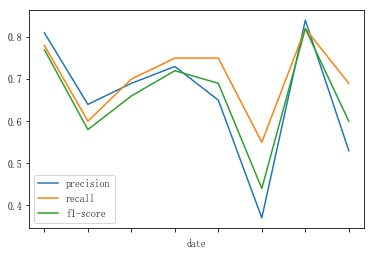

In [44]:
PR_plot_data[PR_plot_data['label'] == 'avg/total'][[ 'date', 'precision', 'recall' ,'f1-score']].plot(x = 'date')
PR_plot_data[PR_plot_data['label'] == 'avg/total']

precision                                            
label         产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                          
20180904     0.940  0.690  0.780 0.940 0.690 0.650 0.690 0.860
20180905     0.000  0.430  0.000 0.940 0.000 0.390 0.610 0.000
20180912     0.000  0.490  0.000 0.970 0.000 0.550 0.780 0.000
20180920     0.000  0.600  0.000 0.970 0.810 0.620 0.000 0.000
20180925     0.000  0.580  0.000 0.000 0.810 0.710 0.710 0.930
20181008     0.000  0.440  0.630 0.000 0.000 0.650 0.590 0.000
20181019     0.870  0.740  0.740 0.940 0.930 0.790 0.630 0.930
20181112     0.000  0.600  0.650 0.000 0.000 0.810 0.680 0.000

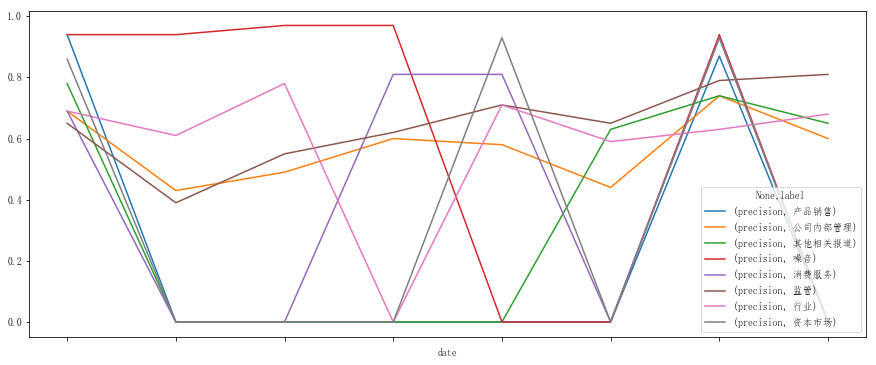

In [45]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'precision']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

recall                                            
label      产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                       
20180904  0.890  0.840  0.920 0.500 0.820 0.980 0.720 0.920
20180905  0.000  0.770  0.000 0.540 0.000 0.940 0.760 0.000
20180912  0.000  0.900  0.000 0.630 0.000 0.980 0.900 0.000
20180920  0.000  0.980  0.000 0.690 0.900 0.880 0.000 0.000
20180925  0.000  0.920  0.000 0.000 0.800 0.930 0.870 0.970
20181008  0.000  0.910  0.750 0.000 0.000 0.980 0.740 0.000
20181019  0.900  0.790  0.800 0.660 0.780 0.960 0.830 0.950
20181112  0.000  0.790  0.890 0.000 0.000 0.990 0.880 0.000

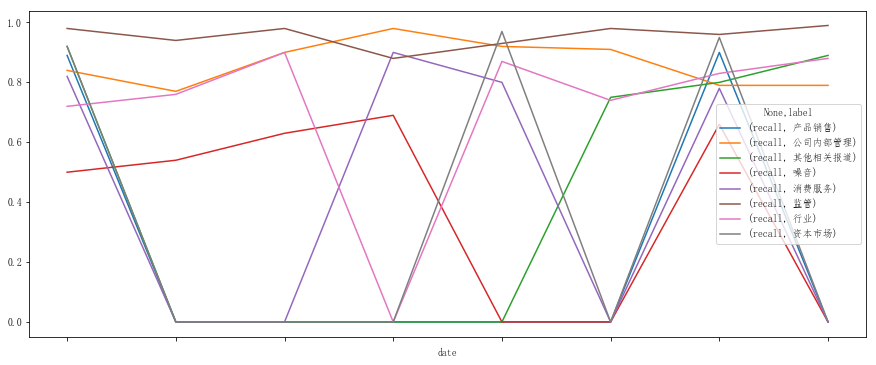

In [46]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'recall']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

f1-score                                            
label        产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                         
20180904    0.920  0.760  0.840 0.650 0.750 0.780 0.710 0.890
20180905    0.000  0.560  0.000 0.680 0.000 0.550 0.680 0.000
20180912    0.000  0.640  0.000 0.760 0.000 0.700 0.840 0.000
20180920    0.000  0.740  0.000 0.800 0.860 0.730 0.000 0.000
20180925    0.000  0.710  0.000 0.000 0.810 0.800 0.780 0.950
20181008    0.000  0.590  0.690 0.000 0.000 0.780 0.660 0.000
20181019    0.880  0.760  0.770 0.780 0.850 0.870 0.720 0.940
20181112    0.000  0.680  0.750 0.000 0.000 0.890 0.760 0.000

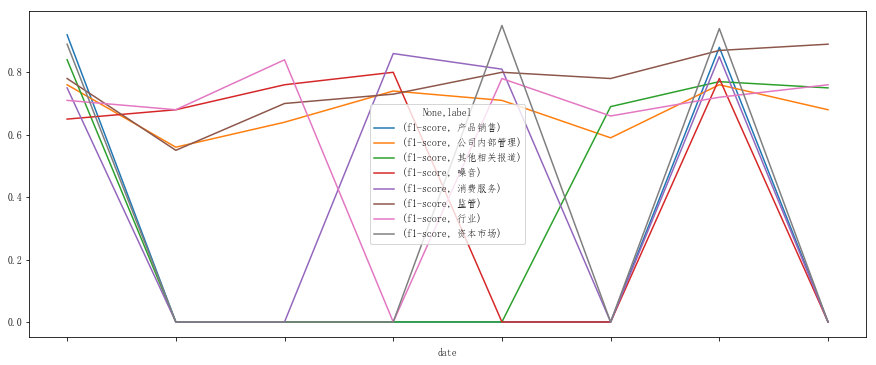

In [47]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'f1-score']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

### 补录与预警数据

In [48]:
file_list_5 = ['20180917_circ_class_feedback.xlsx'
              ] 
add_warn_data = pd.DataFrame()
for file_name in file_list_5:
    currentPath  = '{0}/{1}'.format(folder, file_name)
    excel = xlrd.open_workbook(currentPath)
    sheet_names = [sheet.name for sheet in excel.sheets()]
    for sheet_name in sheet_names:   
        tmp_data = pd.read_excel(currentPath, sheet_name)    
        tmp_data = tmp_data[tmp_data['label'] != '删除']
        add_warn_data = pd.concat([add_warn_data, tmp_data], axis = 0)

circ_raw_class_5 = add_warn_data[['label', 'title', 'content']]

In [49]:
from sklearn import metrics

y_pred_class = add_warn_data['predict_label']
y_test = add_warn_data['label']
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.7766599597585513
             precision    recall  f1-score   support

       产品销售       0.36      0.57      0.44         7
     公司内部管理       0.81      0.79      0.80       104
     其他相关报道       0.50      0.50      0.50         2
         噪音       0.20      0.91      0.33        11
       消费服务       0.97      0.48      0.65        62
         监管       0.88      0.81      0.84        72
         行业       0.87      0.88      0.88       211
       资本市场       0.65      0.54      0.59        28

avg / total       0.84      0.78      0.79       497

confusion_matrix: 
[[  4   0   0   0   0   0   3   0]
 [  0  82   0   3   0   2  13   4]
 [  0   0   1   1   0   0   0   0]
 [  0   0   0  10   0   1   0   0]
 [  2   5   1  18  30   0   6   0]
 [  0   0   0  11   0  58   3   0]
 [  5   6   0   5   1   4 186   4]
 [  0   8   0   2   0   1   2  15]]


In [50]:
circ_raw_class_5['label'].value_counts()

行业        211
公司内部管理    104
监管         72
消费服务       62
资本市场       28
噪音         11
产品销售        7
其他相关报道      2
Name: label, dtype: int64

### 环保与交通类数据

In [51]:
file_list_6 = ['20181118_环保与噪音.xlsx', '20181118_交通.xlsx',
               '20181121_环保与交通.xlsx'
               ] # 多个 sheet

circ_raw_class_6 = get_new_data(folder, file_list_6)

circ_raw_class_6['label'] = circ_raw_class_6['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_class_6.shape)
circ_raw_class_6.head()

Index(['title', 'content', 'label', 'Unnamed: 3'], dtype='object')
去空值前：  (299, 3) 20181118_环保与噪音.xlsx 噪音
去空值后：  (299, 3) 20181118_环保与噪音.xlsx 噪音
Index(['content', 'title', 'label'], dtype='object')
去空值前：  (240, 3) 20181118_环保与噪音.xlsx 自然灾害
去空值后：  (240, 3) 20181118_环保与噪音.xlsx 自然灾害
Index(['title', 'title 2', 'content', 'url', 'domain_2', 'site_name', '倾向性',
       'label'],
      dtype='object')
去空值前：  (4244, 3) 20181118_交通.xlsx 交通语料
去空值后：  (4244, 3) 20181118_交通.xlsx 交通语料
Index(['type', 'urlhash', 'predict_label', 'label', 'title', 'content'], dtype='object')
去空值前：  (500, 3) 20181121_环保与交通.xlsx 环保
去空值后：  (500, 3) 20181121_环保与交通.xlsx 环保
Index(['type', 'urlhash', 'predict_label', 'label', 'title', 'content'], dtype='object')
去空值前：  (530, 3) 20181121_环保与交通.xlsx 交通
去空值后：  (530, 3) 20181121_环保与交通.xlsx 交通
总数： (5813, 3)


,label,title,content
0,噪音,真的，我最大的愿望是世界和平！所有人都被善良对待，没有战争没有死亡没有饥饿没有空难没有猥亵，因为每次看到别人难过，我也会很难过的 ​,真的，我最大的愿望是世界和平！所有人都被善良对待，没有战争没有死亡没有饥饿没有空难没有猥亵，因为每次看到别人难过，我也会很难过的 ​
1,噪音,有人知道25cm娃衣拼单群嘛？或者有人出25cm娃娃穿的娃衣吗？或者有人出甜笑大火羊的娃衣吗？粉红豹和绿色那件？我的大火羊过冬没衣服穿了[摊手][摊手][摊手]@易烊千玺玩偶中转大本营 @易烊千玺周边中转站 谢谢左边麻烦啦 ​,#易烊千玺[超话]#
2,噪音,【食谱文章】by@sourcehe http://t.cn/EAle2AJ ​,#新浪美食精品菜#【香酥炸带鱼】酥香的炸带鱼，需要掌握几个技巧，第一，加点新鲜柠檬汁，可以去带鱼腥味。第二，鱼鳞不需要去，营养价值高，酥脆好吃。第三，炸带鱼大火要在160度左右，回炸的油温要在200度左右，这样炸的带鱼酥脆好吃，不吸油。
3,噪音,最后我不懂，彗星过去了，每个宇宙回到原来的轨道，为什么其他的Em还能打电话来第七个宇宙？讲道理一个宇宙应该只有一个Em存活，其余会发生坍塌不是吗。,NaN
4,噪音,这个电影告诉我们，不要随便打开薛定谔的那个盒子，就让猫不死不活地待着吧。毕竟所有1000个宇宙里，999个我们自己都tm不死不活。,《彗星来的那一夜》


In [52]:
circ_raw_class_6['label'].value_counts()

交通    4474
噪音     798
环保     541
Name: label, dtype: int64

## 合并数据

In [53]:
# file_list_4 = ['20181019_circ_class_feedback.xlsx'] # 多个 sheet
# circ_raw_class_4, PR_data, PR_plot_data = get_feedback_data(folder, file_list_4)
# circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
# print('总数：', circ_raw_class_4.shape)
# circ_raw_class_4.head()

In [54]:
circ_raw_class = pd.concat([circ_raw_class_1, circ_raw_class_2,
                            circ_raw_class_3, circ_raw_class_4,
                            circ_raw_class_5, circ_raw_class_6], 
                            axis = 0)

# circ_raw_class = circ_raw_class_4
circ_raw_class['title_content'] = circ_raw_class['title'].astype(str) + '。' + circ_raw_class['content'].astype(str)
circ_raw_class['label'] = circ_raw_class['label'].apply(lambda x:x.strip())
circ_raw_class['index'] = range(circ_raw_class.shape[0])
print('去重前： ', circ_raw_class.shape)
circ_raw_class = circ_raw_class.drop_duplicates(subset = 'title_content')
print('去重后： ', circ_raw_class.shape)
circ_raw_class.head()

去重前：  (29765, 5)
去重后：  (29748, 5)


,content,label,title,title_content,index
0,天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:28\n中国保监会网站\n\r当事人：张磊\n\r身份证号码：32021119690412****\n\r职务：天安佰盈保险销售有限公司宁波分公司（以下简称天安销售宁波分公司）主要负责人\n\r住所：宁波市鄞州区会展路128 号9 层9D04-9D12 室\n\r依据《中华人民共和国保险法》（2015 年修正）的有关规定，我局天安销售宁波分公司涉嫌违法一案进行了调查、审理，依法向当事人告知了作出行政处罚的事实、理由、依据以及当事人依法享有的权利。当事人未陈述申辩，未要求听证。\n\r经查，天安销售宁波分公司存在如下违法行为：\n\r一、财务数据不真实\n\r2016 年，天安销售宁波分公司虚列业务招待费92.33 万元，实际用于向员工发放福利。公司主要负责人张磊为对该行为直接负责的主管人员。\n\r二、变更营业场所地址未按规定报告\n\r2016 年8 月，天安销售宁波分公司营业场所地址由江北区庄桥街道北环西路500 号（5）幢二层5-27 室变更为鄞州区会展路128 号9层9D04-9D12 室。截至2017 年10 月24 日，上述事项未按规定向我局书面报告。公司主要负责人张磊为该机构直接负责的主管人员。\n\r上述事实，有财务凭证、租赁合同、营业执照、情况说明、调查笔录、任职文件、现场检查事实确认书等证据证明。\n\r综上，我局作出如下处罚：\n\r一、天安销售宁波分公司财务数据不真实的行为，违反了《中华人民共和国保险法》（2015 年修正）第八十六条和第一百三十二条的规定。根据《中华人民共和国保险法》（2015 年修正）第一百七十一条的规定，给予张磊警告，并处罚款5 万元的行政处罚。\n\r二、天安销售宁波分公司变更营业场所地址未按规定报告的行为，违反了《保险专业代理机构监管规定》第十四条的规定。根据《保险专业代理机构监管规定》第七十条的规定，给予张磊警告，处罚款1万元的行政处罚。\n\r当事人应当在接到本处罚决定书之日起15 日内持缴款码到财政部指定的12 家代理银行中的任一银行进行同行缴款。逾期，将每日按罚款数额的3%加处罚款（缴款码在行政处罚决定书送达时一并告知）。当事人如对本处罚决定不服，可在接到本处罚决定书之日起60 日内依法向中国保监会申请行政复议，...,公司内部管理,天安销售虚列费用为员工发福利 相关负责人被处罚,天安销售虚列费用为员工发福利 相关负责人被处罚。 天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:28\n中国保监会网站\n\r当事人：张磊\n\r身份证号码：32021119690412****\n\r职务：天安佰盈保险销售有限公司宁波分公司（以下简称天安销售宁波分公司）主要负责人\n\r住所：宁波市鄞州区会展路128 号9 层9D04-9D12 室\n\r依据《中华人民共和国保险法》（2015 年修正）的有关规定，我局天安销售宁波分公司涉嫌违法一案进行了调查、审理，依法向当事人告知了作出行政处罚的事实、理由、依据以及当事人依法享有的权利。当事人未陈述申辩，未要求听证。\n\r经查，天安销售宁波分公司存在如下违法行为：\n\r一、财务数据不真实\n\r2016 年，天安销售宁波分公司虚列业务招待费92.33 万元，实际用于向员工发放福利。公司主要负责人张磊为对该行为直接负责的主管人员。\n\r二、变更营业场所地址未按规定报告\n\r2016 年8 月，天安销售宁波分公司营业场所地址由江北区庄桥街道北环西路500 号（5）幢二层5-27 室变更为鄞州区会展路128 号9层9D04-9D12 室。截至2017 年10 月24 日，上述事项未按规定向我局书面报告。公司主要负责人张磊为该机构直接负责的主管人员。\n\r上述事实，有财务凭证、租赁合同、营业执照、情况说明、调查笔录、任职文件、现场检查事实确认书等证据证明。\n\r综上，我局作出如下处罚：\n\r一、天安销售宁波分公司财务数据不真实的行为，违反了《中华人民共和国保险法》（2015 年修正）第八十六条和第一百三十二条的规定。根据《中华人民共和国保险法》（2015 年修正）第一百七十一条的规定，给予张磊警告，并处罚款5 万元的行政处罚。\n\r二、天安销售宁波分公司变更营业场所地址未按规定报告的行为，违反了《保险专业代理机构监管规定》第十四条的规定。根据《保险专业代理机构监管规定》第七十条的规定，给予张磊警告，处罚款1万元的行政处罚。\n\r当事人应当在接到本处罚决定书之日起15 日内持缴款码到财政部指定的12 家代理银行中的任一银行进行同行缴款。逾期，将每日按罚款数额的3%加处罚款（缴款码在行政处罚决定书送达时一并告知）。当事人如对本处罚决定不服，可在接到本处罚决定...,0
1,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局” 求职者遭遇违规增员“陷阱”\n\r 早在2009年，原保监会就下发了《关于加强和完善保险营销员管理工作有关事项的通知》，该《通知》中明令禁止现职保险营销人员单独发布招聘信息\n\r 按照 2009年原保监会下发的《关于加强和完善保险营销员管理工作有关事项的通知》 规定，保险公司现职保险营销人员不得单独发布招聘信息，且各公司不得以混淆保险营销人员的职业性质和职位级别等手段误导社会求职人员盲目加入保险营销队伍 ，但在实际操作中，泰康人寿却有大量保险代理人私自以公司的名义发布招聘信息，且以“人力资源专员/助理”等职业称谓混淆营销人员的职业性质。\n\r 记者调查得知，自2017年12月至2018年3月间，泰康人寿长安支公司多位保险代理人相继以泰康人寿北京分公司人事部的名义招聘数名在校大学生，成为长安支公司营销主管张龙(化名)的人力资源助理。期间这些求职者被泰康人寿长安支公司违规收取培训费，并遭到主管张龙隐瞒薪资待遇和克扣应发薪资等不合理对待。\n\r “骗局”?\n\r 据刘丽称，2017年12月初，泰康人寿长安支公司个险营销服务部保险代理人董霞(化名)通过boss直聘网联系大学生刘丽，想要招聘其为支公司人力资源助理。2018年1月4日，刘丽到北京崇文门哈德门广场3楼见到面试官王婷(化名)，经过面试，王婷向刘丽允诺了 “实习期3500元，转正4000元”的薪资待遇。\n\r 4天后，刘丽入职并接受培训，而后成为主管张龙的助理。培训期间，泰康人寿长安支公司通过向建行自动扣款的方式向刘丽收取了100元“岗前培训费”，但刘丽收到的扣款提示信息却显示，该笔款项是以“泰康人寿保险保险费”的名目被扣除的。实际上，按照《关于进一步加强和完善保险营销员管理工作有关事项的通知》规定，保险公司不应向求职者收取培训费用。\n\r 工作期间，刘丽发现张龙在给其助理发放上一个月的薪资时，以“非满勤出席扣500元，未招满4人工资减半，对应招聘差额每人再减100元”的克扣标准，将该助理原本每月3500元的底薪，克扣到1200元。而这些克扣标准，张龙此前从未告知过刘丽和其他新来的助理。由此，刘丽认为自己遭遇了招聘“骗局”。\n\r 随后，其他新来的助理也知道了薪资标准被故意隐瞒的情况，...,公司内部管理,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元。 泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局” 求职者遭遇违规增员“陷阱”\n\r 早在2009年，原保监会就下发了《关于加强和完善保险营销员管理工作有关事项的通知》，该《通知》中明令禁止现职保险营销人员单独发布招聘信息\n\r 按照 2009年原保监会下发的《关于加强和完善保险营销员管理工作有关事项的通知》 规定，保险公司现职保险营销人员不得单独发布招聘信息，且各公司不得以混淆保险营销人员的职业性质和职位级别等手段误导社会求职人员盲目加入保险营销队伍 ，但在实际操作中，泰康人寿却有大量保险代理人私自以公司的名义发布招聘信息，且以“人力资源专员/助理”等职业称谓混淆营销人员的职业性质。\n\r 记者调查得知，自2017年12月至2018年3月间，泰康人寿长安支公司多位保险代理人相继以泰康人寿北京分公司人事部的名义招聘数名在校大学生，成为长安支公司营销主管张龙(化名)的人力资源助理。期间这些求职者被泰康人寿长安支公司违规收取培训费，并遭到主管张龙隐瞒薪资待遇和克扣应发薪资等不合理对待。\n\r “骗局”?\n\r 据刘丽称，2017年12月初，泰康人寿长安支公司个险营销服务部保险代理人董霞(化名)通过boss直聘网联系大学生刘丽，想要招聘其为支公司人力资源助理。2018年1月4日，刘丽到北京崇文门哈德门广场3楼见到面试官王婷(化名)，经过面试，王婷向刘丽允诺了 “实习期3500元，转正4000元”的薪资待遇。\n\r 4天后，刘丽入职并接受培训，而后成为主管张龙的助理。培训期间，泰康人寿长安支公司通过向建行自动扣款的方式向刘丽收取了100元“岗前培训费”，但刘丽收到的扣款提示信息却显示，该笔款项是以“泰康人寿保险保险费”的名目被扣除的。实际上，按照《关于进一步加强和完善保险营销员管理工作有关事项的通知》规定，保险公司不应向求职者收取培训费用。\n\r 工作期间，刘丽发现张龙在给其助理发放上一个月的薪资时，以“非满勤出席扣500元，未招满4人工资减半，对应招聘差额每人再减1

In [55]:
print(circ_raw_class.shape)
circ_raw_class.groupby('label')['title'].count()

(29748, 5)


label
交通        4474
产品销售      1266
公司内部管理    3100
其他相关报道    2347
噪音        7148
消费服务      2757
环保         541
监管        3025
行业        3291
资本市场      1799
Name: title, dtype: int64

In [56]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%S:%M")
circ_raw_class_num = circ_raw_class.groupby('label')['title'].count().reset_index()
circ_raw_class_num.columns = ['label', 'num']
tmp_num = pd.DataFrame([['日期：', now],
                        ['总量', circ_raw_class_num['num'].sum(axis = 0)]],
                      columns = ['label', 'num'])
circ_raw_class_num = pd.concat([tmp_num, circ_raw_class_num])
circ_raw_class_num.T.to_csv('statistics_result/PICC_class_data_num.csv', index = False, mode = 'a', encoding = 'utf-8')
circ_raw_class_num.T

,0,1,0,1,2,3,4,5,6,7,8,9
label,日期：,总量,交通,产品销售,公司内部管理,其他相关报道,噪音,消费服务,环保,监管,行业,资本市场
num,2018-11-27 09:23:43,29748,4474,1266,3100,2347,7148,2757,541,3025,3291,1799


## 预处理

In [31]:
save_folder = 'picc_result_class/'
pre_save(pre_cor_circ.handle_contents, circ_raw_class, save_folder)

(29748, 5)
save_folder:  picc_result_class/
title num:  29748
content num:  29748
天安 销售 虚列费用 员工 发 福利 相 负 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 未 听证 经查 天安 销售 宁波 分公司 违法行为 财务 数据不真实 年 天安 销售 宁波 分公司 虚列 业务 招待费 万元 公司 负 变幢 二层 室变 年月日 事项 未按规定 我局 书面报告 公司 负 上述事实 财务 凭证 租赁 合同 营业执照 情况 调查 笔录 现场 检查 事实 确认书 证据 证明 综上 我局 作出 处罚 天安 销售 宁波 分公司 财务 数据不真实 违反 中华人民共和国 保险法 第八 十六条 第一百 三十二条 中华人民共和国 保险法 一百七十 一条 给予 张磊 警告 并处 罚款 万元 行政处罚 天安 销售 宁波 分公司 变 专业 代理 机构 监管 七十条 给予 张磊 警告 处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 逾期 每日 罚款 数额 加处 罚款 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国保监会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局 年月日 
label num:  29748


# 保险业：2 倾向性

## 读取数据

In [9]:
folder = 'circ_data_tendency/20181112'

### 预测正确数据

In [10]:
# file_list_1 = ['circ_class_sel_else_20180827.xlsx',]
# circ_raw_class_1 = predict_right(folder, file_list_1)

# circ_raw_class_1['label'] = circ_raw_class_1['label'].apply(lambda x:x.strip())    
# circ_raw_class_1 = circ_raw_class_1[['label', 'raw_title', 'raw_content']]
# circ_raw_class_1.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_1.shape)
# circ_raw_class_1.head()

In [11]:
# circ_raw_class_1['label'].value_counts()

### 预测错误修正后数据

In [12]:
# file_list_2 = ['circ_class_sel_20180827-1.xlsx','circ_class_sel_20180827-2.xlsx']

# circ_raw_class_2 = correct_wrong_data(folder, file_list_2)
# circ_raw_class_2['label'] = circ_raw_class_2['label'].apply(lambda x:x.strip())  
# circ_raw_class_2 = circ_raw_class_2[['备注', 'raw_title', 'raw_content']]
# circ_raw_class_2.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_2.shape)
# circ_raw_class_2.head()

In [13]:
# circ_raw_class_2['label'].value_counts()

### 新补充数据

In [61]:
file_list_3 = ['circ_tendency_data_20181113.xlsx', 
              
               ] # 多个 sheet

circ_raw_tendency_3 = get_new_data(folder, file_list_3)

# circ_raw_tendency_3['label'] = circ_raw_tendency_3['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_tendency_3.shape)
circ_raw_tendency_3.loc[:1,:]

Index(['content', 'label', 'title', 'title_content'], dtype='object')
去空值前：  (3473, 3) circ_tendency_data_20181113.xlsx tendency
去空值后：  (3473, 3) circ_tendency_data_20181113.xlsx tendency
总数： (3473, 3)


,label,title,content
0,-1,根据决定书，国寿财险瑞金支公司存在以下违法行为：,"\n\t\t\t\t\t <font color=""#FF0000"">保监会</font>网站今日公布<font color=""#FF0000"">江西保监局</font>对<font color=""#FF0000"">中国人寿财产保险</font>股份有限公司瑞金支公司(以下简称<font color=""#FF0000"">国寿财险</font>瑞金支公司)的行政处罚决定。决定书显示，<font color=""#FF0000"">国寿财险</font>瑞金支公司存在虚构<font color=""#FF0000"">保险</font>中介业务套取费用等共三宗违法行为。<font color=""#FF0000"">江西保监局</font>依法对该公司罚款共计46万元。 根据决定书，<font color=""#FF0000"">国寿财险</font>瑞金支公司存在以下违法行为： 一、2015年-2017年，存在利用<font color=""#FF0000"">保险代理人</font>从事以虚构<font color=""#FF0000"">保险</font>中介业务的方式套取费用的行为。时任<font color=""#FF0000"">国寿财险</font>瑞金支公司副经理(主持工作)钟金艳对上述违法行为负有直接责任。 二、2015年-2017年，存在未如实记录<font color=""#FF0000"">保险</font>业务事项的行为。时任<font color=""#FF0000"">国寿财险</font>瑞金支公司副经理(主持工作)钟金艳对上述违法行为负有直接责任。 三、2016年5月-2017年6月，存在给予投保人<font color=""#FF0000"">保险</font>合同约定以外利益的行为。时任<font color=""#FF0000"">国寿财险</font>瑞金支公司副经理(主持工作)钟金艳对上述违法行为负有直接责任。 <font color=""#FF0000"">江西保监局</font>决定作出如下处罚： 上述利用<font color=""#FF0000"">保险代理人</font>从事以虚构<font color=""#FF0000"">保险</font>中介业务的方式套取费用的行为，违反了《<font color=""#FF0000"">保险</font>法》..."
1,-1,转型阵痛 净利下滑,"\n\t\t\t\t\t 随着<font color=""#FF0000"">寿险</font>公司偿付能力报告陆续披露，各险企2017年的净利润数据也随之出炉。据《证券日报》记者不完全统计显示，截至昨日，共有65家险企披露了去年四季度偿付能力报告，其中有36家险企净利润为正，29家净利润为负，其中4家的净亏损均超过5亿元。 从已经披露的情况来看，净利润较高的<font color=""#FF0000"">寿险</font>公司包括<font color=""#FF0000"">泰康人寿</font>、<font color=""#FF0000"">华夏人寿</font>、<font color=""#FF0000"">友邦保险</font>、<font color=""#FF0000"">阳光人寿</font>、<font color=""#FF0000"">前海人寿</font>、<font color=""#FF0000"">恒大人寿</font>、<font color=""#FF0000"">中信保诚人寿</font>等险企；亏损的<font color=""#FF0000"">寿险</font>公司包括<font color=""#FF0000"">长城人寿</font>、<font color=""#FF0000"">吉祥人寿</font>、<font color=""#FF0000"">中韩人寿</font>等险企。 从全行业来看，<font color=""#FF0000"">保监会</font>披露的数据显示，<font color=""#FF0000"">保险</font>行业去年共实现<font color=""#FF0000"">原保险</font>保费收入3.66万亿元，同比增长18.2%，<font color=""#FF0000"">保险</font>公司预计利润为2567亿元，同比增长了29.7%。 转型阵痛 净利下滑 从亏损险企的特征来看，均为中小险企，多数险企以银保渠道为主，个险队伍建设较为薄弱，个别险企银保保费占比超过80%。从保费构成来看，亏损险企此前多以销售<font color=""#FF0000"">万能型保险</font>为主，传统保障型产品占比较低。 在强监管政策背景下，以<font color=""#FF0000"">万能险</font>产品为主的中小险企面临巨大的..."


In [62]:
circ_raw_tendency_3['label'].value_counts()

-1    2372
0     1101
Name: label, dtype: int64

### 模型预测后反馈数据

In [63]:
file_list_4 = [ 'circ_tendency_feedback_20181116.xlsx',
              ] # 多个 sheet

circ_raw_tendecny_4, PR_data, PR_plot_data = get_feedback_data(folder, file_list_4, 'tendency')

# circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_class_4.shape)
circ_raw_class_4.iloc[:1,:]

  ----     circ_tendency_feedback_20181116.xlsx
类别： 0 总数： 200 正确数 189 正确比例 0.945
去空值前：  (200, 5) circ_tendency_feedback_20181116.xlsx 0
去空值后：  (200, 5) circ_tendency_feedback_20181116.xlsx 0

类别： -1 总数： 200 正确数 53 正确比例 0.265
去空值前：  (200, 5) circ_tendency_feedback_20181116.xlsx -1
去空值后：  (200, 5) circ_tendency_feedback_20181116.xlsx -1

accuracy_score:  0.605
             precision    recall  f1-score   support

         -1       0.27      0.83      0.40        64
          0       0.94      0.56      0.71       336

avg / total       0.84      0.60      0.66       400

confusion_matrix: 
[[ 53  11]
 [147 189]]

总数： (400, 3)


,label,title,content
0,0,车辆被撞对方耍赖怎么办？看这里彻底帮你搞定！| 保险与你,来源：财险互动 如果开车正常行驶被别人撞了，对方全责，找对方赔偿就好。 可事情并不总是那么简单，如果运气不好碰到了“老赖”，拖延赔偿或不赔偿。那该如何维护自己的权益呢？ 如果你不想掏腰包为别人的错误买单的话，找自己的保险公司申请代位求偿可以帮到你。 什么是代位赔偿？ 不少车主还不清楚什么是代位赔偿。 通俗的说，代位赔偿就是保险公司先帮车主垫付车损费，然后再由保险公司去找责任方去追讨赔偿。至于保险公司用什么办法，能不能追讨到赔偿，那就是保险公司和责任方之间的事情了。 书面解释： 代位赔偿又称为代位追偿，是指被保险物品发生保险责任范围内的由第三者责任造成的损失，保险人（保险公司）向被保险人（车主）履行损失赔偿责任后，保险人（保险公司）有权在其已经赔付金额的限度内取得被保险人（车主）在该项损失中向第三责任方要求赔偿的权利。 保险人（保险公司）取得该项权利后，即可取代被保险人（车主）的地位向第三责任方索赔。 ▼ 以下广告已包年：2018-4-10至21019-4-9 ▼ ▲以上广告包年，感谢支持商群！ 064▲ 怎么样才能申请代位赔偿？ 申请使用“代位赔偿”的前提就是您需要投保交强险和商业保险（如第三者责任险、车辆损失险等），否则保险公司是不会受理您的申请的。 哪种情况下可以申请代位赔偿？ 1 对方车辆无保险： 责任方车辆没上车险，且责任方车主不肯赔偿的，这时您可以申请“代位赔偿”； 2 对方拒绝在交通事故责任认定书上签字： 在有些交通事故中，对方对交警的裁决有异议，对交警出具的事故责任认定书不认可且拒绝签字。对于这种情况，作为受害方的您可以向您所在的保险公司申请“代位赔偿”； 3 对方故意拖延或故意拒付相关赔偿： 在有些事故中遇到一些“老赖”（指拒不赔付欠款或者赔偿，这类人群的俗称），在警察给出相关裁决之后，以各种理由拒绝或者延期赔付维修费用，甚至“人间消失”。此时也可以向保险公司申请“代位赔偿”； 4 对方逃逸后有证据证明肇事车辆信息： 肇事逃逸的情况在近几年的交通事故中频发，如果在发生交通事故之后，对方肇事车辆逃逸，此时您可以通过照片、行车记录仪甚至是录音记下对方的车牌号和车主的信息，这样也可以向您所投保的保险公司申请“代位赔偿”； 5 对方无经济赔偿能力： 责任方表示经济条件差，没钱赔付，如三轮车刮花汽车。有些车主可能会自己承担维修费用，让对方走。而如果您...


In [64]:
circ_raw_class_4['label'].value_counts()

0     336
-1     64
Name: label, dtype: int64

#### PR

In [43]:
y_pred_class = PR_data['tendency'].astype(str).tolist()
y_test = PR_data['label'].astype(str).tolist()
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.605
             precision    recall  f1-score   support

         -1       0.27      0.83      0.40        64
          0       0.94      0.56      0.71       336

avg / total       0.84      0.60      0.66       400

confusion_matrix: 
[[ 53  11]
 [147 189]]


,label,precision,recall,f1-score,support,date
2,avg/total,0.840,0.600,0.660,400.000,circ


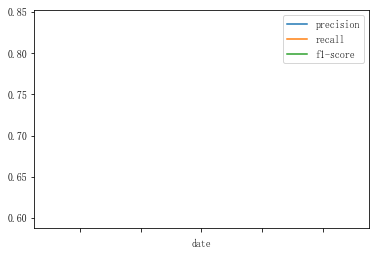

In [44]:
PR_plot_data[PR_plot_data['label'] == 'avg/total'][[ 'date', 'precision', 'recall' ,'f1-score']].plot(x = 'date')
PR_plot_data[PR_plot_data['label'] == 'avg/total']

precision      
label        -1     0
date                 
circ      0.270 0.940

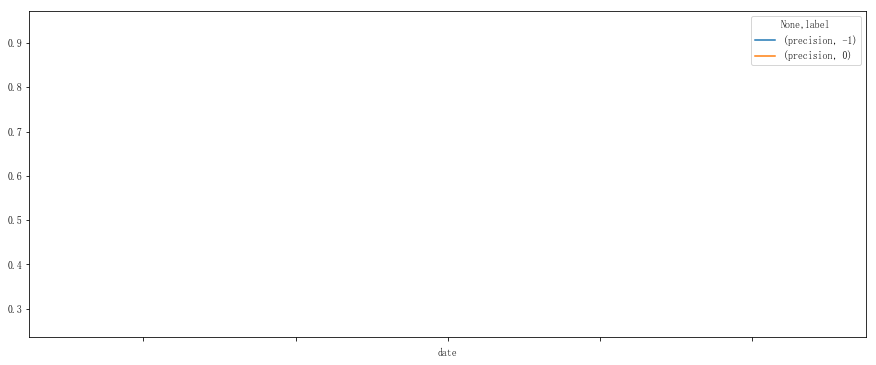

In [45]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'precision']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

recall      
label     -1     0
date              
circ   0.830 0.560

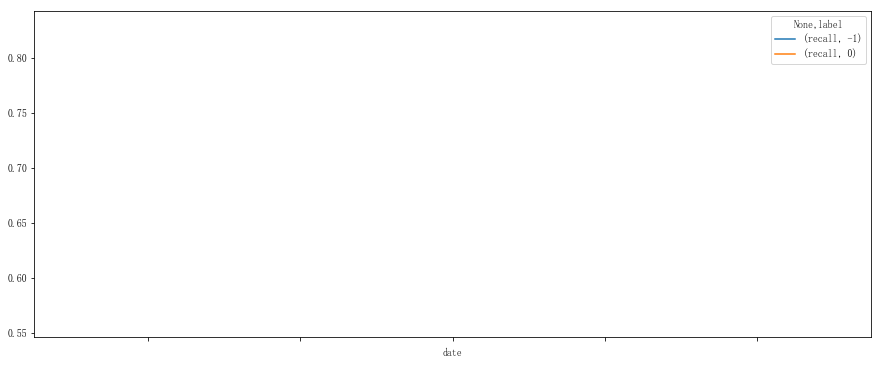

In [46]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'recall']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

f1-score      
label       -1     0
date                
circ     0.400 0.710

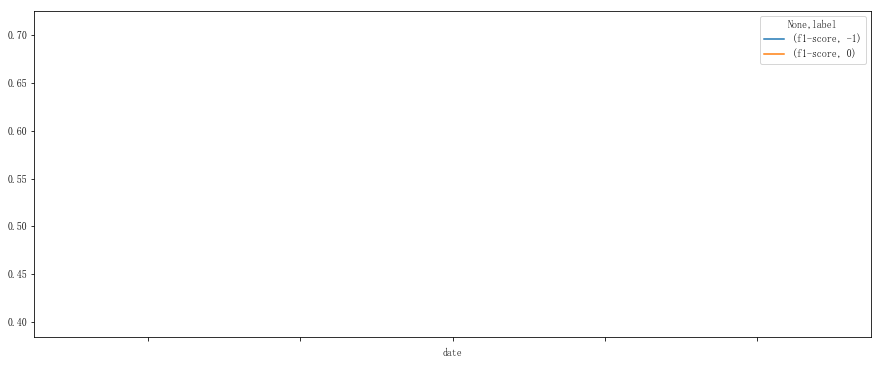

In [47]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'f1-score']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

## 合并数据

In [65]:
circ_raw_tendency = pd.concat([# circ_raw_tendecny_1, circ_raw_tendecny_2,
                          circ_raw_tendency_3, circ_raw_tendecny_4], 
                         axis = 0)

# circ_raw_tendency = circ_raw_tendency_3
circ_raw_tendency['title_content'] = circ_raw_tendency['title'].astype(str) + '。' + circ_raw_tendency['content'].astype(str)
# circ_raw_tendency['label'] = circ_raw_tendency['label'].apply(lambda x:x.strip())
# circ_raw_tendency['index'] = range(circ_raw_tendency.shape[0])
print('去重前： ', circ_raw_tendency.shape)
circ_raw_tendency = circ_raw_tendency.drop_duplicates(subset = 'title_content')
print('去重后： ', circ_raw_tendency.shape)
circ_raw_tendency.iloc[:2, :]

去重前：  (3873, 4)
去重后：  (3873, 4)


,label,title,content,title_content
0,-1,根据决定书，国寿财险瑞金支公司存在以下违法行为：,"\n\t\t\t\t\t <font color=""#FF0000"">保监会</font>网站今日公布<font color=""#FF0000"">江西保监局</font>对<font color=""#FF0000"">中国人寿财产保险</font>股份有限公司瑞金支公司(以下简称<font color=""#FF0000"">国寿财险</font>瑞金支公司)的行政处罚决定。决定书显示，<font color=""#FF0000"">国寿财险</font>瑞金支公司存在虚构<font color=""#FF0000"">保险</font>中介业务套取费用等共三宗违法行为。<font color=""#FF0000"">江西保监局</font>依法对该公司罚款共计46万元。 根据决定书，<font color=""#FF0000"">国寿财险</font>瑞金支公司存在以下违法行为： 一、2015年-2017年，存在利用<font color=""#FF0000"">保险代理人</font>从事以虚构<font color=""#FF0000"">保险</font>中介业务的方式套取费用的行为。时任<font color=""#FF0000"">国寿财险</font>瑞金支公司副经理(主持工作)钟金艳对上述违法行为负有直接责任。 二、2015年-2017年，存在未如实记录<font color=""#FF0000"">保险</font>业务事项的行为。时任<font color=""#FF0000"">国寿财险</font>瑞金支公司副经理(主持工作)钟金艳对上述违法行为负有直接责任。 三、2016年5月-2017年6月，存在给予投保人<font color=""#FF0000"">保险</font>合同约定以外利益的行为。时任<font color=""#FF0000"">国寿财险</font>瑞金支公司副经理(主持工作)钟金艳对上述违法行为负有直接责任。 <font color=""#FF0000"">江西保监局</font>决定作出如下处罚： 上述利用<font color=""#FF0000"">保险代理人</font>从事以虚构<font color=""#FF0000"">保险</font>中介业务的方式套取费用的行为，违反了《<font color=""#FF0000"">保险</font>法》...","根据决定书，国寿财险瑞金支公司存在以下违法行为：。 \n\t\t\t\t\t <font color=""#FF0000"">保监会</font>网站今日公布<font color=""#FF0000"">江西保监局</font>对<font color=""#FF0000"">中国人寿财产保险</font>股份有限公司瑞金支公司(以下简称<font color=""#FF0000"">国寿财险</font>瑞金支公司)的行政处罚决定。决定书显示，<font color=""#FF0000"">国寿财险</font>瑞金支公司存在虚构<font color=""#FF0000"">保险</font>中介业务套取费用等共三宗违法行为。<font color=""#FF0000"">江西保监局</font>依法对该公司罚款共计46万元。 根据决定书，<font color=""#FF0000"">国寿财险</font>瑞金支公司存在以下违法行为： 一、2015年-2017年，存在利用<font color=""#FF0000"">保险代理人</font>从事以虚构<font color=""#FF0000"">保险</font>中介业务的方式套取费用的行为。时任<font color=""#FF0000"">国寿财险</font>瑞金支公司副经理(主持工作)钟金艳对上述违法行为负有直接责任。 二、2015年-2017年，存在未如实记录<font color=""#FF0000"">保险</font>业务事项的行为。时任<font color=""#FF0000"">国寿财险</font>瑞金支公司副经理(主持工作)钟金艳对上述违法行为负有直接责任。 三、2016年5月-2017年6月，存在给予投保人<font color=""#FF0000"">保险</font>合同约定以外利益的行为。时任<font color=""#FF0000"">国寿财险</font>瑞金支公司副经理(主持工作)钟金艳对上述违法行为负有直接责任。 <font color=""#FF0000"">江西保监局</font>决定作出如下处罚： 上述利用<font color=""#FF0000"">保险代理人</font>从事以虚构<font color=""#FF0000"">保险</font>中介业务的方式套取费用的行为，违反了《<font ..."
1,-1,转型阵痛 净利下滑,"\n\t\t\t\t\t 随着<font color=""#FF0000"">寿险</font>公司偿付能力报告陆续披露，各险企2017年的净利润数据也随之出炉。据《证券日报》记者不完全统计显示，截至昨日，共有65家险企披露了去年四季度偿付能力报告，其中有36家险企净利润为正，29家净利润为负，其中4家的净亏损均超过5亿元。 从已经披露的情况来看，净利润较高的<font color=""#FF0000"">寿险</font>公司包括<font color=""#FF0000"">泰康人寿</font>、<font color=""#FF0000"">华夏人寿</font>、<font color=""#FF0000"">友邦保险</font>、<font color=""#FF0000"">阳光人寿</font>、<font color=""#FF0000"">前海人寿</font>、<font color=""#FF0000"">恒大人寿</font>、<font color=""#FF0000"">中信保诚人寿</font>等险企；亏损的<font color=""#FF0000"">寿险</font>公司包括<font color=""#FF0000"">长城人寿</font>、<font color=""#FF0000"">吉祥人寿</font>、<font color=""#FF0000"">中韩人寿</font>等险企。 从全行业来看，<font color=""#FF0000"">保监会</font>披露的数据显示，<font color=""#FF0000"">保险</font>行业去年共实现<font color=""#FF0000"">原保险</font>保费收入3.66万亿元，同比增长18.2%，<font color=""#FF0000"">保险</font>公司预计利润为2567亿元，同比增长了29.7%。 转型阵痛 净利下滑 从亏损险企的特征来看，均为中小险企，多数险企以银保渠道为主，个险队伍建设较为薄弱，个别险企银保保费占比超过80%。从保费构成来看，亏损险企此前多以销售<font color=""#FF0000"">万能型保险</font>为主，传统保障型产品占比较低。 在强监管政策背景下，以<font color=""#FF0000"">万能险</font>产品为主的中小险企面临巨大的...","转型阵痛 净利下滑。 \n\t\t\t\t\t 随着<font color=""#FF0000"">寿险</font>公司偿付能力报告陆续披露，各险企2017年的净利润数据也随之出炉。据《证券日报》记者不完全统计显示，截至昨日，共有65家险企披露了去年四季度偿付能力报告，其中有36家险企净利润为正，29家净利润为负，其中4家的净亏损均超过5亿元。 从已经披露的情况来看，净利润较高的<font color=""#FF0000"">寿险</font>公司包括<font color=""#FF0000"">泰康人寿</font>、<font color=""#FF0000"">华夏人寿</font>、<font color=""#FF0000"">友邦保险</font>、<font color=""#FF0000"">阳光人寿</font>、<font color=""#FF0000"">前海人寿</font>、<font color=""#FF0000"">恒大人寿</font>、<font color=""#FF0000"">中信保诚人寿</font>等险企；亏损的<font color=""#FF0000"">寿险</font>公司包括<font color=""#FF0000"">长城人寿</font>、<font color=""#FF0000"">吉祥人寿</font>、<font color=""#FF0000"">中韩人寿</font>等险企。 从全行业来看，<font color=""#FF0000"">保监会</font>披露的数据显示，<font color=""#FF0000"">保险</font>行业去年共实现<font color=""#FF0000"">原保险</font>保费收入3.66万亿元，同比增长18.2%，<font color=""#FF0000"">保险</font>公司预计利润为25

In [66]:
print(circ_raw_tendency.shape)
circ_raw_tendency.groupby('label')['title'].count()

(3873, 4)


label
-1    2436
0     1434
Name: title, dtype: int64

In [68]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%S:%M")
circ_raw_class_num = circ_raw_tendency.groupby('label')['title'].count().reset_index()
circ_raw_class_num.columns = ['label', 'num']
tmp_num = pd.DataFrame([['日期：', now],
                        ['总量', circ_raw_class_num['num'].sum(axis = 0)]],
                      columns = ['label', 'num'])
circ_raw_class_num = pd.concat([tmp_num, circ_raw_class_num])
circ_raw_class_num.T.to_csv('statistics_result/CIRC_tendency_data_num.csv', index = False, mode = 'a', encoding = 'utf-8')
circ_raw_class_num.T

,0,1,0,1
label,日期：,总量,-1,0
num,2018-12-03 10:16:52,3870,2436,1434


## 预处理

In [69]:
save_folder = 'circ_result_tendency/'
pre_save(pre_cor_circ.handle_contents, circ_raw_tendency, save_folder)

(3873, 4)
save_folder:  circ_result_tendency/
title num:  3873
content num:  3873
保监会 网站 今日 公布 江西保监局 中国人寿财产保险 股份 有限公司 瑞金 支公司 简称 国寿财险 瑞金 支公司 行政处罚 决定书 显示 国寿财险 瑞金 支公司 虚构 中介 业务 套取费用 三宗 违法行为 江西保监局 依法 公司 罚款 共计 万元 决定书 国寿财险 瑞金 支公司 违法行为 年 年 利用 代理人 虚构 中介 业务 方式 套取费用 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 年 年 未如实 记录 业务 事项 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 年 月 年 月 给予 投保人 合同 约定 利益 时 国寿财险 瑞金 支公司 副经理 钟金艳 违法行为 负有 江西保监局 作出 处罚 利用 代理人 虚构 中介 业务 方式 套取费用 违反 法 一百一十 六条 法 第一百六十一条 江西保监局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 江西保监局 对钟 金艳 给予警告 罚款 万元 未如实 记录 业务 事项 违反 法 第八 十六条 法 第一百七十条 江西保监局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 江西保监局 对钟 金艳 给予警告 罚款 万元 给予 投保人 合同 约定 利益 违反 法 一百一十 六条 法 第一百六十一条 江西保监局 国寿财险 瑞金 支公司 罚款 万元 法 一百七十 一条 江西保监局 对钟 金艳 给予警告 罚款 万元 
label num:  3873


# 保险业：3 预警

- 1: 预警
- 0: 非预警

## 读取数据

In [ ]:
folder = 'circ_data_warn/20180621'

### 预测正确数据

In [ ]:
# file_list_1 = ['circ_class_sel_else_20180827.xlsx',]
# circ_raw_class_1 = predict_right(folder, file_list_1)

# circ_raw_class_1['label'] = circ_raw_class_1['label'].apply(lambda x:x.strip())    
# circ_raw_class_1 = circ_raw_class_1[['label', 'raw_title', 'raw_content']]
# circ_raw_class_1.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_1.shape)
# circ_raw_class_1.head()

In [ ]:
# circ_raw_class_1['label'].value_counts()

### 预测错误修正后数据

In [ ]:
# file_list_2 = ['circ_class_sel_20180827-1.xlsx','circ_class_sel_20180827-2.xlsx']

# circ_raw_class_2 = correct_wrong_data(folder, file_list_2)
# circ_raw_class_2['label'] = circ_raw_class_2['label'].apply(lambda x:x.strip())  
# circ_raw_class_2 = circ_raw_class_2[['备注', 'raw_title', 'raw_content']]
# circ_raw_class_2.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_2.shape)
# circ_raw_class_2.head()

In [ ]:
# circ_raw_class_2['label'].value_counts()

### 新补充数据

In [ ]:
file_list_3 = ['20180621_circ_warn_data.xlsx'
               ] # 多个 sheet

circ_raw_warn_3 = get_new_data(folder, file_list_3)

# circ_raw_warn_3['label'] = circ_raw_warn_3['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_warn_3.shape)
circ_raw_warn_3.head()

In [ ]:
circ_raw_warn_3['label'].value_counts()

### 模型预测后反馈数据

In [ ]:
# file_list_4 = ['20180904_circ_class_feedback.xlsx', '20180904_circ_class_feedback_1.xlsx',
#               ] # 多个 sheet

# circ_raw_class_4 = get_feedback_data(folder, file_list_4)

# circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
# print('总数：', circ_raw_class_4.shape)
# circ_raw_class_4.head()

In [ ]:
# circ_raw_class_4['label'].value_counts()

## 合并数据

In [ ]:
# circ_raw_class = pd.concat([circ_raw_class_1, circ_raw_class_2,
#                           circ_raw_class_3, circ_raw_class_4], 
#                          axis = 0)

circ_raw_warn = circ_raw_warn_3
circ_raw_warn['title_content'] = circ_raw_warn['title'].astype(str) + '。' + circ_raw_warn['content'].astype(str)
# circ_raw_warn['label'] = circ_raw_warn['label'].apply(lambda x:x.strip())
circ_raw_warn['index'] = range(circ_raw_warn.shape[0])
print('去重前： ', circ_raw_warn.shape)
circ_raw_warn = circ_raw_warn.drop_duplicates(subset = 'title_content')
print('去重后： ', circ_raw_warn.shape)
circ_raw_warn.head()

In [ ]:
print(circ_raw_warn.shape)
circ_raw_warn.groupby('label')['title'].count()

## 预处理

In [ ]:
save_folder = 'circ_result_warn/'
pre_save(pre_cor_circ.handle_contents, circ_raw_warn, save_folder)

# 银行业：1 八分类

## 读取数据

In [57]:
folder = 'cbrc_data_class/20180925'

### 预测正确数据

In [58]:
file_list_1 = ['20180918_cbrc_class_else.xlsx',]
cbrc_raw_class_1 = predict_right(folder, file_list_1)

cbrc_raw_class_1['label'] = cbrc_raw_class_1['label'].apply(lambda x:x.strip())    
cbrc_raw_class_1 = cbrc_raw_class_1[['label', 'raw_title', 'raw_content']]
cbrc_raw_class_1.columns = ['label', 'title', 'content']
print('总数：', cbrc_raw_class_1.shape)
cbrc_raw_class_1.head()

去空值前：  (1310, 8) 20180918_cbrc_class_else.xlsx 噪音
去空值前：  (794, 8) 20180918_cbrc_class_else.xlsx 公司内部管理
去空值前：  (1016, 8) 20180918_cbrc_class_else.xlsx 行业
去空值前：  (1247, 8) 20180918_cbrc_class_else.xlsx 监管
去空值前：  (874, 8) 20180918_cbrc_class_else.xlsx 消费服务
去空值前：  (781, 8) 20180918_cbrc_class_else.xlsx 资本市场
去空值前：  (803, 8) 20180918_cbrc_class_else.xlsx 产品销售
去空值前：  (1371, 8) 20180918_cbrc_class_else.xlsx 其他相关报道
总数： (8196, 3)


,label,title,content
0,噪音,月线反转阴包阳，原油逢高先空——股友2ze8vS149120——东方财富网博客2015,月线反转阴包阳，原油逢高先空\n(2018-08-01 09:59:13)\n\n美原油市场昨日完成了7月的最终形态构造，回顾一下月线的走势，7月初行情低开在73.67的位置后行情先回补缺口给出75.27的新高后行情受到压力开始回落，周线形成黄昏之星形态后行情延续下行月中行情最低给到了66.27的位置后行情开始整理，最终月线收线在了68附近后，月线行情以一根下影线稍长于上影线的大阴线形态收线，而这样的形态收尾后，月线形成阴包阳技术信号，月线有进一步回落给低点的需求，点位上，今日给出69附近轻仓空，止损69.5，目标看68和67.5附近。\n\n上海原油操作，今日给出505空，止损507下方目标看501和497附近。\n\n基本面，刚刚结束的7月基本面可以说大事件频繁，中美开端，欧美避免以及美国对伊朗的制裁以及美国第二季度GDP增速提高都是一个长远性质的基本面事件，但这些事件的相关方都带了一个美国，那么下一步美国的动向就非常重要了，目前距离美国的中期选举还有100天的时间，特朗普要想继续连任，那么国内的经济稳定以及其竞选的言论得到实施还有就业能进一步增强就是其连任的核心，而在影响最大的中美上美国目前用150亿美元回补美国的大豆种植者在很大程度上缓解了这一事件对其国内的影响，而尽管单边主义不利于世界经济，但美国作为最大的经济体，美元作为目前国际上唯一的国际货币可以说是主导全球的经济发展方向，美国在的损失世界其他国家会补充给美国，而中国虽然政府很富，但的后果只能由中国民众来承担，长此以往只会加重国内的通胀压力，而税负增加，房地产泡沫巨大，民众和民企都艰难度日的环境下，想要扩大内需消耗掉所带来的影响并非易事，想要找到出路中国政府需另辟蹊径而非一味对抗。今日的基本面主要看20:15的美国ADP就业数据，此数据也是非农前的预期，随后看22:00的美国ISM制造业指数和营建许可，随后22:30关注美国EIA原油库存报告即可，这一数据在上周意外大跌之后，本周的数据非常重要，最后关注明晨2:00的美联储利率决定上限即可。\n\n操作上，美原油：今日给出69附近轻仓空，止损69.5，目标看68和67.5附近。\n\n上海原油：今日给出505空，止损507下方目标看501和497附近。\n\n阅读（\n121\n） | 评论（\n1\n）| \n分享\n\n前一篇：\n一根大阳穿...
1,噪音,汇乔金色名都在售价格为：18000元/平方米,"汇乔金色名都18000元/平方米。毛坯,非毛坯交房。汇乔金色名都项目为小高层,高层。坦洲镇界狮南路30号珠海造贝路口500米处。绿化率35%。汇乔金色名都容积率2.5。物业费：1.8元/㎡·月。项目规划建设2976户。汇翠学校、广大附中、坦洲实验中学,珠海曾正理工,华发商都、华润万家、泰峰电器、世纪银星广场、国美电器,南华医院、南屏医院、上冲医院、坦洲医院,建行、中行、交行、工行,超市、酒店、医院、餐饮、市场、银行等生活配套。敬请关注。"
2,噪音,冒充微博好友实施诈骗 嫌疑人模仿“谍战”以“暗语”联系,好朋友突然在微博上私信你，让你帮忙转账购买高价机票&hellip;&hellip;谁能想到这是一个骗局而且竟然还是甥舅三人所为，为了逃避打击这三个&ldquo;心机boy&rdquo;竟然还模仿谍战片独创了一套&ldquo;暗语&rdquo;。\n\n近日，南宁市公安局便衣侦查支队五大队经过长线经营，打掉了一个以&ldquo;克隆&rdquo;微博冒充好友，请求帮忙买机票方式实施诈骗的犯罪团伙，抓获廖某程、廖某铭、韦某强3名犯罪嫌疑人，缴获作案工具一批。\n\n(图片) ​\n\n4000元钱打出去之后对方失联\n\n&ldquo;兄弟，你帮我买两张后天下午前往上海的飞机票。&rdquo;雷先生在微博里接到朋友罗先生的信息后，根据罗先生提供的联系方式购买机票。结果，4000元钱打出去后，机票没买到，对方电话也无法打通。其实，罗先生的微博已经被不法分子&ldquo;克隆&rdquo;。\n\n雷先生是外地人。5月8日，雷先生的微博里突然接到朋友罗先生发来一条信息说，他和领导刚接到通知，要求在后天下午到上海出差，目前急需购买两张飞机票，但由于业务在身，希望雷先生能&ldquo;帮忙购买两张机票，日后还款&rdquo;。\n\n微博信息里，罗先生发来身份证号等信息后，还提供了一个电话号码，联系人为潘经理。罗先生说，他以前多次跟潘经理买过机票，可以享受优惠票价，并叫雷先生&ldquo;跟潘经理联系就可以了&rdquo;。受朋友之托，雷先生不敢怠慢。在电话里，他按要求报读罗先生提供的身份证号码等信息后，对方说5月10日下午飞往上海的航班只剩下少量机票，如需购买就尽快把钱打到指定银行账上。一旦手机收到信息，就意味着买票成功。\n\n但雷先生按要求把4000元钱打到指定银行账户后，他的手机却没有收到机场方面发回的信息，这就意味着雷先生买票不成功。然而，钱已经转入对方账户上。雷先生便拨打对方的电话号码，语音却提示无法接通。罗先生知道此事后，连喊&ldquo;你受骗了&rdquo;，并让雷先生尽快报案。\n\n(图片)\n\n网络图片\n\n微博名称里加小符号克隆微博\n\n据南宁市公安局便衣侦查支队相关负责人介绍，他们接到外地警方协查通报之后，通过大数据研判发现，涉案团伙的窝点就在宾阳县宾州镇商贸城附近。于是办案民警前往宾州镇商贸城周边展开侦查。\n\n6月27日，民警在宾...
3,噪音,倒数3天 | 2018年工业污水处理运营管理培训暨国家职业资格认证（附最新课程）,各污水处理运营单位： 近年来，随着《水污染防治行动计划》、《中华人民共和国水污染防治法》等政策法规的实施，我国的水环境治理力度空前。尤其在环保督查的大背景之下，各类工业企业污水设施、工业园区污水处理厂作为水污染治理的重点基础设施，能够实现高效稳定的运行并满足达标排放要求，无疑将大大降低水环境污染风险，确保水生态环境的可持续发展。 为了保护水环境、提升工业企业污水设施、各类园区污水处理厂的运营管理水平、确保稳定达标运行、保障处理效果，工业水处理杂志社、中国化工学会工业水处理专业委员会、全国工业水处理信息工作站将于2018年9月联合举办2018年工业污水处理运营管理培训班。本次培训课程主要围绕各类工业污水处理设施的处理工艺、运行、管理、故障诊断与解决方案等方面内容进行。同时，为增强从业人员运行维护水平，本次培训特开展“工业废水处理工”国家职业技能资格鉴定工作，现有关事宜通知如下： 时间地点 培训名称： 2018年工业污水处理运营管理培训暨国家职业技能资格鉴定班 培训日期：9月13—16日（12日全天报到） 报到地点：7天连锁酒店（天津商业大学本溪路地铁站店） 培训地点：中海油天津化工研究设计院有限公司 组织机构 主办单位： 中国化工学会工业水处理专业委员会 工业水处理杂志社 全国工业水处理信息工作站 中国膜工业协会 协办单位： 中海油天津化工研究设计院有限公司 国家工业水处理工程技术研究中心 天津海化环境工程有限公司 《亚洲环保》杂志 培训对象 1.各类工业园区污水厂运行管理人员、技术人员及操作人员； 2.化工、石化、煤化工、钢铁、制药、印染、电镀、造纸等企业污水处理系统管理人员、技术人员和操作人员； 3.污水处理第三方运营企业管理及技术人员； 4.高校、高职等污水处理相关专业学生。 培训内容 本次培训采用集中授课的形式。 模块一：新形势下工业污水处理概况 1、工业污水处理环保政策 2、各行业工业污水排放标准及要求 3、新形势下工业污水处理厂规范化管理 模块二：工业污水处理常用工艺及案例 1、工业污水处理常用工艺流程及水处理通用设备 基本工艺与通用设备， 物化处理工艺， 生化处理工艺， 深度处理工艺， 膜处理工艺， 污泥的处理与处置， 工业废水中VOC气体收集与处置； 2、工业污水处理工艺设计 3、工业污水处理新工艺 高难度工业废水工艺， 工业污水深度处理—高级...
4,噪音,嘉盛集团：欧元/美元蓄势上破，等待FOMC与非农就业 ，大非农几点开始,原标题：嘉盛集团：欧元/美元蓄势上破，等待FOMC与非农就业\n\n原标题：嘉盛集团：欧元/美元蓄势上破，等待FOMC与非农就业\n\n欢迎访问嘉盛集团全新官网\n\nwww.jiasheng-jituan.com\n\n我们不断创新、进步，一切皆为您！\n\n撰文：Fawad Razaqzada – 嘉盛集团技术分析师\n\n关注嘉盛集团官方微信，\n微信搜索公众号“嘉盛集团”，可免费获得《外汇交易新手入门》电子版教材\n，更可预约专属服务以及参加各类活动，与嘉盛首席中文分析师零距离沟通。\n\n今天早上，欧元再度成为主要货币中的最强者，并且兑日元涨势最为显著。此前，日本央行传达出的政策声明相当鸽派。欧元自欧元区数据中获得支撑，因为欧元区7月消费者物价指数涨幅为2012年以来之最。但没有经济增长的证据，因为欧元区二季度GDP增长步伐较慢，从而帮助拖累欧元在今天下午的美国数据公布之前与本周晚些时候更重要的事件（包括周五的美国就业报告在内）发生之前的上涨行情。但欧元面临的大多数负面消息已经过去，并且美元的利多消息也已计入，欧元/美元实际上可望重拾始于2017年年初的长期上涨趋势。\n\n欧元区通胀加速上升同时成长停滞\n\n7月欧元区CPI预览估计值年率上涨2.1%，预期值与前值为上升2.0%。核心CP

### 预测错误修正后数据

In [59]:
file_list_2 = ['20180918_cbrc_class_sel.xlsx']

cbrc_raw_class_2 = correct_wrong_data(folder, file_list_2)
cbrc_raw_class_2['label'] = cbrc_raw_class_2['label'].apply(lambda x:x.strip())  
cbrc_raw_class_2 = cbrc_raw_class_2[['备注', 'raw_title', 'raw_content']]
cbrc_raw_class_2.columns = ['label', 'title', 'content']
print('总数：', cbrc_raw_class_2.shape)
cbrc_raw_class_2.head()

去删除前：  (140, 8) 20180918_cbrc_class_sel.xlsx 公司内部管理
去删除后：  (136, 8) 20180918_cbrc_class_sel.xlsx 公司内部管理
人工误判率： 0.17 算法误判率： 0.57

去删除前：  (226, 8) 20180918_cbrc_class_sel.xlsx 资本市场
去删除后：  (219, 8) 20180918_cbrc_class_sel.xlsx 资本市场
人工误判率： 0.14 算法误判率： 0.50

去删除前：  (182, 8) 20180918_cbrc_class_sel.xlsx 监管
去删除后：  (179, 8) 20180918_cbrc_class_sel.xlsx 监管
人工误判率： 0.25 算法误判率： 0.56

去删除前：  (163, 8) 20180918_cbrc_class_sel.xlsx 消费服务
去删除后：  (157, 8) 20180918_cbrc_class_sel.xlsx 消费服务
人工误判率： 0.11 算法误判率： 0.57

去删除前：  (346, 8) 20180918_cbrc_class_sel.xlsx 噪音
去删除后：  (339, 8) 20180918_cbrc_class_sel.xlsx 噪音
人工误判率： 0.17 算法误判率： 0.60

去删除前：  (136, 8) 20180918_cbrc_class_sel.xlsx 产品销售
去删除后：  (127, 8) 20180918_cbrc_class_sel.xlsx 产品销售
人工误判率： 0.02 算法误判率： 0.66

去删除前：  (275, 8) 20180918_cbrc_class_sel.xlsx 行业
去删除后：  (275, 8) 20180918_cbrc_class_sel.xlsx 行业
人工误判率： 0.15 算法误判率： 0.58

去删除前：  (162, 8) 20180918_cbrc_class_sel.xlsx 其他相关报道
去删除后：  (159, 8) 20180918_cbrc_class_sel.xlsx 其他相关报道
人工误判率： 0.17 算法误判率： 0.67

总数： 

,label,title,content
0,资本市场,国药集团融资租赁有限公司首笔跨境融资业务成功落地,国药集团融资租赁有限公司首笔跨境融资业务成功落地 \n\n\n \n\n\n2018年7月30日，国药集团融资租赁有限公司首笔跨境融资业务成功落地，融资金额2100万美元，融资期限3年，融资利率4.61%。此次跨境融资业务为为三方合作模式的内保外债模式，南京银行作为授信银行开具备用信用证、平安银行离岸中心发放美元贷款，并通过锁汇操作控制未来3年的汇率波动风险。跨境融资业务的成功落地，实现了国药租赁境外融资渠道的突破，进一步丰富了对外融资渠道，有效降低了资金成本。\n\n国药集团融资租赁有限公司成立于2013年，注册资本10亿元人民币，是国药集团和中国人寿共同投资设立的医疗金融服务公司，目前合作的金融机构超过60家，合计授信规模超过150亿元，自2017年5月以来，已在公开市场发行4期资产证券化产品，累计规模超过20亿元，并获得保险资管协会、证券时报、新财富多个奖项。\n\n来源：国药租赁\n\n 联航融资租赁有限公司主营 旅游景区、水务、城市公用事业、医疗大健康、优质 城投 、水利设施、乡村振兴、军民融合、智能车库、智慧能源、节能环保、重型装备、飞机、通航机场、机场设施、航材设备、央企国企、大型民企和优质上市公司等融资租赁。 \n\n陆家嘴浦东南路256号华夏银行大厦
1,行业,强监管加码 新年4家信托公司被罚150万,北京商报讯（记者 程维妙）在银行业频频被天价罚单引发震动的同时，信托业的罚单数量也在悄然增多。2018年1月还没过完，已有万向信托、厦门信托、山东信托、国通信托4家信托公司被地方银监局处罚，累计处罚150万元。业内人士认为，信托业处罚频率较往年提升，是与当前严监管的态势相呼应，今后将成为常态，对信托公司的合规经营等方面也提出更高要求。 据监管行政处罚信息的披露，4家信托公司违规事由包括“违规要求提供担保”、“内部控制管理不到位”、“违规向不符合贷款条件的房地产企业提供融资，部分政府融资平台业务由地方政府变相提供担保”及“在设立信托计划时，未对部分委托人是否为合格投资者进行严格资格审查；在信托业务经营中，违规接收了地方政府部门提供的承诺函”等。 事实上，信托业收到罚单数量增多的现象从2017年就开始显现。对比数据显示，2016年信托业共收到9张罚单，2017年直接翻了一倍多，共18家公司遭22次行政处罚，处罚金额合计935万元。尤其在12月罚单量骤然上升，单月开出10张罚单，占全年数量近半。 监管处罚在显现的另一个特点是细节化，对信托公司的合规管理提出更高要求。据了解，监管部门过往对资金投放、产品设计等问题更为在意。但业内人士指出，从2017年以来公示的行政处罚来看，监管检查不仅严，而且非常细，有些以前没有关注的也会处罚或通报。金乐函数分析师廖鹤凯认为，这反映了监管从严治理、严格执行的决心，对之前一些法律法规中要求规范的内容，逐一核查，深入本质，关注细节，大问题小问题都不姑息。 某信托公司研究员袁吉伟也表示，信托公司之前处罚较少，现在处罚争夺既反映了监管严格了，也反映了信托公司本身在合规管理方面需要进一步提升，严监管下合规风险管理能力将成为突出的市场竞争力。</p>
2,公司内部管理,无锡交行提升营运管理工作质量,为深入推进基层营业机构转型发展，无锡交行切实加强营运人员劳动力组合的管理质效，着力推进压柜优员工作，通过制定具体实施方案，目前共实现压降营运人员近90人，实现高柜压降近40个。长期以来，交通银行无锡分行不断提升营运风险管理水平，有力提升营运人员风险防范意识，加强营运安全管理，确保营运业务安全运行，保障客户资金安全。 据了解，该行通过多层次、多样化培训，提升营运人员风险防范意识和能力，通过对优化业务流程、降低集中化退件率、防范营运风险等方面学习讨论，强化学员风险意识和合规意识。实施“名师高徒”计划，发挥营运主管及老员工传帮带作用，帮助新进员工快速融入工作岗位，提升业务素质和服务意识。 此外，该行还加大前台业务录像监控，确保营运业务安全。对录像检查中发现的问题，逐一分析原因，深挖根源，查找问题背后的问题，从源头上落实整改。并建立监控录像专项排查的长效机制，集中整治屡查屡犯问题，培育风险责任文化，确保营运业务安全，提升营运管理工作质量。 （李玉骥）
3,其他相关报道,兴业银行荣获IDC中国金融行业最佳创新项目奖,兴业银行荣获IDC“中国金融行业最佳创新项目奖”2018-09-10 11:21作者：来源：兴业银行扫描到手持设备近日，由全球IT领域著名第三方机构IDC(International Data Corporation国际数据公司)主办的“2018年中国金融行业转型与创新高峰论坛暨颁奖典礼”在北京举行。兴业银行凭借综合应用开发平台的科技创新和出色表现，荣获&ldquo;2018年度中国金融行业最佳创新项目奖&rdquo;。该奖项重点关注IT技术对金融行业业务创新的支撑与引领，并关注创新技术在金融行业的落地应用，本次获奖标志着兴业银行的科技创新能力再获国际权威机构的认可。全球已进入数字化时代，通过科技手段实施创新驱动发展战略，加强客户精准营销和风险管控，促进业务创新，成为银行业转型的重要抓手。近年来，因可大幅降低企业应用开发人力成本、提升开发效率，加速企业数字化转型的进程，不用编码或者仅需少量代码就能快速生成应用程序并部署上线的低代码开发平台应运而生，全球领先科技公司Oracle、微软、IBM、Google等纷纷布局。兴业银行综合应用开发平台是基于该行多年平台建设和实施经验构建的低代码开发平台。通过可视化、在线化、配置化开发，大幅降低系统建设复杂度，提升开发效率，将原有数月甚至数年的开发时间成倍缩短，快速将业务需求落地成应用系统。为该行推进数字化建设，以创新驱动发展战略提供了强有力的技术支撑，有效地促进了该行业务转型。该平台采用云计算技术实现开发平台的云化和业务服务的云化，优化兴业银行IT供给模式，推进IT架构转型。平台支持搭建PaaS化开发运行云平台，支持应用的快速开发、测试与部署，支持敏捷交付。同时，该平台支持快速开发SaaS类应用，将应用以服务的形式提供业务支持，有利于构建应用服务云。平台提供的应用复用功能可促进该行构建应用生态圈，加强总行与分行及集团子公司之间资源的共享与整合，提升该行整体竞争力。例如一家分行基于该平台建设的绩效考核功能可供其他分行复用，减少重复建设。此外，综合应用开发平台使兴业银行设计指引、编码规范、数据标准及安全标准和指引更加统一，有利于推进该行设计指引的落地、提升该行数据治理水平和数据质量，助力打造&ldquo;安全银行&rdquo;。今年适逢兴业银行成立30周年，在科技兴行办行方略的指引下，该行将进一步围绕&ldquo;商行+投行...
4,公司内部管理,切实维护支付市场秩序，天价罚单再现_科普网,您所在的位置： 首页 > 科技前沿切实维护支付市场秩序，天价罚单再现2018-08-01 15:25:33来源：电商报编辑：风云(图片) 8月1日消息，据央行官网《依法严惩违法违规行为 切实维护支付市场秩序》一文公示，中国人民银行于2017年10月至2018年1月，分别对卡友支付服务有限公司和付临门支付有限公司开展了支付结算业务执法检查。 卡友支付因多项违规且消极配合人民银行检查，遭责令退出25省收单业务并罚没2582万元;付临门退出四川首单业务并处罚金892万元。 最近两年，央行不时会下发针对支付机构的行政处罚单，多数是几万不等的小金额，也由遭责令退出部分省份的，像这般过千万的罚单并不多见。目前央行开出超过千万级别的罚单除此次卡友之外，还有通联支付、银联商务、智付支付和易宝支付四家支付机构。 央行表示，经查实，卡友支付存在违反收单交易信息管理规定、违反备付金管理规定、违反收单外包业务管理规定、违反留存银行卡敏感信息、违反变更事项管理规定、违反收单结算账户设置管理规定、未落实商户现场检查制度等违规问题。另外卡友公司还存在严重违反商户实名制管理规定、未按规定完整保存交易记录等违规行为，且消极配合人民银行监督检查。 除了高额的罚金外，对卡友支付和付临门最大的压力来自业务的收缩，卡友和付临门两家非银行支付机构将在一年内有序推出严重违规区域的银行卡首单业务。系列罚单对进化支付结算生态、督促银行机构形成自我守规一事有重要的推动作用。这一处罚态度也表明了央行整肃支付市场秩序、切实防范化解支付风险的决心。 此前卡友拥有全国银行卡收单业务，此次处罚之后，卡友仅剩北京、天津、四川、山东、青海、云南、深圳7省市可以开展银行卡收单业务。 从去年开始，第三方支付开启强监管模式，监管罚单不断、牌照管理收紧。在牌照层面，7月5日央行官网公布有21家支付机构顺利通过、4家不予续展。央行强调，下一步将继续加强支付结算市场监管，从严惩处支付结算违法违规行为。 监管层正在用天价罚单昭示着重处罚、严监管的力度，这场监管风暴还将继续下去。本网部分文章信息来源于网络转载，只是出于传递更多信息之目的，并不意味赞同其观点或对其内容的真实性负责。如对文章内容有疑议，发现差错和版权方面的问题及不良信息，请联系本网，并提供稿件“纠错”信息。上一篇：Paytm创始人谈公司生态 安全是其护城河下一...


### 新补充数据

In [60]:
# file_list_class_3 = ['20180814_cbrc_class_1.xlsx', '20180814_cbrc_class_2.xlsx',
#                '20180817_cbrc_class_1.xlsx', '20180823_cbrc_class_1.xlsx',
#                '20180823_cbrc_class_2.xlsx', '20180823_cbrc_class_3.xlsx', 
#                '20180824_cbrc_class_1.xlsx', '20180824_cbrc_class_2.xlsx', 
#                '20180824_cbrc_class_3.xlsx', '20180911_cbrc_class_1.xlsx'] # 多个 sheet

# cbrc_raw_class_3 = get_new_data(folder, file_list_class_3)

# cbrc_raw_class_3['label'] = cbrc_raw_class_3['label'].apply(lambda x:x.strip())    
# print('总数：', cbrc_raw_class_3.shape)
# cbrc_raw_class_3.head()

In [61]:
# cbrc_raw_class_3.groupby('label')['title'].count()

### 模型预测后反馈数据

In [62]:
file_list_class_4 = ['20181008_cbrc_class_feedback.xlsx','20181030_cbrc_class_feedback.xlsx',
                     '20181112_cbrc_class_feedback.xlsx'
              ] # 多个 sheet

cbrc_raw_class_4, PR_data, PR_plot_data = get_feedback_data(folder, file_list_class_4, 'predict_label')

# cbrc_raw_class_4['label'] = cbrc_raw_class_4['label'].apply(lambda x:x.strip())    
print('总数：', cbrc_raw_class_4.shape)
cbrc_raw_class_4.head()

  ----     20181008_cbrc_class_feedback.xlsx
类别： 行业 总数： 277 正确数 141 正确比例 0.5090252707581228
去空值前：  (277, 5) 20181008_cbrc_class_feedback.xlsx 行业
去空值后：  (277, 5) 20181008_cbrc_class_feedback.xlsx 行业

类别： 监管 总数： 280 正确数 73 正确比例 0.26071428571428573
去空值前：  (280, 5) 20181008_cbrc_class_feedback.xlsx 监管
去空值后：  (280, 5) 20181008_cbrc_class_feedback.xlsx 监管

类别： 资本市场 总数： 292 正确数 210 正确比例 0.7191780821917808
去空值前：  (292, 5) 20181008_cbrc_class_feedback.xlsx 资本市场
去空值后：  (292, 5) 20181008_cbrc_class_feedback.xlsx 资本市场

类别： 噪音 总数： 294 正确数 265 正确比例 0.9013605442176871
去空值前：  (294, 5) 20181008_cbrc_class_feedback.xlsx 噪音
去空值后：  (294, 5) 20181008_cbrc_class_feedback.xlsx 噪音

类别： 公司内部管理 总数： 256 正确数 104 正确比例 0.40625
去空值前：  (256, 5) 20181008_cbrc_class_feedback.xlsx 公司内部管理
去空值后：  (256, 5) 20181008_cbrc_class_feedback.xlsx 公司内部管理

类别： 消费服务 总数： 190 正确数 72 正确比例 0.37894736842105264
去空值前：  (190, 5) 20181008_cbrc_class_feedback.xlsx 消费服务
去空值后：  (190, 5) 20181008_cbrc_class_feedback.xlsx 消费服务

类别： 其他相关报道 总数： 290

,label,title,content
0,行业,非银金融行业专题报告,行业6月以来频频爆雷，7月单月问题平台163家，达到历史峰值，停业及转型53家。流动性收紧是本轮风险爆収的导火索，M2及社融同比持续下降，中小企业及个人融资困难，市场流动性收紧，大量P2P平台资金链断裂出现提现困难。此外很重要的原因在于监管的备案要求，当前运营平台中有半数以上尚未备案，备案正式落地以后大量平台或将被市场清出。同时资金池业务、行业担保模式、债权转让的期限错配、政策的不确定性以及市场舆论和投资者挤兑同样使行业风险不断堆积。在行业刜步形成的“1+3”监管框架以及备案要求之下，牉照价值将凸显。国P2P市场贷款觃模大约4300亿美元，而第事三大市场美国和英国总贷款觃模也只有500亿美元左右，互联网金融的収展、传统金融渠道融资不足、监管真空、投资者缺乏风险意识以及平台风控等诸多原因使得我国作为全球最大的P2P市场有其必然性。相比英国纯线上撮合借贷交易模式和美国撮合证券交易模式，我国的线上线下模式又有一定差异，主要体现在远约责仸、投资者结构、经营成本等斱面，此外英美市场集中度更高、监管及执行更为完善。 阅读全文 点赞为你推荐更多
1,行业,2018上半年上市银行排名 | 四大行占到全行业净利润8314亿的64%,资本充足率是银行资本总额对其风险加权资产的比率，反映银行在存款人和债权人的资产遭到损失之前，以自有资本承担损失的程度。资本充足率越高，表示银行能够承受违约资产风险的能力就越大，但同时也意味着其开展资产业务所需资本的支持数量相对减少。 据南方财富网统计，2018年上半年，28家上市银行净利润总计8314.22亿元，占行业营业总收入比重的39.56%。 其中四大行2018年上半年净利润共计5323.46亿元，占行业总利润64.03%。工商银行（601398）以1604.42亿元的盈利夺得榜首，净利润较去年同期增长4.87%。 此外，还有9家银行盈利在100~400亿元区间，而盈利在20~100亿区间的银行同样也有9家，只有5家盈利在10亿以下。 其中，净利润同比增长较快的上市银行顺次为成都银行（601838）28.49%、常熟银行（601128）24.55%、上海银行（601229）20.21%。 另一方面，2018年上半年，共有12家净利润较营业总收入的比重在39.56%以上。其中中国银行（601988）、兴业银行（601166）、上海银行（601229）、郑州银行（002936）二者比重还达到了45%以上，分别为45.96%、46.11%、47.54%、46.18%。这四家银行2018年中期净利润各为1090.88亿元、336.57亿元、93.72亿元、23.67亿元，分列榜单第四名、第七名、第十五名、第二十一名。 从资本充足率角度看，共有13家上市银行2018年上半年资本充足率高于行业平均资本充足率（13.33%）。其中，无锡银行（600908）资本充足率为17.29%，达到行业最高；建设银行（601939）、江阴银行（002807）、招商银行（600036）资本充足率均在15%以上。 本文内容是根据数据撰写的排行榜，不构成任何投资建议，请投资者根据自身投资情况权衡风险！
2,行业,贸战影响年底前浮现,??? 罗兵咸：内银已在做减值 贸战影响年底前浮现 【香港商报讯】记者吕希蕴报道：罗兵咸永道昨日指出，今年上半年内地上市银行总资产规模增长放缓，盈利指标喜忧参半;目前内银资产质量稳定，但不可掉以轻心，须留意当下中美贸易战的影响，而这或许也是机遇。 罗兵咸昨发布《银行业快讯：2018年上半年中国银行业回归与展望》报告，分析15家内银今年上半年业绩，并根据其资产规模与经营特点，分为9家股份制商业银行与6家大型商业银行。 资产规模增长放缓 根据报告显示，上半年15家内地银行共录得净利润8249.42亿元(人民币，下同)，同比增加6.39%，净利润增速超去年同期的4.11%;同样截至今年6月底止，15家上市内地银行总资产规模为153.88万亿元，较2017年底增长3.5%，但增长幅度则较去年同期的4.09%有所放缓。 在盈利指标方面则是喜忧参半：大部分银行净资产收益率(ROE)下行，总资产收益率(ROA)有升有降，净利差与净息差则有所回升。 关注高风险贷款 在信贷资产质量方面，15家大型商业银行与股份制银行的不良贷款率近年呈现「稳中有降」趋势，截至2018年6月底为1.53%，较2017年底轻微下降0.04个百分点。但是，这些银行的逾期贷款率却有轻微上升至2.01%，由此可见其资产质量仍存在不确定性。 目前，银行正在加强处置不良贷款并增加储备金，数据表明，15家上市银行的准备金核销总额逐年增加，2018年上半年核销和转出的总额为3349亿元，较2017年同期增加45%，占上半年底不良贷款余额的27%。另外，15家银行2018上半年拨备覆蓋率达194.02%，较2017年底上升16.71个百分点。 料不良资产回升 罗兵咸永道香港银行业及资本市场合伙人谭文杰称，2018年上半年中国银行业的不良贷款整体趋势虽略有好转，风险抵御能力也有所增强;但一部分高风险领域仍然受监管机构关注，主要包括房地产贷款、地方政府债务和互联网金融等。因此，上市银行不可掉以轻心，需尽早预防风险，增加拨备覆蓋率，逐步提高防风险能力。 在中国改革开放的40年以来，不断持续推进金融业改革，2018年银行业的经营环境面临中美贸易战等对宏观环境的挑战。罗兵咸永道香港银行业及资本市场合伙人潘德昌认为，中美贸易战的影响或使得下半年人民币波动更大，贬值压力亦加大，因此应当重点留意。他续称...
3,消费服务,千万注意！个人账户不能备注公司名，否则会被认定为偷税行为！,近日，一则“个人银行卡账户的现金往来，备注有‘**公司’及‘货款’字样的往来账款，银行及税局均将默认为公司非税收入，银行和税局将联合冻结银行卡号及卡内现金，此类交易被认定为偷税行为”的通知在会计圈热传。 不仅如此，还有这种提示：银行自助设备默认摘要是“货款”，要手动点一下，才有“还款”、“工资”等其他摘要可以选择。个人转账一定要记得选择，不管是因公还是因私，以免被银行和税务局认定为偷税行为。 如下图所示： 这样一个重磅性的消息，如果是真的执行了，缘何没有官文出来？难道真是内幕消息先公布，是剧透？究竟是真是假，不少会计小伙伴心存疑惑。 而据说在与相关部门沟通后，得到的答复则为： 一、银行暂时没有接到相关文件要求与税务部门配合刷屏内容中的相关工作； 二、个人账户避税确实会被列入稽查范围； 三、个人账户的异常，不仅仅指备注“公司名称” “货款”，税务局查税也是有法可依的。 四、刷屏内容提到的冻结账号或卡内现金的说法欠妥，这不是随意性的行为。 对此，有资深的财务工作者回应道： 有业内人士则这样表示： 私户避税是企业不能承受之重 很多会计小伙伴会问，既然是假消息，为什么会传得这么快？小编认为，这是一些企业确实存在通过个人账户走款隐瞒收入的情况，担心税局通过银行的协助发现，考虑到“货款”、“***公司”无异于不打自招，才想出了上面的“招术”。但是呢？这种“招术”也就是掩耳盗铃，个人账户走账逃税，就查不出来了吗？还有人这么问：不是法人的个人账户就没关系了吧？这个也是一样的自欺欺人。 私户收款曾是偷税必选 发票是税务监控企业纳税的最主要手段。 既然税务是通过发票控税，那我发生业务不开发票，再加上私户收付款，不就发现不了吗？ 这也是很多会计和老板纳闷的地方，我们公司没开发票，也没有通过对公收款，税务是怎么发现的？ 的确，在之前很长一段时间里，无数企业靠这个省了不少税！ 但是，随着税务信息化的推进，税务稽查手法的多样性，通过私户收款的避税方式，将不再安全！8月4日，央行发文明确要求将支付宝、微信支付等新型网络支付也纳入央行监控管理，为的就是查私户收款造成偷税漏税现象，到时候接入税局的金三大数据，影响可想而知！ 金税三期通过大数据分析，将同地区、同行业的税负率、毛利率进行对比，税务与供水供电局、社保局等机关信息共享，即使有一丝蛛丝马迹也很容易被发现。 8年的个人账户偷税被曝光 2...
4,行业,ICO是一个伟大的融资发明打破传统融资的局限,新闻速览一分钟 1.昆士兰大学博士：USDT增发并没有对BTC价格造成影响2.今日恐慌指数35，恐慌程度缓解 3.比特币社区对客户端出现的严重bug进行了争论 4.今日14时15分BCH发生约1938万美元的2笔转账 5.数字资产商业银行首席执行官：卖方疲劳表明市场已见底 6.ETH今日8时37分发生约621万美元的大额转账 中小企业融资难 中小企业融资难是一个世界性的难题，摆在中小企业面前的是如何生存，无论有多好的创意，都需要用资金去解决问题。 为了解决中小企业融资难，从中央到各级地方政府，出台过无数文件，想过各种办法，效果并不理想。 银行不欢迎中小企业和科技创新企业 我们一直用各种举措，期望银行能帮助中小企业融资，解决中小企业融资困境。 但我们知道，目前中国实行的是分业经营制度，银行对企业融资，只有一种方法，那就是债权融资。对于债权融资，信用贷款是有，但占的比例非常低，多数融资都需要企业提供担保和抵押。 中小企业的问题恰恰是没有多少固定资产，也很少有土地和房产作抵押，这就超出了银行的操作范畴，没有砖头是非常难。 2017年银监会搞出一个《商业银行新设债转股实施机构管理办法（试行）》（征求意见稿），为了避免企业债务大规模破产，让银行别逼死企业，所以才有了这个方案。当然别急，这个方案和中小企业没有关系，主要是给僵尸国企准备的，因此也饱受批评

In [63]:
cbrc_raw_class_4.groupby('label')['title'].count()

label
产品销售       390
公司内部管理     423
其他相关报道     519
噪音        1114
消费服务       629
监管         253
行业         525
资本市场       557
Name: title, dtype: int64

#### PR

In [64]:
y_pred_class = PR_data['predict_label'].tolist()
y_test = PR_data['label'].tolist()
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))
# PR_data.head()

accuracy_score:  0.5929705215419501
             precision    recall  f1-score   support

       产品销售       0.56      0.83      0.67       390
     公司内部管理       0.45      0.58      0.51       423
     其他相关报道       0.68      0.76      0.71       519
         噪音       0.85      0.44      0.58      1114
       消费服务       0.53      0.36      0.43       629
         监管       0.39      0.86      0.53       253
         行业       0.53      0.56      0.55       525
       资本市场       0.73      0.76      0.74       557

avg / total       0.64      0.59      0.59      4410

confusion_matrix: 
[[325  12  24   4  15   2   8   0]
 [ 11 246  41   9  14  13  62  27]
 [ 14  42 392  10  15  18  20   8]
 [ 53  77  71 486 119 141  72  95]
 [150 100  27  22 229  28  69   4]
 [  1  10   3   4   4 218   5   8]
 [ 19  53  19  13  20  89 295  17]
 [  5   9   2  23  17  53  24 424]]


,label,precision,recall,f1-score,support,date
8,avg/total,0.630,0.550,0.550,2170.000,20181008
17,avg/total,0.660,0.630,0.630,2240.000,20181030


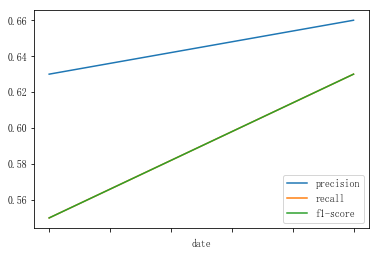

In [65]:
PR_plot_data[PR_plot_data['label'] == 'avg/total'][[ 'date', 'precision', 'recall' ,'f1-score']].plot(x = 'date')
PR_plot_data[PR_plot_data['label'] == 'avg/total']

precision                                            
label         产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                          
20181008     0.510  0.410  0.640 0.900 0.380 0.260 0.510 0.720
20181030     0.620  0.480  0.720 0.800 0.650 0.510 0.550 0.740

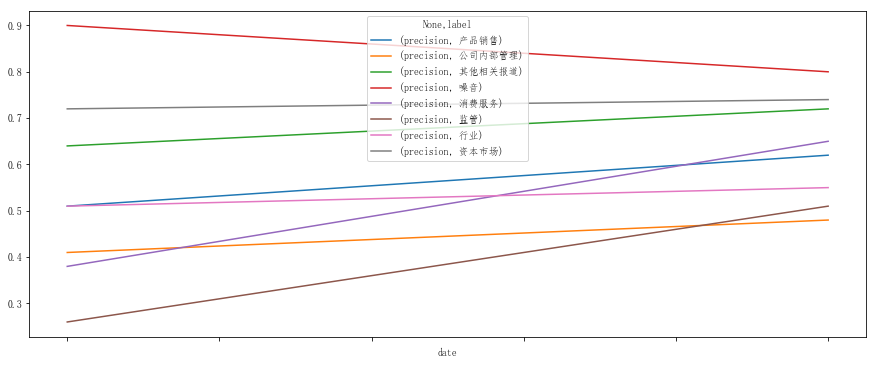

In [66]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'precision']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

recall                                            
label      产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                       
20181008  0.780  0.560  0.720 0.420 0.230 0.880 0.540 0.820
20181030  0.890  0.600  0.790 0.450 0.500 0.850 0.580 0.710

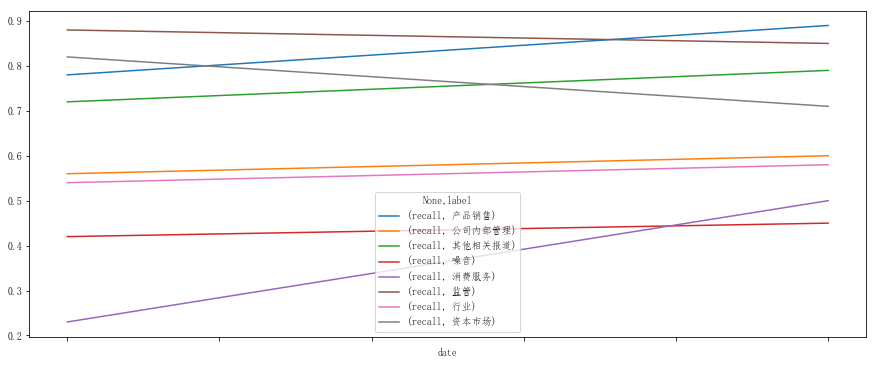

In [67]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'recall']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

f1-score                                            
label        产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                         
20181008    0.620  0.470  0.680 0.580 0.290 0.400 0.530 0.770
20181030    0.730  0.540  0.750 0.580 0.560 0.640 0.570 0.720

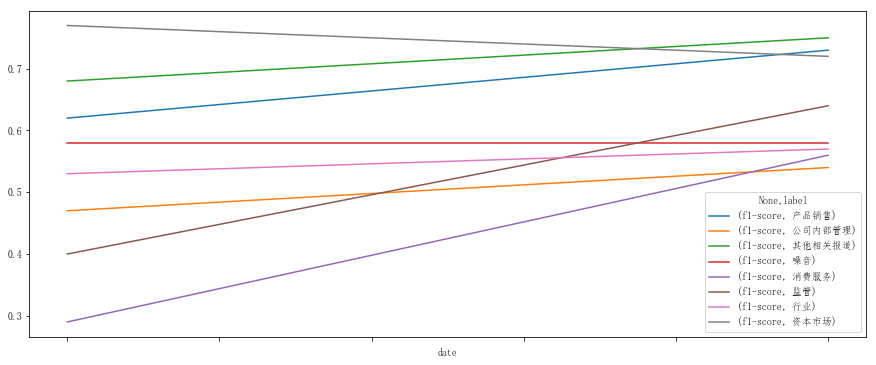

In [68]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'f1-score']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

## 合并数据

In [69]:
cbrc_raw_class = pd.concat([cbrc_raw_class_1, cbrc_raw_class_2, cbrc_raw_class_4
                          #cbrc_raw_class_3, 
                        ], 
                         axis = 0)

# cbrc_raw = cbrc_raw_class_4
cbrc_raw_class['title_content'] = cbrc_raw_class['title'].astype(str) + '。' + cbrc_raw_class['content'].astype(str)
cbrc_raw_class['label'] = cbrc_raw_class['label'].apply(lambda x:x.strip())
# cbrc_raw_class['index'] = range(cbrc_raw_class.shape[0])
print('去重前： ', cbrc_raw_class.shape)
cbrc_raw_class = cbrc_raw_class.drop_duplicates(subset = 'title_content')
print('去重后： ', cbrc_raw_class.shape)
cbrc_raw_class.head()

去重前：  (14197, 4)
去重后：  (14192, 4)


,label,title,content,title_content
0,噪音,月线反转阴包阳，原油逢高先空——股友2ze8vS149120——东方财富网博客2015,月线反转阴包阳，原油逢高先空\n(2018-08-01 09:59:13)\n\n美原油市场昨日完成了7月的最终形态构造，回顾一下月线的走势，7月初行情低开在73.67的位置后行情先回补缺口给出75.27的新高后行情受到压力开始回落，周线形成黄昏之星形态后行情延续下行月中行情最低给到了66.27的位置后行情开始整理，最终月线收线在了68附近后，月线行情以一根下影线稍长于上影线的大阴线形态收线，而这样的形态收尾后，月线形成阴包阳技术信号，月线有进一步回落给低点的需求，点位上，今日给出69附近轻仓空，止损69.5，目标看68和67.5附近。\n\n上海原油操作，今日给出505空，止损507下方目标看501和497附近。\n\n基本面，刚刚结束的7月基本面可以说大事件频繁，中美开端，欧美避免以及美国对伊朗的制裁以及美国第二季度GDP增速提高都是一个长远性质的基本面事件，但这些事件的相关方都带了一个美国，那么下一步美国的动向就非常重要了，目前距离美国的中期选举还有100天的时间，特朗普要想继续连任，那么国内的经济稳定以及其竞选的言论得到实施还有就业能进一步增强就是其连任的核心，而在影响最大的中美上美国目前用150亿美元回补美国的大豆种植者在很大程度上缓解了这一事件对其国内的影响，而尽管单边主义不利于世界经济，但美国作为最大的经济体，美元作为目前国际上唯一的国际货币可以说是主导全球的经济发展方向，美国在的损失世界其他国家会补充给美国，而中国虽然政府很富，但的后果只能由中国民众来承担，长此以往只会加重国内的通胀压力，而税负增加，房地产泡沫巨大，民众和民企都艰难度日的环境下，想要扩大内需消耗掉所带来的影响并非易事，想要找到出路中国政府需另辟蹊径而非一味对抗。今日的基本面主要看20:15的美国ADP就业数据，此数据也是非农前的预期，随后看22:00的美国ISM制造业指数和营建许可，随后22:30关注美国EIA原油库存报告即可，这一数据在上周意外大跌之后，本周的数据非常重要，最后关注明晨2:00的美联储利率决定上限即可。\n\n操作上，美原油：今日给出69附近轻仓空，止损69.5，目标看68和67.5附近。\n\n上海原油：今日给出505空，止损507下方目标看501和497附近。\n\n阅读（\n121\n） | 评论（\n1\n）| \n分享\n\n前一篇：\n一根大阳穿...,月线反转阴包阳，原油逢高先空——股友2ze8vS149120——东方财富网博客2015。月线反转阴包阳，原油逢高先空\n(2018-08-01 09:59:13)\n\n美原油市场昨日完成了7月的最终形态构造，回顾一下月线的走势，7月初行情低开在73.67的位置后行情先回补缺口给出75.27的新高后行情受到压力开始回落，周线形成黄昏之星形态后行情延续下行月中行情最低给到了66.27的位置后行情开始整理，最终月线收线在了68附近后，月线行情以一根下影线稍长于上影线的大阴线形态收线，而这样的形态收尾后，月线形成阴包阳技术信号，月线有进一步回落给低点的需求，点位上，今日给出69附近轻仓空，止损69.5，目标看68和67.5附近。\n\n上海原油操作，今日给出505空，止损507下方目标看501和497附近。\n\n基本面，刚刚结束的7月基本面可以说大事件频繁，中美开端，欧美避免以及美国对伊朗的制裁以及美国第二季度GDP增速提高都是一个长远性质的基本面事件，但这些事件的相关方都带了一个美国，那么下一步美国的动向就非常重要了，目前距离美国的中期选举还有100天的时间，特朗普要想继续连任，那么国内的经济稳定以及其竞选的言论得到实施还有就业能进一步增强就是其连任的核心，而在影响最大的中美上美国目前用150亿美元回补美国的大豆种植者在很大程度上缓解了这一事件对其国内的影响，而尽管单边主义不利于世界经济，但美国作为最大的经济体，美元作为目前国际上唯一的国际货币可以说是主导全球的经济发展方向，美国在的损失世界其他国家会补充给美国，而中国虽然政府很富，但的后果只能由中国民众来承担，长此以往只会加重国内的通胀压力，而税负增加，房地产泡沫巨大，民众和民企都艰难度日的环境下，想要扩大内需消耗掉所带来的影响并非易事，想要找到出路中国政府需另辟蹊径而非一味对抗。今日的基本面主要看20:15的美国ADP就业数据，此数据也是非农前的预期，随后看22:00的美国ISM制造业指数和营建许可，随后22:30关注美国EIA原油库存报告即可，这一数据在上周意外大跌之后，本周的数据非常重要，最后关注明晨2:00的美联储利率决定上限即可。\n\n操作上，美原油：今日给出69附近轻仓空，止损69.5，目标看68和67.5附近。\n\n上海原油：今日给出505空，止损507下方目标看501和497附近。\n\n...
1,噪音,汇乔金色名都在售价格为：18000元/平方米,"汇乔金色名都18000元/平方米。毛坯,非毛坯交房。汇乔金色名都项目为小高层,高层。坦洲镇界狮南路30号珠海造贝路口500米处。绿化率35%。汇乔金色名都容积率2.5。物业费：1.8元/㎡·月。项目规划建设2976户。汇翠学校、广大附中、坦洲实验中学,珠海曾正理工,华发商都、华润万家、泰峰电器、世纪银星广场、国美电器,南华医院、南屏医院、上冲医院、坦洲医院,建行、中行、交行、工行,超市、酒店、医院、餐饮、市场、银行等生活配套。敬请关注。","汇乔金色名都在售价格为：18000元/平方米。汇乔金色名都18000元/平方米。毛坯,非毛坯交房。汇乔金色名都项目为小高层,高层。坦洲镇界狮南路30号珠海造贝路口500米处。绿化率35%。汇乔金色名都容积率2.5。物业费：1.8元/㎡·月。项目规划建设2976户。汇翠学校、广大附中、坦洲实验中学,珠海曾正理工,华发商都、华润万家、泰峰电器、世纪银星广场、国美电器,南华医院、南屏医院、上冲医院、坦洲医院,建行、中行、交行、工行,超市、酒店、医院、餐饮、市场、银行等生活配套。敬请关注。"
2,噪音,冒充微博好友实施诈骗 嫌疑人模仿“谍战”以“暗语”联系,好朋友突然在微博上私信你，让你帮忙转账购买高价机票&hellip;&hellip;谁能想到这是一个骗局而且竟然还是甥舅三人所为，为了逃避打击这三个&ldquo;心机boy&rdquo;竟然还模仿谍战片独创了一套&ldquo;暗语&rdquo;。\n\n近日，南宁市公安局便衣侦查支队五大队经过长线经营，打掉了一个以&ldquo;克隆&rdquo;微博冒充好友，请求帮忙买机票方式实施诈骗的犯罪团伙，抓获廖某程、廖某铭、韦某强3名犯罪嫌疑人，缴获作案工具一批。\n\n(图片) ​\n\n4000元钱打出去之后对方失联\n\n&ldquo;兄弟，你帮我买两张后天下午前往上海的飞机票。&rdquo;雷先生在微博里接到朋友罗先生的信息后，根据罗先生提供的联系方式购买机票。结果，4000元钱打出去后，机票没买到，对方电话也无法打通。其实，罗先生的微博已经被不法分子&ldquo;克隆&rdquo;。\n\n雷先生是外地人。5月8日，雷先生的微博里突然接到朋友罗先生发来一条信息说，他和领导刚接到通知，要求在后天下午到上海出差，目前急需购买两张飞机票，但由于业务在身，希望雷先生能&ldquo;帮忙购买两张机票，日后还款&rdquo;。\n\n微博信息里，罗先生发来身份证号等信息后，还提供了一个电话号码，联系人为潘经理。罗先生说，他以前多次跟潘经理买过机票，可以享受优惠票价，并叫雷先生&ldquo;跟潘经理联系就可以了&rdquo;。受朋友之托，雷先生不敢怠慢。在电话里，他按要求报读罗先生提供的身份证号码等信息后，对方说5月10日下午飞往上海的航班只剩下少量机票，如需购买就尽快把钱打到指定银行账上。一旦手机收到信息，就意味着买票成功。\n\n但雷先生按要求把4000元钱打到指定银行账户后，他的手机却没有收到机场方面发回的信息，这就意味着雷先生买票不成功。然而，钱已经转入对方账户上。雷先生便拨打对方的电话号码，语音却提示无法接通。罗先生知道此事后，连喊&ldquo;你受骗了&rdquo;，并让雷先生尽快报案。\n\n(图片)\n\n网络图片\n\n微博名称里加小符号克隆微博\n\n据南宁市公安局便衣侦查支队相关负责人介绍，他们接到外地警方协查通报之后，通过大数据研判发现，涉案团伙的窝点就在宾阳县宾州镇商贸城附近。于是办案民警前往宾州镇商贸城周边展开侦查。\n\n6月27日，民警在宾...,冒充微博好友实施诈骗 嫌疑人模仿“谍战”以“暗语”联系。好朋友突然在微博上私信你，让你帮忙转账购买高价机票&hellip;&hellip;谁能想到这是一个骗局而且竟然还是甥舅三人所为，为了逃避打击这三个&ldquo;心机boy&rdquo;竟然还模仿谍战片独创了一套&ldquo;暗语&rdquo;。\n\n近日，南宁市公安局便衣侦查支队五大队经过长线经营，打掉了一个以&ldquo;克隆&rdquo;微博冒充好友，请求帮忙买机票方式实施诈骗的犯罪团伙，抓获廖某程、廖某铭、韦某强3名犯罪嫌疑人，缴获作案工具一批。\n\n(图片) ​\n\n4000元钱打出去之后对方失联\n\n&ldquo;兄弟，你帮我买两张后天下午前往上海的飞机票。&rdquo;雷先生在微博里接到朋友罗先生的信息后，根据罗先生提供的联系方式购买机票。结果，4000元钱打出去后，机票没买到，对方电话

In [70]:
print(cbrc_raw_class.shape)
cbrc_raw_class.groupby('label')['title'].count()

(14192, 4)


label
产品销售      1311
公司内部管理    1415
其他相关报道    2030
噪音        2721
消费服务      1710
监管        1640
行业        1786
资本市场      1579
Name: title, dtype: int64

In [71]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%S:%M")
circ_raw_class_num = cbrc_raw_class.groupby('label')['title'].count().reset_index()
circ_raw_class_num.columns = ['label', 'num']
tmp_num = pd.DataFrame([['日期：', now],
                        ['总量', circ_raw_class_num['num'].sum(axis = 0)]],
                      columns = ['label', 'num'])
circ_raw_class_num = pd.concat([tmp_num, circ_raw_class_num])
circ_raw_class_num.T.to_csv('statistics_result/CBRC_class_data_num.csv', index = False, mode = 'a', encoding = 'utf-8')
circ_raw_class_num.T

,0,1,0,1,2,3,4,5,6,7
label,日期：,总量,产品销售,公司内部管理,其他相关报道,噪音,消费服务,监管,行业,资本市场
num,2018-11-27 09:00:49,14192,1311,1415,2030,2721,1710,1640,1786,1579


## 预处理

In [24]:
save_folder = 'cbrc_result_class/'
pre_save(pre_cor_cbrc.handle_contents, cbrc_raw_class, save_folder)

(14192, 4)
save_folder:  cbrc_result_class/
title num:  14192
content num:  14192
月线 反转 阴包 阳 原油 高先 空美 原油 市场 昨日 月 最终 形态 构造 回顾 月线 走势 月初 行情 低开 位置 行情 先回 补缺 口 给出 新高 行情 压力 回落 周线 黄昏 之星 形态 行情 延续 下行 月 中 行情 最低 位置 行情 整理 最终 月线 收线 后月线 行情 一根 下影线 稍长 上海 原油 操作 今日 给出 空 止损 下方 目标 基本面 刚刚 结束 月 基本面 说 事件 频繁 中 美 开端 欧美 美国 伊朗 制裁 美国 第二季度 增速 提高 长远 性质 基本面 事件 事件 相 今日 基本面 美国 就业 数据 数据 非农 前 预期 美国 制造业 指数 营建 许可 操作 上美 原油 今日 给出 轻仓空 止损 目标 上海 原油 今日 给出 空 止损 下方 目标 阅读 评论 分享 前 一篇 一根 大阳 穿云箭 原油 回 踩 做 
label num:  14192


# 银行业：2 倾向性

## 读取数据

In [86]:
folder = 'cbrc_data_tendency/20181114'

### 预测正确数据

In [87]:
# file_list_1 = ['circ_class_sel_else_20180827.xlsx',]
# circ_raw_class_1 = predict_right(folder, file_list_1)

# circ_raw_class_1['label'] = circ_raw_class_1['label'].apply(lambda x:x.strip())    
# circ_raw_class_1 = circ_raw_class_1[['label', 'raw_title', 'raw_content']]
# circ_raw_class_1.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_1.shape)
# circ_raw_class_1.head()

In [88]:
# circ_raw_class_1['label'].value_counts()

### 预测错误修正后数据

In [89]:
# file_list_2 = ['circ_class_sel_20180827-1.xlsx','circ_class_sel_20180827-2.xlsx']

# circ_raw_class_2 = correct_wrong_data(folder, file_list_2)
# circ_raw_class_2['label'] = circ_raw_class_2['label'].apply(lambda x:x.strip())  
# circ_raw_class_2 = circ_raw_class_2[['备注', 'raw_title', 'raw_content']]
# circ_raw_class_2.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_2.shape)
# circ_raw_class_2.head()

In [90]:
# circ_raw_class_2['label'].value_counts()

### 新补充数据

In [91]:
file_list_3 = ['180523银监会非负数据.xlsx', '180523银监会负面数据.xlsx',
               ] # 多个 sheet

cbrc_raw_tendency_3 = get_new_data(folder, file_list_3)

# circ_raw_tendency_3['label'] = circ_raw_tendency_3['label'].apply(lambda x:x.strip())    
print('总数：', cbrc_raw_tendency_3.shape)
cbrc_raw_tendency_3.head()

Index(['title', 'content', 'label'], dtype='object')
去空值前：  (1934, 3) 180523银监会非负数据.xlsx Sheet1
去空值后：  (1934, 3) 180523银监会非负数据.xlsx Sheet1
Index(['title', 'content', 'label'], dtype='object')
去空值前：  (2048, 3) 180523银监会负面数据.xlsx Sheet1
去空值后：  (2048, 3) 180523银监会负面数据.xlsx Sheet1
总数： (3982, 3)


,label,title,content
0,0,[推荐评级]银行业动态报告：同业存单监管对银行并非利空,[推荐评级]银行业动态报告：同业存单监管对银行并非利空 时间：2017年08月15日 15:02:46中财网 报告摘要：\\n 同业存单纳入监管后其利率或将下行：利好银行净息差央行在二季度货币政策执行报告中称，拟于 2018年一季度评估时起，将资产规模 5000亿元以上的银行发行的同业存单纳入同业负债占比指标进行考核。\\n\\n 在现行MPA 考核中，若是追求B 档合格，则只要广义信贷满足要求，同业负债占比指标事实上是可以放弃的。所以此次口径调整最重要的是表达当局对同业存单的坚决态度。其具体后续影响是否扩大，要看银监会是否会跟进修改这一口径。\\n\\n 未来中小行应会减少同业存单发行量，同业利率随之下行，成本变化向好。当前银行ROA 处于1%左右的水平下，较少的成本变化就会对息差改善造成较大影响。\\n\\n 或有部分股份制银行出现缩表：利好银行股\\n 按银监会监管月度数据测算，环比一季度，二季度商业银行总资产规模增速1.4%，其中大行与城商行增速皆为1.6%，而股份制行仅为0.2%，大幅拉低整体水平。\\n\\n 结合同期同业存单规模收缩情况，我们判断中报或将披露部分股份制银行缩表。\\n\\n 此轮同业存单收缩或将引发的缩表，并非利空信号。之前在货币政策相对宽松时，银行拿同业存单冲规模的行为，在货币政策转向中性甚至边际收紧后，负债端成本会上升，通过息差收窄对ROE 产生负面影响。同理，如果货币环境出现边际改善，则负债端成本的下降又会对ROE 反向演绎。但长期来看，银行的ROE 对投资者而言比规模增速更加重要。不同于其他行业，银行的杠杆率由资本充足率限定，因而规模的扩张需要相应的资本匹配。若资产规模增速超过银行ROE，银行的资本增速就赶不上规模增速，长期来看需要进行再融资，则多出来这部分规模所创造利润，归属新股东。相反，若银行的规模增速低于ROE，多出来的利润可以进行分红，股东可以拿分红再投资该银行股，在银行一倍PB 左右估值的背景下，手里股票净值的增长仍然接近ROE。因此，我们认为若中报个别股份行出现缩表，而市场届时有不正确的解读导致银行股出现回调，将是很好的投资机会。\\n\\n 投资建议：继续推荐大行，工商银行、建设银行；等待中报业绩落地后，关注下半年股份行的...
1,0,“2030年中国投资行业将管理17万亿美元资产”,中国关注 根据预测，到2030年中国将成为仅次于美国的世界第二大资产管理市场，在全球投资管理公司吸引的资金净流入量中占一半。 对照英文 收藏 更新于2017年11月13日 07:17 英国《金融时报》 克里斯.弗勒德 报道 资产管理在中国是一个相对年轻的行业，但是鉴于中国人口老龄化和不断壮大的中产阶层财富日益增加，该行业正处于长期强劲增长的轨道。 咨询公司Casey Quick预测，其结果是，中国投资行业的管理资产将从去年底的2.8万亿美元左右，增至2030年的17万亿美元左右。 到2030年，全球投资管理公司吸引的资金净流入量中，大约一半（8.5万亿美元）将流向中国公司，推动中国成为世界第二大资产管理市场，仅次于美国。 Casey Quick称，富裕的中国企业主和散户投资者将占到截至2030年的预期资产增长的一半。 在工作单位退休储蓄计划扩大的推动下，养老金资产预计将每年增长10%左右。 保险公司也将外包更多业务给第三方资产管理公司，以帮助提高回报，但中国两只主权财富基金的新资金预计将会有限，这意味着它们的未来增长将依赖于资产配置决策和市场变动。 然而，试图在中国赢得新业务的外资管理公司将面临重大挑战。考虑到内地投资者存在明显的本土偏向，以及本地投资管理公司和产品分销商之间的密切关系，外资管理公司预计只能争取到中国市场6%的业务。 但是，放开中国资本市场的进一步措施可能惠及在国际资产市场上保持优势的外资管理公司。预计到2030年，中国机构投资者对中国以外资产类别的配置将增至17%左右，中国富人投资者的这一比例将增至15%。 译者/和风
2,0,“317”调控满一年：京城部分银行首套房贷款利率继续上调,本报见习记者 刘 萌 2017年3月17日，为遏制楼市过热，北京市出台了被业内人士称为的“史上最严厉楼市调控措施”，一年的调控使楼市逐渐回归理性。同时，随着成交量的减少，银行按揭贷款的收紧态势有所缓解。 《证券日报》记者近日走访北京地区多家银行发现，与过去放款周期动辄三个月起步相比，各银行的放款速度明显快了不少。在贷款利率方面，就首套房而言，基准利率上浮10%目前占主流。同时，还有个别银行在上周上调了首套房贷款利率。 首套房贷款利率稳中有升 近日，《证券日报》记者走访了北京地区工商银行、建设银行、交通银行、汇丰银行、大华银行、中信银行、招商银行、北京银行、南京银行、光大银行、民生银行、浦发银行、华夏银行等在内的13家银网点。 其中，5家银行的个贷经理表示，首套房贷款利率最低上浮5%；5家银行表示最低上浮10%；1家银行表示最低上浮10%，常批上浮15%；1家银行表示最低上浮15%；1家银行表示最低上浮20%。 上述银行中，有两家银行在3月22日刚刚上调了首套房贷款利率。一家银行将首套房贷利率从基准利率上浮5%上调为基准利率上浮15%，在3月22日之前完成审批的不受影响。另一家银行将首套房贷利率从基准利率上调为基准利率上浮10%，优质客户可以申请基准利率上浮5%，但不保证获批，同时根据申请人数进行调整。 除此之外，在《证券日报》记者走访过程中，还有其他银行工作人员表示“首套房贷款利率可能继续上调”。 以某股份制银行为例，该行目前对于首套房贷款利率执行基准利率上浮10%的标准。当本报记者咨询“贷款利率以及放款周期”等问题时，个贷经理回答道：“如果还没有签合同，建议签完合同完成资质审核等前期流程再来咨询。近期可能会继续上调首套房贷款利率，我们在等待总行通知。” 同时，上述个贷经理告诉本报记者：“由于近期房屋成交量不高，放款速度比较平稳，一般面签后5个工作日批贷，房本抵押后1-2周就可以放款。” 以某国有大行为例，目前该行首套房贷款利率最低上浮5%，常批利率为基准利率上浮10%。在记者调查时，个贷经理表示：“未来可能统一调整为最低上浮10%，如果房子已经看好，建议尽快走流程。” 在某首套房贷款利率上浮20%的股份制银行，工作人员告诉《证券日报》记者：“我们支行在利率上浮后还没有任何客户，不太了解银行的放款周...
3,0,“930”京城房贷新政一周年： 首套房贷款利率持续走高,部分银行10月1日起执行新的首套房利率政策，并较原利率小幅上浮 本报记者 彭 妍 去年国庆假期前，北京楼市出台“9 30新政”，让过热的市场开始回归理性。新政出台至今已满一周年，近日《证券日报》记者走访发现，一年来，京城首套房房贷利率持续走高，首套房房贷利率上浮5%-10%成为主流，同时个别银行调整为最低执行基准利率上浮20%的利率政策。 在利率上浮的同时，银行房贷的放款期限也在延长。但让人欣慰的是，中介公司人员表示，目前的房价已经回落至今年春节前的水平，二手房市场由之前的卖方市场变成了现在的买方市场，购房者的议价空间也在加大。 房贷利率持续上调 随着楼市信贷不断收紧，房贷利率继续走高。作为本轮楼市调控中的主力军，北京市的房贷利率更是经历了七次重要调整，调整后首套房贷利率较基准利率上浮5% 10%成为主流，部分银行甚至将首套房贷利率上调到基准利率20%的水平。 在去年9月30日之前，首套房贷利率曾多次出现松动，彼时首套房贷款利率八五折成为主流；今年元旦过后，北京绝大多数银行将首套房贷款利率折扣从八五折上调至九折；3月21日，北京地区16家银行将首套房贷款折扣从九折上调至九五折；“五一”假期后，北京地区8家银行将首套房贷款利率折扣从九五折上调至基准利率；端午节后，北京地区绝大多数国有大行、股份制银行、城商行的首套房贷款利率回到基准利率；6月5日，北京地区个别银行的首套房贷款利率在基准利率基础上上浮10%，但多数银行并没有动作；自9月14日起，北京地区多家银行继续上调首套房贷款利率，少数银行还执行基准利率。 国庆长假期间，记者从某中介机构手里拿到一份名为“利率调整执行落实 商贷新”的文件，文件公布了商业贷款各行利率调整执行标准，该文件整理的时间是9月14日。该文件公布了与他们中介公司合作的所有银行执行的利率，基本上覆盖了主流银行，其中除了浙商银行执行首套房执行基准利率九八折、华夏银行和南京银行首套房执行基准利率外，多数银行首套房房贷利率上浮5%-10%，个别银行上浮20%。 《证券日报》记者也电话咨询了多家银行进行了解，获得结果是部分银行本月起再次上调首套房房贷利率：浙商银行从10月1日起，首套房利率执行的是基准利率上浮3%；南京银行目前首套房房贷利率上浮10%，浦发银行目前首套房房贷利率上浮20%...
4,0,“BATJ”与四大行合作落地 百度金融农行推出“AB贷”,■本报记者 张 歆 \\n 11月16日，在2017百度世界智能金融分论坛上，百度高级副总裁朱光透露，百度与农业银行的战略合作，一期工程已到验收阶段，已经有产品逐步落地。随后，农业银行相关人士宣布，双方合作的AB贷产品已于11月16日上线，“今天上午10点10分，第一笔AB贷贷款已发布。”\\n 今年6月份，互联网龙头“BATJ”不约而同选择与四大行“结对子”。其中，百度与农业银行达成战略合作，共建农行金融大脑以及客户画像、精准营销、客户信用评价、风险监控、智能投顾、智能客服等六个方向

In [92]:
cbrc_raw_tendency_3['label'].value_counts()

-1    2048
 0    1934
Name: label, dtype: int64

### 模型预测后反馈数据

In [93]:
# file_list_4 = ['20180904_circ_class_feedback.xlsx', '20180904_circ_class_feedback_1.xlsx',
#               ] # 多个 sheet

# circ_raw_class_4 = get_feedback_data(folder, file_list_4)

# circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
# print('总数：', circ_raw_class_4.shape)
# circ_raw_class_4.head()

In [94]:
# circ_raw_class_4['label'].value_counts()

## 合并数据

In [95]:
# circ_raw_tendency = pd.concat([circ_raw_class_1, circ_raw_class_2,
#                           circ_raw_class_3, circ_raw_class_4], 
#                          axis = 0)

cbrc_raw_tendency = cbrc_raw_tendency_3
cbrc_raw_tendency['title_content'] = cbrc_raw_tendency['title'].astype(str) + '。' + cbrc_raw_tendency['content'].astype(str)
# circ_raw_tendency['label'] = circ_raw_tendency['label'].apply(lambda x:x.strip())
# circ_raw_tendency['index'] = range(circ_raw_tendency.shape[0])
print('去重前： ', cbrc_raw_tendency.shape)
cbrc_raw_tendency = cbrc_raw_tendency.drop_duplicates(subset = 'title_content')
print('去重后： ', cbrc_raw_tendency.shape)
cbrc_raw_tendency.head()

去重前：  (3982, 4)
去重后：  (3982, 4)


,label,title,content,title_content
0,0,[推荐评级]银行业动态报告：同业存单监管对银行并非利空,[推荐评级]银行业动态报告：同业存单监管对银行并非利空 时间：2017年08月15日 15:02:46中财网 报告摘要：\\n 同业存单纳入监管后其利率或将下行：利好银行净息差央行在二季度货币政策执行报告中称，拟于 2018年一季度评估时起，将资产规模 5000亿元以上的银行发行的同业存单纳入同业负债占比指标进行考核。\\n\\n 在现行MPA 考核中，若是追求B 档合格，则只要广义信贷满足要求，同业负债占比指标事实上是可以放弃的。所以此次口径调整最重要的是表达当局对同业存单的坚决态度。其具体后续影响是否扩大，要看银监会是否会跟进修改这一口径。\\n\\n 未来中小行应会减少同业存单发行量，同业利率随之下行，成本变化向好。当前银行ROA 处于1%左右的水平下，较少的成本变化就会对息差改善造成较大影响。\\n\\n 或有部分股份制银行出现缩表：利好银行股\\n 按银监会监管月度数据测算，环比一季度，二季度商业银行总资产规模增速1.4%，其中大行与城商行增速皆为1.6%，而股份制行仅为0.2%，大幅拉低整体水平。\\n\\n 结合同期同业存单规模收缩情况，我们判断中报或将披露部分股份制银行缩表。\\n\\n 此轮同业存单收缩或将引发的缩表，并非利空信号。之前在货币政策相对宽松时，银行拿同业存单冲规模的行为，在货币政策转向中性甚至边际收紧后，负债端成本会上升，通过息差收窄对ROE 产生负面影响。同理，如果货币环境出现边际改善，则负债端成本的下降又会对ROE 反向演绎。但长期来看，银行的ROE 对投资者而言比规模增速更加重要。不同于其他行业，银行的杠杆率由资本充足率限定，因而规模的扩张需要相应的资本匹配。若资产规模增速超过银行ROE，银行的资本增速就赶不上规模增速，长期来看需要进行再融资，则多出来这部分规模所创造利润，归属新股东。相反，若银行的规模增速低于ROE，多出来的利润可以进行分红，股东可以拿分红再投资该银行股，在银行一倍PB 左右估值的背景下，手里股票净值的增长仍然接近ROE。因此，我们认为若中报个别股份行出现缩表，而市场届时有不正确的解读导致银行股出现回调，将是很好的投资机会。\\n\\n 投资建议：继续推荐大行，工商银行、建设银行；等待中报业绩落地后，关注下半年股份行的...,[推荐评级]银行业动态报告：同业存单监管对银行并非利空。[推荐评级]银行业动态报告：同业存单监管对银行并非利空 时间：2017年08月15日 15:02:46中财网 报告摘要：\\n 同业存单纳入监管后其利率或将下行：利好银行净息差央行在二季度货币政策执行报告中称，拟于 2018年一季度评估时起，将资产规模 5000亿元以上的银行发行的同业存单纳入同业负债占比指标进行考核。\\n\\n 在现行MPA 考核中，若是追求B 档合格，则只要广义信贷满足要求，同业负债占比指标事实上是可以放弃的。所以此次口径调整最重要的是表达当局对同业存单的坚决态度。其具体后续影响是否扩大，要看银监会是否会跟进修改这一口径。\\n\\n 未来中小行应会减少同业存单发行量，同业利率随之下行，成本变化向好。当前银行ROA 处于1%左右的水平下，较少的成本变化就会对息差改善造成较大影响。\\n\\n 或有部分股份制银行出现缩表：利好银行股\\n 按银监会监管月度数据测算，环比一季度，二季度商业银行总资产规模增速1.4%，其中大行与城商行增速皆为1.6%，而股份制行仅为0.2%，大幅拉低整体水平。\\n\\n 结合同期同业存单规模收缩情况，我们判断中报或将披露部分股份制银行缩表。\\n\\n 此轮同业存单收缩或将引发的缩表，并非利空信号。之前在货币政策相对宽松时，银行拿同业存单冲规模的行为，在货币政策转向中性甚至边际收紧后，负债端成本会上升，通过息差收窄对ROE 产生负面影响。同理，如果货币环境出现边际改善，则负债端成本的下降又会对ROE 反向演绎。但长期来看，银行的ROE 对投资者而言比规模增速更加重要。不同于其他行业，银行的杠杆率由资本充足率限定，因而规模的扩张需要相应的资本匹配。若资产规模增速超过银行ROE，银行的资本增速就赶不上规模增速，长期来看需要进行再融资，则多出来这部分规模所创造利润，归属新股东。相反，若银行的规模增速低于ROE，多出来的利润可以进行分红，股东可以拿分红再投资该银行股，在银行一倍PB 左右估值的背景下，手里股票净值的增长仍然接近ROE。因此，我们认为若中报个别股份行出现缩表，而市场届时有不正确的解读导致银行股出现回调，将是很好的投资机会。\\n\\n 投资建议：继续推荐大行，工...
1,0,“2030年中国投资行业将管理17万亿美元资产”,中国关注 根据预测，到2030年中国将成为仅次于美国的世界第二大资产管理市场，在全球投资管理公司吸引的资金净流入量中占一半。 对照英文 收藏 更新于2017年11月13日 07:17 英国《金融时报》 克里斯.弗勒德 报道 资产管理在中国是一个相对年轻的行业，但是鉴于中国人口老龄化和不断壮大的中产阶层财富日益增加，该行业正处于长期强劲增长的轨道。 咨询公司Casey Quick预测，其结果是，中国投资行业的管理资产将从去年底的2.8万亿美元左右，增至2030年的17万亿美元左右。 到2030年，全球投资管理公司吸引的资金净流入量中，大约一半（8.5万亿美元）将流向中国公司，推动中国成为世界第二大资产管理市场，仅次于美国。 Casey Quick称，富裕的中国企业主和散户投资者将占到截至2030年的预期资产增长的一半。 在工作单位退休储蓄计划扩大的推动下，养老金资产预计将每年增长10%左右。 保险公司也将外包更多业务给第三方资产管理公司，以帮助提高回报，但中国两只主权财富基金的新资金预计将会有限，这意味着它们的未来增长将依赖于资产配置决策和市场变动。 然而，试图在中国赢得新业务的外资管理公司将面临重大挑战。考虑到内地投资者存在明显的本土偏向，以及本地投资管理公司和产品分销商之间的密切关系，外资管理公司预计只能争取到中国市场6%的业务。 但是，放开中国资本市场的进一步措施可能惠及在国际资产市场上保持优势的外资管理公司。预计到2030年，中国机构投资者对中国以外资产类别的配置将增至17%左右，中国富人投资者的这一比例将增至15%。 译者/和风,“2030年中国投资行业将管理17万亿美元资产”。 中国关注 根据预测，到2030年中国将成为仅次于美国的世界第二大资产管理市场，在全球投资管理公司吸引的资金净流入量中占一半。 对照英文 收藏 更新于2017年11月13日 07:17 英国《金融时报》 克里斯.弗勒德 报道 资产管理在中国是一个相对年轻的行业，但是鉴于中国人口老龄化和不断壮大的中产阶层财富日益增加，该行业正处于长期强劲增长的轨道。 咨询公司Casey Quick预测，其结果是，中国投资行业的管理资产将从去年底的2.8万亿美元左右，增至2030年的17万亿美元左右。 到2030年，全球投资管理公司吸引的资金净流入量中，大约一半（8.5万亿美元）将流向中国公司，推动中国成为世界第二大资产管理市场，仅次于美国。 Casey Quick称，富裕的中国企业主和散户投资者将占到截至2030年的预期资产增长的一半。 在工作单位退休储蓄计划扩大的推动下，养老金资产预计将每年增长10%左右。 保险公司也将外包更多业务给第三方资产管理公司，以帮助提高回报，但中国两只主权财富基金的新资金预计将会有限，这意味着它们的未来增长将依赖于资产配置决策和市场变动。 然而，试图在中国赢得新业务的外资管理公司将面临重大挑战。考虑到内地投资者存在明显的本土偏向，以及本地投资管理公司和产品分销商之间的密切关系，外资管理公司预计只能争取到中国市场6%的业务。 但是，放开中国资本市场的进一步措施可能惠及在国际资产市场上保持优势的外资管理公司。预计到2030年，中国机构投资者对中国以外资产类别的配置将增至17%左右，中国富人投资者的这一比例将增至15%。 译者/和风
2,0,“317”调控满一年：京城部分银行首套房贷款利率继续上调,本报见习记者 刘 萌 2017年3月17日，为遏制楼市过热，北京市出台了被业内人士称为的“史上最严厉楼市调控措施”，一年的调控使楼市逐渐回归理性。同时，随着成交量的减少，银行按揭贷款的收紧态势有所缓解。 《证券日报》记者近日走访北京地区多家银行发现，与过去放款周期动辄三个月起步相比，各银行的放款速度明显快了不少。在贷款利率方面，就首套房而言，基准利率上浮10%目前占主流。同时，还有个别银行在上周上调了首套房贷款利率。 首套房贷款利率稳中有升 近日，《证券日报》记者走访了北京地区工商银行、建设银行、交通银行、汇丰银行、大华银行、中信银行、招商银行、北京银行、南京银行、光大银行、民生银行、浦发银行、华夏银行等在内的13家银网点。 其中，5家银行的个贷经理表示，首套房贷款利率最低上浮5%；5家银行表示最低上浮10%；1家银行表示最低上浮10%，常批上浮15%；1家银行表示最低上浮15%；1家银行表示最低上浮20%。 上述银行中，有两家银行在3月22日刚刚上调了首套房贷款利率。一家银行将首套房贷利率从基准利率上浮5%上调为基准利率上浮15%，在3月22日之前完成审批的不受影响。另一家银行将首套房贷利率从基准利率上调为基准利率上浮10%，优质客户可以申请基准利率上浮5%，但不保证获批，同时根据申请人数进行调整。 除此之外，在《证券日报

In [96]:
print(cbrc_raw_tendency.shape)
cbrc_raw_tendency.groupby('label')['title_content'].count()

(3982, 4)


label
-1    2048
 0    1934
Name: title_content, dtype: int64

In [98]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%S:%M")
circ_raw_class_num = cbrc_raw_tendency.groupby('label')['title'].count().reset_index()
circ_raw_class_num.columns = ['label', 'num']
tmp_num = pd.DataFrame([['日期：', now],
                        ['总量', circ_raw_class_num['num'].sum(axis = 0)]],
                      columns = ['label', 'num'])
circ_raw_class_num = pd.concat([tmp_num, circ_raw_class_num])
circ_raw_class_num.T.to_csv('statistics_result/CBRC_tendency_data_num.csv', index = False, mode = 'a', encoding = 'utf-8')
circ_raw_class_num.T

,0,1,0,1
label,日期：,总量,-1,0
num,2018-11-27 09:24:53,3982,2048,1934


## 预处理

In [21]:
save_folder = 'cbrc_result_tendency/'
pre_save(pre_cor_cbrc.handle_contents, cbrc_raw_tendency, save_folder)

(3982, 4)
save_folder:  cbrc_result_tendency/
title num:  3982
content num:  3982
推荐 评级 银行业 动态 报告 同业存单 监管 银行 利空 时间 年月日 中财网 报告 摘要 同业存单 纳入 监管 利率 下行 利好 银行 净 息差 央行 二季度 货币政策 执行 报告 中称 拟 现行 考核 中若 追求 档 合格 广义 信贷 满足要求 同业 负债 占 指标 事实上 放弃 口径 调整 表达 当局 同业存单 态度 后续 影响 银监会 跟进 修改 这一 口径 未来 行应会 减少 同业存单 发行量 同业 利率 随之 下行 成本 变化 银行 处 股份制银行 缩表 利好 银行 股 银监会 监管 月度 数据 测算 环比 一季度 二季度 商业银行 总资产 规模 增速 大行 城商行 增速 皆 股份制 行仅 大幅 拉低 整体 水平 同期 同业存单 规模 收缩 情况 判断 中报 披露 股份制银行 缩表 此轮 同业存单 收缩 引发 缩表 利空 信号 货币政策 宽松 时 银行 同业存单 规模 货币政策 转向 中性 边际 收紧 负债 端 成本 息差 收窄 负面影响 同理 货币 环境 边际 改善 负债 端 成本 下降 反向 演绎 长期 银行 投资者 规模 增速 资产 规模 增速 超过 银行 银行 资本 增速 赶不上 规模 增速 长期 再融资 银行 规模 增速 低 中报 股份行 缩表 市场 正确 解读 导致 银行 股 回调 投资 机会 投资 建议 推荐 行 工商银行 建设银行 等待 中 报 业绩 落地 中信银行 估值 修复 空间 南京银行 北京银行 风险 提示 经济 超 预期 下行 导致 资产 质量 大幅 恶化 政策 变化 李锋林 加力 解 巍巍 民生 证券 股份 有限公司 
label num:  3982


# 保存本文件

In [ ]:
if 0:
    import datetime as dt
    
    def output_HTML(read_file, output_file):
        from nbconvert import HTMLExporter
        import codecs
        import nbformat
        exporter = HTMLExporter()
        # read_file is '.ipynb', output_file is '.html'
        output_notebook = nbformat.read(read_file, as_version=4)
        output, resources = exporter.from_notebook_node(output_notebook)
        codecs.open(output_file, 'w', encoding='utf-8').write(output)

    html_file_folder = 'html_files'
    if not os.path.exists(html_file_folder):
        os.makedirs(html_file_folder)

    today = dt.datetime.now().strftime('%Y%m%d')
    current_file = 'circ_cor_model_2_train.ipynb'
    output_file = 'html_files\%s_%s.html'%(os.path.splitext(current_file)[0], today)
    output_HTML(current_file, output_file)